# 得到最终的预期的金属丰度---> expected metallicity
1. 读取pyqz得到的spaxels的金属丰度值
1. 按照画spaxels分布图的形式，画出 金属丰度-表面质量密度 分布图
1. 按照stellar mass 分bin，取出每个bin中peak的金属丰度值

In [4]:
#################################################################################
### 筛选星系：b/a, , Nair_b/a, stellar mass, fracDeV, star-forming spaxels ######
#################################################################################
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
from copy import copy as copy
from os.path import join
import math
import numpy as np
from matplotlib.colors import ListedColormap
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot
import warnings
warnings.filterwarnings('ignore')    # 不显示warning信息

# 读取文件
# MaNGA和Nair的匹配数组【已经去除重复匹配星系】
manga_match_nair = np.loadtxt("./tmp_storage/MaNGA_match_Nair.dat")
manga_match_nair = manga_match_nair.astype(int)
# MaNGA和nsa的匹配数组【已经去除重复匹配星系】
manga_match_nsa = np.loadtxt("./tmp_storage/MaNGA_match_nsa.dat")
manga_match_nsa = manga_match_nsa.astype(int)
# # MaNGA 每个星系的 star-forming spaxels个数【plate,ifu,num_sf_spaxles,id[0,4675]】
# plate_ifu_sfnum = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/plate_ifu_spaxel_v2.0.dat")
# Nair_2010中的b/a
nair_radec_ba = np.loadtxt('/mnt/ddnfs/data_users/yhwang/bak_la/root/cosmos/data/nair_ra_dec_ba.txt')
# 读取MaNGA的fits文件
manga_fits = fits.open('/mnt/ddnfs/data_users/yhwang/bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic_manga = copy(manga_fits[1].data)
# 读取 NASA-Sloan catalog v1 0 1 fits文件
nsa_fits = fits.open('/mnt/ddnfs/data_users/yhwang/bak_la/root/cosmos/data/nsa_v1_0_1.fits') 
basic_nsa = nsa_fits[1].data
# 载入数据
# spaxel_data = np.loadtxt("./tmp_storage/galid_ij_den_NO_logOiiioii_logniioii_star_forming_v2.0.dat")
# 读取全部的star-forming spaxel数据
spaxel_data = np.loadtxt("./tmp_storage/MaNGA_star_forming_spaxels_data_v2.0.dat")
spaxel_density = np.loadtxt("./tmp_storage/MaNGA_PIPE3D_spaxels_density_no_dust_corr.dat")
# Z = np.loadtxt("./tmp_storage/spaxels_pyqz_Metallicity.dat")
# 去除无效数据
spaxel_density = spaxel_density[np.where(spaxel_data[:,0]!=-9999)]
spaxel_data = spaxel_data[np.where(spaxel_data[:,0]!=-9999)]

# 星系椭圆率 b/a
nsa_ba = copy(basic_nsa['ELPETRO_BA'])
# 星系质量 stellar mass
nsa_mass = copy(basic_nsa['ELPETRO_MASS'])    #Stellar mass from K-correction fit (use with caution) for elliptical Petrosian fluxes
# 星系的红移 redshift
z_redshift = copy(basic_nsa['Z'])
# 星系的年龄大小的量 fracDeV<0.7
fracDeV = np.loadtxt('lalala_manga_fradeV.txt')

# 星系的 star forming spaxels 数量
num_sf = np.ones([4675,1])*np.nan# 初始化star-forming spaxels数量数组
for i in range(4675):
    idmanga = (i==spaxel_data[:,0])
    num_sf[i,0] = np.size(np.where(idmanga==True))
num_sf = num_sf.astype(int)

# num_sf = plate_ifu_sfnum[:,2]
# num_sf = num_sf.astype(int)
# nair肉眼辨别的b/a
nair_ba = nair_radec_ba[:,2]
nair_ba[np.where(nair_ba==999999)]=1    # 无效数据重置为0

# 依据 MaNGA && Nsa and MaNGA && Nair 匹配结果修整数据变量
b_over_a = nsa_ba[manga_match_nsa[:,1]]
z = z_redshift[manga_match_nsa[:,1]]
nsa_mass = nsa_mass[manga_match_nsa[:,1]]
manga_mass = nsa_mass
fracDeV = fracDeV[manga_match_nsa[:,0]]
num_sf = num_sf[manga_match_nsa[:,0]]
nair_ba = nair_ba[manga_match_nair[:,1]]

# 星系质量筛选：M >= 10^8.5 Msun
# mass_id = np.where(manga_mass >= math.pow(10,8.5))
mass_id = np.where(manga_mass >= 0)
# fracDeV筛选：fracDeV<0.7
fraD_id = np.where(fracDeV<0.7)
# b/a筛选：b/a>=0.3
ba_id = np.where(b_over_a>=0.3)
# Nair b/a筛选
nair_ba_id = np.where(nair_ba<0.3)
# 星系star-forming区域筛选：sfr spaxels >= 20
sf_id = np.where(num_sf>=20)


# 开始筛选，符合条件就在筛选数组的相应位置+1
# 初始化筛选数组
sel_manga = np.zeros([manga_mass.size,1])
sel_manga[mass_id] += 1 # 质量筛选
sel_manga[fraD_id] += 1    # 年龄筛选
print("筛选fracDeV && late-type 星系个数： ",np.shape(np.where(sel_manga==2)))
sel_manga[ba_id] += 1    # 椭圆率筛选
sel_manga[sf_id] += 1    # pure star forming 筛选

sel_galaxy = np.where(sel_manga==4)
print("不考虑nair catalog时：","\n已从 manga 4675 个星系中找出 ",np.shape(sel_galaxy)[1]," 个星系",
      "\n距论文中的 1222 个星系还差  ",np.shape(sel_galaxy)[1]-1222,"个")

# 第五次筛选：manga与nair匹配的星系中，nair_b/a >=0.4
for i in range(0,nair_ba_id[0].size):
    tmp_manga_id = manga_match_nair[nair_ba_id[0][i],0]
    idmanga = (tmp_manga_id==manga_match_nsa[:,0])
    if len(manga_match_nsa[idmanga,0])==1:
        sel_manga[idmanga]+=66

sel_galaxy = np.where(sel_manga==4)
print("考虑nair catalog时：","\n已从 manga 4675 个星系中找出 ",np.shape(sel_galaxy)[1]," 个星系",
      "\n距论文中的 1222 个星系还差  ",np.shape(sel_galaxy)[1]-1222,"个")
# 关闭打开的fits文件
nsa_fits.close()
manga_fits.close()

筛选fracDeV && late-type 星系个数：  (2, 2255)
不考虑nair catalog时： 
已从 manga 4675 个星系中找出  1490  个星系 
距论文中的 1222 个星系还差   268 个
考虑nair catalog时： 
已从 manga 4675 个星系中找出  1462  个星系 
距论文中的 1222 个星系还差   240 个


In [5]:
# 根据星系筛选结果将所用的数组进行大小修整
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.cosmology import LambdaCDM

# 宇宙学模型
cosmo = LambdaCDM(H0=70., Om0=0.3, Ode0=0.7)

# # 载入数据
# # spaxel_data = np.loadtxt("./tmp_storage/galid_ij_den_NO_logOiiioii_logniioii_star_forming_v2.0.dat")
# # 读取全部的star-forming spaxel数据
# spaxel_data = np.loadtxt("./tmp_storage/MaNGA_star_forming_spaxels_data_v2.0.dat")
# spaxel_density = np.loadtxt("./tmp_storage/MaNGA_PIPE3D_spaxels_density.dat")
# # Z = np.loadtxt("./tmp_storage/spaxels_pyqz_Metallicity.dat")
# # 去除无效数据
# spaxel_density = spaxel_density[np.where(spaxel_data[:,0]!=-9999)]
# spaxel_data = spaxel_data[np.where(spaxel_data[:,0]!=-9999)]

id_manga = spaxel_data[:,0].copy()    # MaNGA spaxel的星系数组位置
size_spaxels = np.size(spaxel_data[:,0])    # spaxels总数量

# 根据上方筛选结果：1277个星系，提取它们的redshift, b/a, stellar mass
z = z[sel_galaxy[0]]
b_over_a = b_over_a[sel_galaxy[0]]
manga_mass = manga_mass[sel_galaxy[0]]


# 利用 红移 进行comoving distance 计算
com_dis = cosmo.comoving_distance(z).value
# 原来的density数据的单位转换为目标单位，需要加的值
add_orig_density = 2*np.log10(com_dis) + 2*np.log10(math.pi/1296)

sel_manga = manga_match_nsa[sel_galaxy[0],0]
sel_nsa = manga_match_nsa[sel_galaxy[0],1]



# 挑出 1277 个星系的spaxels，为了减少数据量
# 初始化筛选数组：筛选出1277个星系的spaxles的surface mass density
id_density = np.zeros([size_spaxels,1])
for i in range(0,np.size(sel_galaxy[0])):
    mangaid = (sel_manga[i]==id_manga)
    id_density[mangaid]+=1
id_manga = id_manga[np.where(id_density!=0)[0]]
spaxel_density = spaxel_density[np.where(id_density!=0)[0]]
spaxel_data = spaxel_data[np.where(id_density!=0)[0]]

# 将 b/a, add_original 扩展到spaxels
ba_add_orig = np.zeros([spaxel_density.size,2])
mass_spaxel = np.zeros([spaxel_density.size,1])
# xy_spaxel = np.zeros([spaxel_density.size,2])
# spaxel_mass = np.zeros([spaxel_density.size,1])
for i in range(0,np.size(sel_galaxy[0])):
    mangaid = (sel_manga[i]==id_manga)
    ba_add_orig[mangaid,0] = b_over_a[i]
    ba_add_orig[mangaid,1] = add_orig_density[i]
    mass_spaxel[mangaid,0] = manga_mass[i]# 每个spaxel对应的global stellar mass


# surface mass density * b/a 椭圆率修正
b = spaxel_density.copy()
b -= ba_add_orig[:,1]    # spaxles^2 ---> kpc^2单位转换
b += np.log10(ba_add_orig[:,0])    # obs_density*b/a = inc_density 考虑椭圆率进行逆映射
b[np.isinf(b)] = np.nan
spaxel_density = b.copy()


In [6]:
print(np.shape(mass_spaxel))
print(np.shape(spaxel_data))

(668418, 1)
(668418, 12)


In [7]:
"""
Balmer decrement ha/hb=2.86
实现 intrinsic extinction correction

函数说明：
calzetti00_dered(wave,flux,ha_lam,hb_lam,ha_flux,hb_flux,Rv,unit):
    dereddening函数，进行extinction correction

calzetti00k_wave(wave,Rv,unit)：
    计算 k(lambda)

calzetti00_EBV(ha_lam,hb_lam,ha_flux,hb_flux,Rv,unit):
    可以得到E(B-V)

calzetti00_extinction(wave,A_v,Rv,unit):
    这个是 A(lambda)，用来画extinction curve
    即令A_v=1，则得到消光曲线 A(lambda)/A_v

参数说明：
wave：波长【可以单个数字，也可以一个数组】
flux：需要进行修正的flux
ha_lam：Hα波长
hb_lam：Hβ波长
ha_flux：Hα观测到的flux
hb_flux：Hβ观测到的flux
Rv：calzetti00取的4.05
unit: aa[Angstrom] or um[micron]【波长的单位埃或者微米】

"""
import numpy as np

# 判断输入的flux是数组还是单个数字
def isiterable(obj):
    #a number or an array
    try:
        iter(obj)
        return True
    except TypeError:
        return False

# k(lambda), only a number of the x=1/lambda, not an array
# 只能输入数字，不能是数组
def calzetti00k_x(x,Rv):
	if x>1./0.63:
		# wavelength UV
		k = 2.659 * (((0.011*x - 0.198)*x + 1.509)*x - 2.156) + Rv
	elif 0<=x<=1./0.63:
		k = 2.659 * (1.040*x - 1.857) + Rv
	elif x<0:
		raise ValueError("wavelength negative error")
	return k

# standard form中的 k(lambda)此函数为了同时接收数字和数组变量
def calzetti00k_wave(wave,Rv,unit):
	# judge the unit
	if unit == 'um':
		pass
	elif unit == 'aa':
		wave = wave/1e4
	else:
		raise ValueError("unrecognized unit \nunit = 'aa' or 'um' ")
			
	# x = 1/lambda
	x = 1./wave
	
	if isiterable(x):
		return np.array([calzetti00k_x(i,Rv) for i in x])
	else:
		return calzetti00k_x(x,Rv)

# extinction,即消光函数 A(lambda)
# 令A_v=1，即可画出extinction curve
def calzetti00_extinction(wave,A_v,Rv,unit):
	k = calzetti00k_wave(wave,Rv,unit)
	A_lam = k * A_v / Rv
	return A_lam

# 求出 intrinsic E(B-V)
def calzetti00_EBV(ha_lam,hb_lam,ha_flux,hb_flux,Rv,unit):
	ha_k = calzetti00k_wave(ha_lam,Rv,unit)
	hb_k = calzetti00k_wave(hb_lam,Rv,unit)
	empirical_ratio_ha_hb = 2.86
	EBV = (1/(hb_k-ha_k))*2.5*np.log10(ha_flux/hb_flux/empirical_ratio_ha_hb)
	return EBV

# 消光修正函数 使用的是Balmer decrement
def calzetti00_dered(wave,flux,ha_lam,hb_lam,ha_flux,hb_flux,Rv,unit):
	k = calzetti00k_wave(wave,Rv,unit)
	EBV = calzetti00_EBV(ha_lam,hb_lam,ha_flux,hb_flux,Rv,unit)
	trans = 10.**(0.4 * EBV * k)
	return flux * trans

In [8]:
mass_spaxel.shape

(668418, 1)

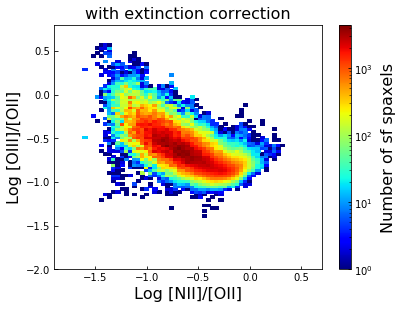

In [9]:
# wave = np.logspace(np.log10(910.), np.log10(30000.), 2000)
# flux = np.ones(1)


# y_wave = red_corr_calzetti00(wave,flux,2.86,ha_lam,hb_lam)
# 元素的波长设定
# ha_6564    hb_4862    nii_6585    oii_3727    oii_3729    oiii_5008    
ha_lam = 0.65645377
hb_lam = 0.48613615
nii_lam = 0.6585
oii7_lam = 0.3727
oii9_lam = 0.3729
oiii_lam = 0.5008

# 获取元素的flux
ha = spaxel_data[:,5].copy()
hb = spaxel_data[:,6].copy()
nii = spaxel_data[:,7].copy()
oiii = spaxel_data[:,8].copy()
oii9 = spaxel_data[:,9].copy()
oii7 = spaxel_data[:,10].copy()
#########################################################
# Hα/Hβ > 2.86 的才做消光修正操作
ha_hb = ha/hb
id_286 = np.where(ha_hb<2.86)
# 临时存储一下flux
tmp_ha = ha.copy()
tmp_hb = hb.copy()
tmp_nii = nii.copy()
tmp_oiii = oiii.copy()
tmp_oii9 = oii9.copy()
tmp_oii7 = oii7.copy()

# 开始消光修正
Rv=4.05
nii = calzetti00_dered(nii_lam,nii,ha_lam,hb_lam,ha,hb,Rv,unit='um')
oiii = calzetti00_dered(oiii_lam,oiii,ha_lam,hb_lam,ha,hb,Rv,unit='um')
oii9 = calzetti00_dered(oii9_lam,oii9,ha_lam,hb_lam,ha,hb,Rv,unit='um')
oii7 = calzetti00_dered(oii7_lam,oii7,ha_lam,hb_lam,ha,hb,Rv,unit='um')

#Hα/Hβ <= 2.86 的不做修正
ha[id_286] = tmp_ha[id_286]
hb[id_286] = tmp_hb[id_286]
nii[id_286] = tmp_nii[id_286]
oiii[id_286] = tmp_oiii[id_286]
oii9[id_286] = tmp_oii9[id_286]
oii7[id_286] = tmp_oii7[id_286]
# 消光修正完毕


# 计算元素的flux之比，并log
lg_oiii_oii = np.log10(oiii/(oii7+oii9))
lg_nii_oii = np.log10(nii/(oii7+oii9))

# 画图
y = lg_oiii_oii
x = lg_nii_oii

fig = plt.figure(figsize=(6,4.5))    # 设定图形大小
ax1 = fig.add_subplot(111)    # 设定子图，调整位置


# hist2d画图
xbins,ybins,hist,cax = ax1.hist2d(x,y,bins=(65,90),range=[[-1.9,0.7],[-2.,0.8]],cmap='jet',norm= mpl.colors.LogNorm(),vmin=1,vmax=(3500./526613.)*x.size) 
# ax1.set_aspect(1)
plt.xlabel('Log [NII]/[OII]',fontsize=16)    # x轴标签
plt.ylabel('Log [OIII]/[OII]',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# # colorbar调整
cbar = fig.colorbar(cax)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("Number of sf spaxels",fontsize=16,labelpad=8)
plt.title('with extinction correction',fontsize=16)
plt.show() 


In [10]:
spaxel_data.shape

(668418, 12)

In [11]:
x_no.shape

(45,)

# pyqz插值计算金属丰度

In [15]:
'''
进行外插：extrapolate
1.读取pyqz网格数据
2.使用1D外插反复操作2次进行2D外插
3.得到完整的金属丰度分布图

'''
'''
将grid进行外插
使用1D外插，分别进行多次，得到左右扩展0.3dex的grid
'''
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
# 读取pq_data的数据
qZ_xy = np.loadtxt("./tmp_storage/pyqz_grid.dat")
logq = qZ_xy[:,0]# value of ionization parameter Log(q)
Z = qZ_xy[:,1]# value of gas matellicity
x_no = qZ_xy[:,2]# value of [NII]/[OII]
y_oo = qZ_xy[:,3]# value of [OIII]/[OII]

# 取出待插值的原数据，9条横线
for i in range(9):
    # 分别给x轴和y轴赋值
    for xy in ['x','y','Z']:
        locals()['line'+str(i+1)+xy]=np.zeros(7)# 初始化数组
        # 竖线赋值
        for j in range(5):
            if xy=='x':
                locals()['line'+str(i+1)+xy][j+1] = x_no[i*5+j]
            elif xy=='y':
                locals()['line'+str(i+1)+xy][j+1] = y_oo[i*5+j]
            elif xy=='Z':
                locals()['line'+str(i+1)+xy][j+1] = Z[i*5+j]
# 竖线，5条
for i in range(5):
    # 分别给x轴和y轴赋值
    for xy in ['x','y']:
        locals()['line1'+str(i+1)+xy]=np.zeros(9)
        # 竖线赋值
        for j in range(9):
            if xy=='x':
                locals()['line1'+str(i+1)+xy][j] = x_no[i+5*j]
            elif xy=='y':
                locals()['line1'+str(i+1)+xy][j] = y_oo[i+5*j]
                
# 横线，2条
line16x = x_no[0:5]
line16y = y_oo[0:5]
line17x = x_no[40:45]
line17y = y_oo[40:45]

########################################
############# interpolate ##############
########################################
# 外插[Oiii]/[Oii]-[Nii]/[Oii]格点
for i in range(9)
    # 待插值的样本点
    x=locals()['line'+str(i+1)+'x']
    y=locals()['line'+str(i+1)+'y']
    # 用来插值的点，扩展0.3dex
    xnew = np.array([x[1]-0.3,x[5]+0.3])
    #plt.plot(x,y,"ro",label='sample')# 样本点画图
    kind ='linear'# 'cubic'# interpolation method 
    f=interpolate.interp1d(x[1:5],y[1:5],fill_value="extrapolate",kind=kind)# 使用插值函数
    ynew=f(xnew)# 得到插值结果
    # 将结果赋值给原数组
    x[0]=xnew[0]
    x[6]=xnew[1]
    y[0]=ynew[0]
    y[6]=ynew[1]

    # 外插金属丰度，沿着x方向 [Nii]/[Oii]
    z = locals()['line'+str(i+1)+'Z']
    # 用来插值的点，扩展0.3dex
    xnew = np.array([x[1]-0.3,x[5]+0.3])
    #pl.plot(x,y,"ro",label='sample')# 样本点画图
    kind ='linear'# 'cubic'# interpolation method 
    f=interpolate.interp1d(x[1:5],z[1:5],kind=kind,fill_value="extrapolate")# 使用插值函数
    znew=f(xnew)# 得到插值结果
    # 将结果赋值给原数组
    z[0]=znew[0]
    z[6]=znew[1]
############################################################################################
# for i in range(7):
#     xx=locals()['line'+str(i+1)+'x']
#     yy=locals()['line'+str(i+1)+'y']
#     plt.plot(xx,yy,'o-',color='black',markerfacecolor='white')
# plt.show()
'''
使用girddata函数进行内插
'''
# 初始化待插值数据点
xy_point = np.ones([7*9,2])*np.nan
z_value = np.ones(7*9)*np.nan
# 提取坐标和金属丰度
for i in range(9):
    xy_point[7*i:7*i+7,0] = locals()['line'+str(i+1)+'x']
    xy_point[7*i:7*i+7,1] = locals()['line'+str(i+1)+'y']
    z_value[7*i:7*i+7] = locals()['line'+str(i+1)+'Z']

# 元素的波长设定
# ha_6564    hb_4862    nii_6585    oii_3727    oii_3729    oiii_5008    
ha_lam = 0.65645377
hb_lam = 0.48613615
nii_lam = 0.6585
oii7_lam = 0.3727
oii9_lam = 0.3729
oiii_lam = 0.5008
# 获取元素的flux
ha = spaxel_data[:,5].copy()
hb = spaxel_data[:,6].copy()
nii = spaxel_data[:,7].copy()
oiii = spaxel_data[:,8].copy()
oii9 = spaxel_data[:,9].copy()
oii7 = spaxel_data[:,10].copy()
#########################################################
# Hα/Hβ > 2.86 的才做消光修正操作
ha_hb = ha/hb
id_286 = np.where(ha_hb<2.86)
# 临时存储一下flux
tmp_ha = ha.copy()
tmp_hb = hb.copy()
tmp_nii = nii.copy()
tmp_oiii = oiii.copy()
tmp_oii9 = oii9.copy()
tmp_oii7 = oii7.copy()

# 开始消光修正
Rv=4.05
nii = calzetti00_dered(nii_lam,nii,ha_lam,hb_lam,ha,hb,Rv,unit='um')
oiii = calzetti00_dered(oiii_lam,oiii,ha_lam,hb_lam,ha,hb,Rv,unit='um')
oii9 = calzetti00_dered(oii9_lam,oii9,ha_lam,hb_lam,ha,hb,Rv,unit='um')
oii7 = calzetti00_dered(oii7_lam,oii7,ha_lam,hb_lam,ha,hb,Rv,unit='um')

#Hα/Hβ <= 2.86 的不做修正
ha[id_286] = tmp_ha[id_286]
hb[id_286] = tmp_hb[id_286]
nii[id_286] = tmp_nii[id_286]
oiii[id_286] = tmp_oiii[id_286]
oii9[id_286] = tmp_oii9[id_286]
oii7[id_286] = tmp_oii7[id_286]
# 消光修正完毕
#######################################################################


# 计算元素的flux之比，并log
lg_oiii_oii = np.log10(oiii/(oii7+oii9))
lg_nii_oii = np.log10(nii/(oii7+oii9))

x = np.log10(nii/(oii7+oii9))
y = np.log10(oiii/(oii7+oii9))
new_xy = (x,y)
# new_xy = np.append(x,y).reshape(x.size,2).T

# 插值
points = xy_point
values = z_value
method = 'linear'
Znew = griddata(points=points, values=values,xi=new_xy, method=method, fill_value=np.nan, rescale=False)

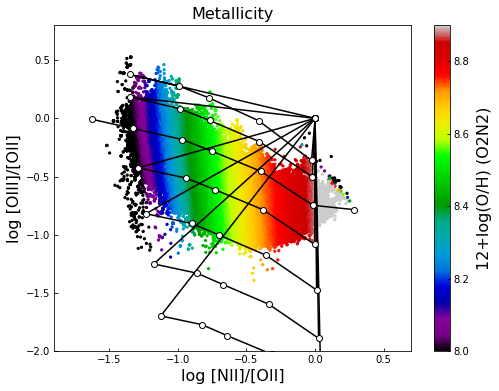

In [16]:
'''做出pyqz计算得到金属丰度的分布图
'''
# 金属丰度分布图.
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
# 设置colorbar颜色样式，可以在下面网站查询：
# https://matplotlib.org/tutorials/colors/colormaps.html
cm = plt.cm.get_cmap('nipy_spectral')
z = Znew
# 开始画散点图
sc = plt.scatter(x, y,c=z, vmin=8, vmax=8.9, s=5, cmap=cm)
# 开始画grid格子
for i in range(7):
    xx=locals()['line'+str(i+1)+'x']
    yy=locals()['line'+str(i+1)+'y']
    plt.plot(xx,yy,'o-',color='black',markerfacecolor='white')
# 坐标轴范围调整
plt.xlim(-1.9, 0.7)
plt.ylim(-2.0, 0.8)
# 坐标轴标题设置
plt.xlabel('log [NII]/[OII]',fontsize=16)    # x轴标签
plt.ylabel('log [OIII]/[OII]',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = plt.colorbar(sc)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("12+log(O/H) (O2N2)",fontsize=16,labelpad=8)
plt.title('Metallicity',fontsize=16)
plt.show()

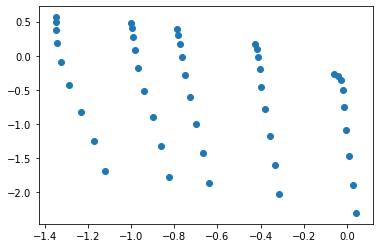

In [14]:
plt.scatter(x_no,y_oo)
plt.show()

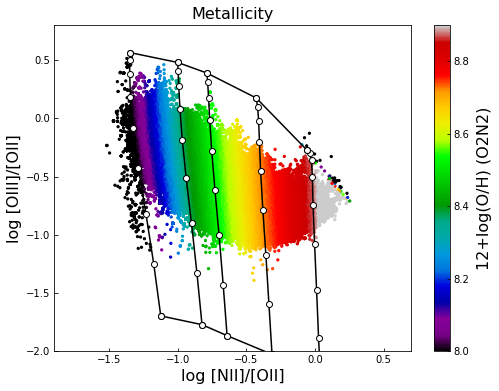

In [77]:
# 竖线，5条
for i in range(5):
    # 分别给x轴和y轴赋值
    for xy in ['x','y']:
        locals()['line'+str(i+1)+xy]=np.zeros(9)
        # 竖线赋值
        for j in range(9):
            if xy=='x':
                locals()['line'+str(i+1)+xy][j] = x_no[i+5*j]
            elif xy=='y':
                locals()['line'+str(i+1)+xy][j] = y_oo[i+5*j]
                
# 横线，2条
line6x = x_no[0:5]
line6y = y_oo[0:5]
line7x = x_no[40:45]
line7y = y_oo[40:45]

plt.figure(figsize=(8,6))
# 设置colorbar颜色样式，可以在下面网站查询：
# https://matplotlib.org/tutorials/colors/colormaps.html
cm = plt.cm.get_cmap('nipy_spectral')
z = Znew
# 开始画散点图
sc = plt.scatter(x, y,c=z, vmin=8, vmax=8.9, s=5, cmap=cm)

# 开始画grid格子
for i in range(7):
    xx=locals()['line'+str(i+1)+'x']
    yy=locals()['line'+str(i+1)+'y']
    #plt.errorbar(xx,yy,marker='o',color='orange',fillstyle='none',markerfacecolor='white')
    plt.plot(xx,yy,'o-',color='black',markerfacecolor='white')
# 坐标轴范围调整
plt.xlim(-1.9, 0.7)
plt.ylim(-2.0, 0.8)
# 坐标轴标题设置
plt.xlabel('log [NII]/[OII]',fontsize=16)    # x轴标签
plt.ylabel('log [OIII]/[OII]',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = plt.colorbar(sc)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("12+log(O/H) (O2N2)",fontsize=16,labelpad=8)
plt.title('Metallicity',fontsize=16)
plt.show()
# for i in range(9):
#     xx=locals()['line'+str(i+1)+'x']
#     yy=locals()['line'+str(i+1)+'y']
#     #plt.errorbar(xx,yy,marker='o',color='orange',fillstyle='none',markerfacecolor='white')
#     plt.plot(xx,yy,'o-',color='black',markerfacecolor='white')
# plt.show()

In [66]:
'''得到指定星系的金属丰度分布图'''

arr_id = copy(spaxel_data[:,0])  # 4675数组中位置
x2800 = copy(spaxel_data[:,1])  # 2800定位数组中的值

manga_Z = pd.read_pickle("./tmp_storage/MaNGA_Z.pd.pkl")
firefly_fits = fits.open('/mnt/ddnfs/data_users/yhwang/bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
plateifu = firefly_fits[1].data['PLATEIFU'][arr_id.astype(int)]
path_marvin_maps = '/mnt/ddnfs/data_users/yhwang/bak_la/root/bash_file/marvin_vor10_fits'#'/root/bash_file/manga_maps_data'
# path_marvin_maps = '/mnt/ddnfs/data_users/yhwang/bak_la/root/bash_file/manga_maps_data'
def _Zpyqz_plot(plifu,x2800):
    tmp_id = (plifu==plateifu)
    xx2800 = x2800[tmp_id].astype(int)
    Z = Znew[tmp_id]
    # 一维转二维   
    # 使用Marvin读取数据
    filename = join(path_marvin_maps, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(plifu))
    #filename = join(path_marvin_maps, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(plifu))
    maps = Maps(filename=filename)
    ha = maps.emline_gflux_ha_6564
    image_sz = np.shape(ha)[0]    # 图像边长
    # 2800数组转为二维正方形矩阵，导出 mask
    #read in the vac file
    tmp_iid = (plifu==firefly_fits[1].data['PLATEIFU'])
    binid = firefly_fits[5].data[tmp_iid,:,:][0]
    bin1d = firefly_fits[4].data[tmp_iid,:,0][0][xx2800]    # 获取一维的bin数据
    arr_2800 = Z
    # 画图
    image_sz = np.shape(ha)[0]    # 图像边长
    matrix = np.ones((image_sz,image_sz))*np.nan    # 初始化画图数组
    for i in range(image_sz):
        for j in range(image_sz):
            idbin = (bin1d==binid[i,j])    # 搜索二维bin的值在一维bin数组中的 位置
            if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
                matrix[i,j] = arr_2800[idbin]
    return matrix
# mass_density = [
#     firefly_fits[13].data[(firefly_fits[1].data['PLATEIFU']==plifu),x2800,0][0]\
#  for plifu,x2800 in zip(manga_Z['plate-ifu'],\
#                         manga_Z['bin_id_2800'])]

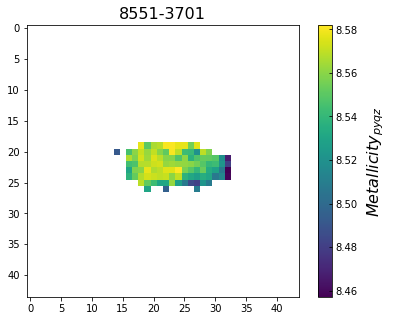

In [78]:
'''得到指定星系的金属丰度分布图'''

arr_id = copy(spaxel_data[:,0])  # 4675数组中位置
x2800 = copy(spaxel_data[:,1])  # 2800定位数组中的值

# manga_Z = pd.read_pickle("./tmp_storage/MaNGA_Z.pd.pkl")
# firefly_fits = fits.open('/mnt/ddnfs/data_users/yhwang/bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
plateifu = firefly_fits[1].data['PLATEIFU'][arr_id.astype(int)]
path_marvin_maps = '/mnt/ddnfs/data_users/yhwang/bak_la/root/bash_file/marvin_vor10_fits'#'/root/bash_file/manga_maps_data'
# path_marvin_maps = '/mnt/ddnfs/data_users/yhwang/bak_la/root/bash_file/manga_maps_data'
def _Zpyqz_plot(plifu,x2800):
    tmp_id = (plifu==plateifu)
    xx2800 = x2800[tmp_id].astype(int)
    Z = Znew[tmp_id]
    # 一维转二维   
    # 使用Marvin读取数据
    filename = join(path_marvin_maps, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(plifu))
    #filename = join(path_marvin_maps, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(plifu))
    maps = Maps(filename=filename)
    ha = maps.emline_gflux_ha_6564
    image_sz = np.shape(ha)[0]    # 图像边长
    # 2800数组转为二维正方形矩阵，导出 mask
    #read in the vac file
    tmp_iid = (plifu==firefly_fits[1].data['PLATEIFU'])
    binid = firefly_fits[5].data[tmp_iid,:,:][0]
    bin1d = firefly_fits[4].data[tmp_iid,:,0][0][xx2800]    # 获取一维的bin数据
    arr_2800 = Z
    # 画图
    image_sz = np.shape(ha)[0]    # 图像边长
    matrix = np.ones((image_sz,image_sz))*np.nan    # 初始化画图数组
    for i in range(image_sz):
        for j in range(image_sz):
            idbin = (bin1d==binid[i,j])    # 搜索二维bin的值在一维bin数组中的 位置
            if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
                matrix[i,j] = arr_2800[idbin]
    return matrix
#******************************************************************************************************************
plifu = '8551-3701'
x2800 = copy(spaxel_data[:,1])  # 2800定位数组中的值
mtx_plt = _Zpyqz_plot(plifu,x2800)
# 开始画图
fig, ax = plt.subplots(figsize=(7, 5))
# cm = plt.cm.get_cmap('rainbow')
sc = plt.imshow(mtx_plt)#,origin='lower',cmap=cm)#,vmin=-3,vmax=3)
# #sc = plt.imshow(mtx_plt,origin='lower',cmap=cm)
# fig.set_size_inches(7, 5)    # 调整大小
# plt.xlabel('spaxel',fontsize=16)    # x轴标签
# plt.ylabel('spaxel',fontsize=16)    # y轴标签
# plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = plt.colorbar(sc)
cbar.ax.tick_params(which='both',direction='in')
# cbar.set_label('$\Delta$log(O/H)/$\sigma_Z$',fontsize=16,labelpad=8)
cbar.set_label('$Metallicity_{pyqz}$',fontsize=16,labelpad=8)
plt.title(plifu,fontsize=16)
plt.show()

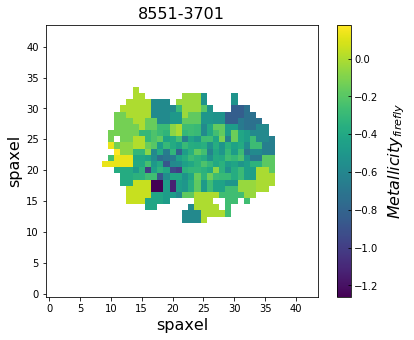

In [74]:
# 单个星系的金属丰度的分布
# using MaNGA firefly fits 
'''匹配1d和2d数组-画图
'''
MaNGA_plifu = plifu#'8252-9102'

from marvin.tools import Maps
# Marvin's fits.gz file Path and images path
# path_marvin_maps = '/mnt/ddnfs/data_users/yhwang/bak_la/root/bash_file/manga_maps_data'
# path_marvin_maps = '/mnt/ddnfs/data_users/yhwang/bak_la/root/bash_file/marvin_vor10_fits'
# path_image_data = '/mnt/ddnfs/data_users/yhwang/bak_la/root/cosmos/data/images'

filename = join(path_marvin_maps, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(plifu))
# filename = join(path_marvin_maps, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(plifu))
maps = Maps(filename=filename)
ha = maps.emline_gflux_ha_6564
# 获取 star forming 区域
masks, fig, axes = maps.get_bpt(show_plot=False)


#read in the vac file
# firefly_fits = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
galid = (firefly_fits[1].data['PLATEIFU']==MaNGA_plifu)
# tmp_id = (MaNGA_plaifu==firefly_fits[1].data['PLATEIFU'])
binid = copy(firefly_fits[5].data)
bin1d = copy(firefly_fits[4].data[galid,:,0][0])    # 获取一维的bin数据
surf_density = firefly_fits[8].data[galid,:,0][0]# 2800长度
# 画图
image_sz = np.shape(ha)[0]    # 图像边长
mapss = np.ones((image_sz,image_sz))*np.nan    # 初始化画图数组
for i in range(image_sz):
    for j in range(image_sz):
        idbin = (bin1d==binid[galid,i,j])    # 搜索二维bin的值在一维bin数组中的 位置
        if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
            mapss[i,j] = surf_density[idbin]

# 加mask
# masked_array = np.ma.array(mapss,mask=None)
masked_array = np.ma.array(mapss,mask=~masks['sf']['nii'])
# masked_array = mapss

fig, ax = plt.subplots(figsize=(7, 5))
p = ax.imshow(masked_array , origin='lower')#,vmin=5.5,vmax=8.5)
# plt.xlim(0,70)
# plt.ylim(0,70)
ax.set_xlabel('spaxel',fontsize=16)
ax.set_ylabel('spaxel',fontsize=16)
cb = fig.colorbar(p)
# cb.set_label(prop[0:len(prop)-8],fontsize=18,labelpad=10)
#plt.xlim((0,53))    # x轴坐标范围
#plt.ylim((0,53))    # y轴坐标范围
cb.ax.tick_params(which='both',direction='in')
cb.set_label('$Metallicity_{firefly}$',fontsize=16,labelpad=8)
plt.title(plifu,fontsize=16)
plt.show()






In [38]:
maps.get_bpt?

Signature:
maps.get_bpt(
    method='kewley06',
    snr_min=3,
    return_figure=True,
    show_plot=True,
    use_oi=True,
    **kwargs,
)
Docstring:
Returns the BPT diagram for this target.

This method produces the BPT diagram for this target using emission
line maps and returns a dictionary of classification masks, that can be
used to select spaxels that have been classified as belonging to a
certain excitation process. It also provides plotting functionalities.

Extensive documentation can be found in :ref:`marvin-bpt`.

Parameters:
    method ({'kewley06'}):
        The method used to determine the boundaries between different
        excitation mechanisms. Currently, the only available method is
        ``'kewley06'``, based on Kewley et al. (2006). Other methods
        may be added in the future. For a detailed explanation of the
        implementation of the method check the
        :ref:`BPT documentation <marvin-bpt>`.
    snr_min (float or dict):
        The signal-to-nois

In [228]:
plifu = '8945-12705'
tmp_iid = (plifu==firefly_fits[1].data['PLATEIFU'])
bin1d = firefly_fits[4].data[tmp_iid,:,:]
print(bin1d.shape)
print(bin1d)

(1, 2800, 4)
[[[ 1.3900000e+02  5.9904344e-03  1.4652000e-04  5.1720877e-04]
  [ 9.8000000e+01 -4.9400997e-01  1.4589773e-04  4.2639632e-02]
  [ 1.4200000e+02  5.9904344e-03 -4.9985388e-01  4.3147136e-02]
  ...
  [-9.9990000e+03 -9.9990000e+03 -9.9990000e+03 -9.9990000e+03]
  [-9.9990000e+03 -9.9990000e+03 -9.9990000e+03 -9.9990000e+03]
  [-9.9990000e+03 -9.9990000e+03 -9.9990000e+03 -9.9990000e+03]]]


In [25]:
#**************************************************************************************
''' 【并行版本】简单的修改，直接循环计算所有的spaxel的金属丰度预期值
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from copy import copy as copy
from os.path import join
from marvin.tools import Maps
import warnings
from multiprocessing import Pool
warnings.filterwarnings('ignore')    # 不显示warning信息

path_drpall = '/mnt/ddnfs/data_users/yhwang/bak_la/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits'
drpall = fits.open(path_drpall)
firefly_fits = fits.open('/mnt/ddnfs/data_users/yhwang/bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
manga_Z = pd.read_pickle("./tmp_storage/MaNGA_Z.pd.pkl")

def _stellar_mass(plateifu):
    mass = firefly_fits[1].data['PHOTOMETRIC_MASS'][(firefly_fits[1].data['PLATEIFU']==plateifu)][0]
    return mass

def _mass_density(plateifu,x2800):
    density = firefly_fits[13].data[(firefly_fits[1].data['PLATEIFU']==plateifu),x2800,0][0]
    return density


# 开始并行
pool = Pool(50)

stellar_mass = pool.map(_stellar_mass, manga_Z['plate-ifu'])

x = manga_Z['plate-ifu']
y =  manga_Z['bin_id_2800']
zip_args = list(zip(x, y))
mass_density = pool.starmap(_mass_density, zip_args)

pool.close()
pool.join()
#**************************************************************************************

AttributeError: '_ValidHDU' object has no attribute 'data'

In [12]:
# Firefly surface mass density * b/a 椭圆率修正
b = spaxel_data[:,4].copy()
b += np.log10(ba_add_orig[:,0])    # obs_density*b/a = inc_density 考虑椭圆率进行逆映射
b[np.isinf(b)] = np.nan
firefly_spaxel_density = b.copy()

# nan值无效值剔除
a = ~np.isnan(firefly_spaxel_density)
b = ~np.isnan(Znew)
# c = ~np.isnan(mass_spaxel)
cc = a&b
no_nan_value = cc
spaxel_data = spaxel_data[no_nan_value]
mass_spaxel = mass_spaxel[no_nan_value]
Znew = Znew[no_nan_value]
firefly_spaxel_density = firefly_spaxel_density[no_nan_value]
spaxel_density = spaxel_density[no_nan_value]

In [14]:
print(np.shape(mass_spaxel))
print(np.shape(spaxel_data))
print(np.shape(Znew))

(666098, 1)
(666098, 12)
(666098,)


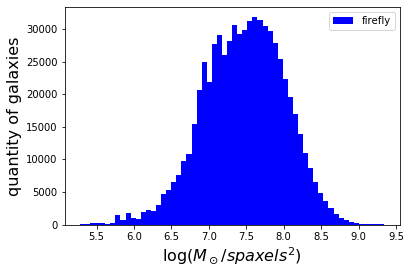

In [15]:
# 临时检查 firefly的density分布是否正常？？？
plt.hist(firefly_spaxel_density,bins=60,color='blue',label='firefly')[0:2]
plt.xlabel('log($M_\odot$/$spaxels^2$)',fontsize=16)
plt.ylabel('quantity of galaxies',fontsize=16)
plt.legend(loc='best')
plt.show()


## 金属丰度 - 表面密度 图

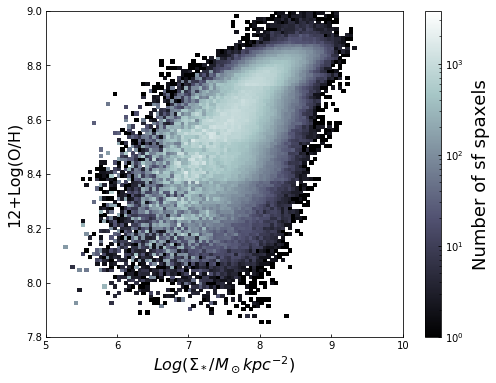

In [18]:
# 画图
y = Znew.copy()
# x = spaxel_density# PIPE3D surface mass density
x = firefly_spaxel_density


fig = plt.figure(figsize=(8,6))    # 设定图形大小
ax1 = fig.add_subplot(111)    # 设定子图，调整位置

# hist2d画图
xbins,ybins,hist,cax = ax1.hist2d(x,y,bins=(100,100),# 分组个数
                                  range=[[5,10],[7.8,9]],# 坐标轴范围
                                  cmap='bone',norm= mpl.colors.LogNorm(),vmin=1,vmax=3800)# colorbar样式
# ax1.set_aspect(1)    # 1：1图的大小
plt.xlabel('$Log(\Sigma_*/M_\odot kpc^{-2})$',fontsize=16)    # x轴标签
plt.ylabel('12+Log(O/H)',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = fig.colorbar(cax)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("Number of sf spaxels",fontsize=18,labelpad=8)
# plt.title('with intrinsic extinction correction',fontsize=16)
plt.show()


# # 金属丰度分布图
# plt.figure(figsize=(8,6))
# # 设置colorbar颜色样式，可以在下面网站查询：
# # https://matplotlib.org/tutorials/colors/colormaps.html
# cm = plt.cm.get_cmap('nipy_spectral')
# # 开始画散点图
# sc = plt.scatter(new_xy[0][no_nan_value], new_xy[1][no_nan_value],c=Znew, vmin=8, vmax=8.9, s=2, cmap=cm)
# # # 开始画grid格子
# # for i in range(7):
# #     xx=locals()['line'+str(i+1)+'x']
# #     yy=locals()['line'+str(i+1)+'y']
# #     plt.plot(xx,yy,'o-',color='black',markerfacecolor='white')
# # 坐标轴范围调整
# plt.xlim(-1.9, 0.7)
# plt.ylim(-2.0, 0.8)
# # 坐标轴标题设置
# plt.xlabel('Log [Nii]/[Oii]',fontsize=16)    # x轴标签
# plt.ylabel('Log [Oiii]/[Oii]',fontsize=16)    # y轴标签
# plt.tick_params(which='both',direction='in')
# # colorbar调整
# cbar = plt.colorbar(sc)
# cbar.ax.tick_params(which='both',direction='in')
# cbar.set_label("12+log(O/H)O2N2",fontsize=18,labelpad=8)
# plt.title('Metallicity',fontsize=16)
# plt.show()

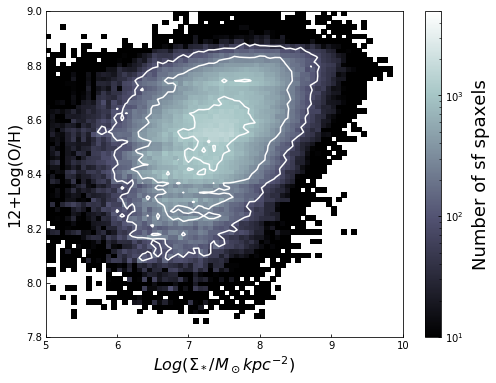

In [19]:
# 加入等高线 contour

y = Znew.copy()
x = spaxel_density.copy()# PIPE3D surface mass density
# x = firefly_spaxel_density.copy()# firefly surface mass density
fig = plt.figure(figsize=(8,6))    # 设定图形大小
ax1 = fig.add_subplot(111)    # 设定子图，调整位置

# hist2d画图
nhist,xbins,ybins,cax = ax1.hist2d(x,y,bins=(70,70),# 分组个数
                                  range=[[5,10],[7.8,9]],# 坐标轴范围
                                  cmap='bone',norm= mpl.colors.LogNorm(),vmin=10**1,vmax=10**3.7)# colorbar样式

plt.contour(xbins[1:],ybins[1:],nhist.transpose(),[10**2,10**2.5,10**3],colors='white',norm= mpl.colors.LogNorm(),linewidth=0.5,vmin=1,vmax=3800)
# ax1.set_aspect(1)    # 1：1图的大小
plt.xlabel('$Log(\Sigma_*/M_\odot kpc^{-2})$',fontsize=16)    # x轴标签
plt.ylabel('12+Log(O/H)',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = fig.colorbar(cax)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("Number of sf spaxels",fontsize=18,labelpad=8)
# plt.title('with intrinsic extinction correction',fontsize=16)
plt.show()


In [20]:
print(np.shape(Znew))

(666098,)


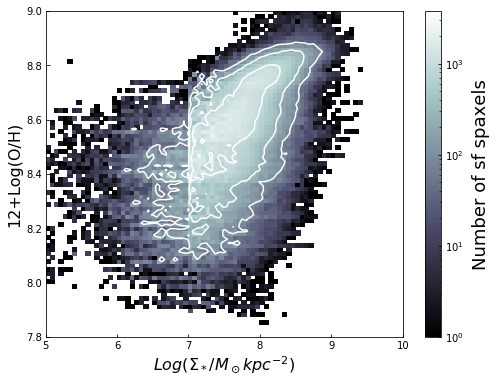

In [46]:
# 测试！！！！！
# 已失败
# 尝试结合 firefly和PIPE3D 的surface mass density
# density<7 --> PIPE3D
# density>=7 --> firefly
den_3d = spaxel_density.copy()
den_fly = firefly_spaxel_density.copy()
com_den = np.ones([den_3d.size,1])*np.nan
idcomdensity = den_fly<7
com_den[np.where(idcomdensity==True)[0],0] = den_3d[idcomdensity]
com_den[np.where(idcomdensity==False)[0],0] = den_fly[~idcomdensity]

# 加入等高线 contour
fig = plt.figure(figsize=(8,6))    # 设定图形大小
ax1 = fig.add_subplot(111)    # 设定子图，调整位置

# hist2d画图
x = com_den[:,0]
nhist,xbins,ybins,cax = ax1.hist2d(x,y,bins=(80,80),# 分组个数
                                  range=[[5,10],[7.8,9]],# 坐标轴范围
                                  cmap='bone',norm= mpl.colors.LogNorm(),vmin=1,vmax=3800)# colorbar样式

plt.contour(xbins[1:],ybins[1:],nhist.transpose(),[10**2,10**2.5,10**3],colors='white',norm= mpl.colors.LogNorm(),linewidth=0.5,vmin=1,vmax=3800)
# ax1.set_aspect(1)    # 1：1图的大小
plt.xlabel('$Log(\Sigma_*/M_\odot kpc^{-2})$',fontsize=16)    # x轴标签
plt.ylabel('12+Log(O/H)',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = fig.colorbar(cax)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("Number of sf spaxels",fontsize=18,labelpad=8)
# plt.title('with intrinsic extinction correction',fontsize=16)
plt.show()



# 预期金属丰度

## 金属丰度正态分布拟合

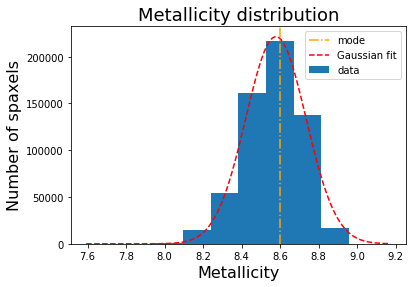

a =  221352.93644053568 
mean Metallicity =  8.578479738415199 
sigma =  0.15651564140864418


In [13]:
# 全部 >10^9Msun 的spaxel的金属丰度分布拟合 
# 高斯分布的拟合
######################################################
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy import stats
import numpy as np

# 质量筛选：stellar mass>10^9 Msun
cc = np.where(mass_spaxel>math.pow(10,9))
mass_sel = cc[0]
tmp_Znew = Znew[mass_sel]
# 金属丰度分布
hist,bins,__ = plt.hist(tmp_Znew,bins=10,label='data')
# 预期金属丰度
expcted_Z = (bins[np.where(hist==np.max(hist))]+(bins[1]-bins[0])/2)[0]
num_Z = hist[np.where(hist==np.max(hist))][0]
plt.axvline(expcted_Z,color='orange',linestyle='-.',label='mode');

x = bins[1:]-(bins[1]-bins[0])/2
y = hist

n = len(x)                          #the number of data
mean = sum(x)/n                   #note this correction
sigma = (sum((x-mean)**2)/n)**0.5        #note this correction
# a = np.max(y)

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])
# popt,pcov = curve_fit(gaus,x,y,p0=None)

# plt.plot(x,y,'b+:',label='data')
xmin,xmax = plt.xlim()
newx = np.linspace(xmin,xmax,1000)
plt.plot(newx,gaus(newx,*popt),'r--',label='Gaussian fit')
plt.legend(loc='best')
plt.title('Metallicity distribution',fontsize=18)
plt.xlabel('Metallicity',fontsize=16)
plt.ylabel('Number of spaxels',fontsize=16)
plt.show()

print('a = ',popt[0],
     '\nmean Metallicity = ',popt[1],
     '\nsigma = ',popt[2])

In [346]:
stats.norm.cdf(0, loc=0, scale=1)

0.5

In [17]:
Znew.shape

(666098,)

## 金属丰度偏态分布拟合

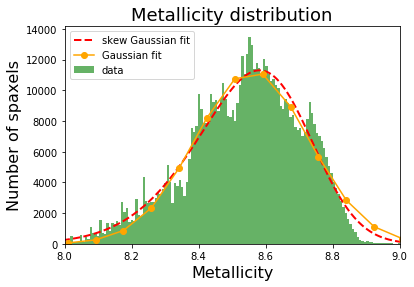

In [21]:
# 全部 >10^9Msun 的spaxel的金属丰度分布拟合 
# 偏态分布【倾斜版高斯分布】的拟合
######################################################
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy import asarray as ar,exp
from scipy.optimize import curve_fit

# 一般高斯函数
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))
# 加强版高斯函数【plus=0就是一般高斯函数】
def gua_plus(x,a,x0,sigma,plus):
    #norm = a/sigma*exp(-(x-x0)**2/(2*sigma**2))
    #cdf = stats.norm.cdf(plus*x, loc=x0, scale=sigma)
    #cdf = stats.norm.cdf(plus*(x-x0)/sigma, loc=0, scale=1)
    #return 2*norm*cdf
    result = a*stats.skewnorm.pdf((x-x0)/sigma, plus)
    return result

# spaxels筛选
sel_density = firefly_spaxel_density.copy()
cc = np.where(mass_spaxel>math.pow(10,8.5))[0]# 挑选出星系质量>10^9Msun 的spaxels
sel_density = sel_density[cc]
tmp_Znew = Znew[cc].copy()
dd = np.where(sel_density>0)[0]# 挑选出surface mass density>10^7的spaxels
tmp_Znew = Znew[dd]
# 生成一个符合skewnorm分布的随机数组
# tmp_Znew = stats.skewnorm.rvs(-10,loc=10, size=1000)

# 金属丰度分布画图
hist,bins,__ = plt.hist(tmp_Znew,bins=200, alpha=0.6, color='g',label='data')
xmin, xmax = plt.xlim()
# plt.show()

# 定义直方图中的各个点的坐标
x = (bins[1:]-(bins[1]-bins[0])/2).copy()
y = hist.copy()

n = len(x)# 拟合数据长度
mean = sum(x)/n# 平均数
sigma = (sum((x-mean)**2)/n)**0.5# 标准差
ymax = np.max(y)# y轴最大值，即拟合函数的幅度[高度]大小

# 开始拟合！！！
popt,pcov = curve_fit(gua_plus,x,y,p0=[ymax,mean,sigma,-3])
popt0,pcov0 = curve_fit(gaus,x,y,p0=[ymax,mean,sigma])

# 拟合曲线画图
newx = np.linspace(xmin,xmax,200)
newx0 = np.linspace(xmin,xmax,20)
# plt.show()
plt.plot(newx,gua_plus(newx,*popt), 'r--', linewidth=2,label='skew Gaussian fit')
# plt.show()
plt.plot(newx0,gaus(newx0,*popt0),'o-',color='orange',label='Gaussian fit')


plt.legend(loc='best')
plt.title('Metallicity distribution',fontsize=18)
plt.xlabel('Metallicity',fontsize=16)
plt.ylabel('Number of spaxels',fontsize=16)
plt.xlim([8,9])
plt.show()

# plt.plot(newx,gua_plus(newx,*popt), 'r--', linewidth=2,label='better fit')
# plt.legend(loc='best')
# plt.title('Metallicity distribution',fontsize=18)
# plt.xlabel('Metallicity',fontsize=16)
# plt.ylabel('Number of spaxels',fontsize=16)
# plt.show()

# plt.plot(x,y, 'o', linewidth=2,label='better fit')
# plt.legend(loc='best')
# plt.title('Metallicity distribution',fontsize=18)
# plt.xlabel('Metallicity',fontsize=16)
# plt.ylabel('Number of spaxels',fontsize=16)
# plt.show()


# print('gaus parameter = ',popt0,
#      '\nskewed gaus = ',popt)

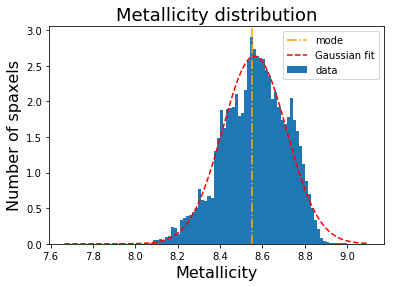

In [43]:
# 此拟合有问题，纵坐标不正确！！！

# 全部spaxel的金属丰度的分布
# 使用高斯分布拟合
# 高斯分布和原数据的差值
from scipy.stats import norm 
import matplotlib.mlab as mlab

# 挑选出星系质量>10^9Msun 的spaxels
cc = np.where(mass_spaxel>math.pow(10,9))
mass_sel = cc[0]
tmp_spaxel_data = spaxel_data[mass_sel]
tmp_mass_spaxel = mass_spaxel[mass_sel]
tmp_Znew = Znew[mass_sel]
tmp_firefly_spaxel_density = spaxel_density[mass_sel]#firefly_spaxel_density[mass_sel]

# 金属丰度分布
hist,bins,__ = plt.hist(tmp_Znew,bins=100,label='data',normed=1)#,normed=1


# 预期金属丰度
expcted_Z = (bins[np.where(hist==np.max(hist))]+(bins[1]-bins[0])/2)[0]
num_Z = hist[np.where(hist==np.max(hist))][0]
plt.axvline(expcted_Z,color='orange',linestyle='-.',label='mode');

# 高斯分布
mu =np.mean(tmp_Znew) #计算均值 
sigma =np.std(tmp_Znew)
y = mlab.normpdf(bins, mu, sigma)#拟合一条最佳正态分布曲线y 
plt.plot(bins, y, 'r--',label='Gaussian fit') #绘制y的曲线
plt.legend(loc='best')
plt.title('Metallicity distribution',fontsize=18)
plt.xlabel('Metallicity',fontsize=16)
plt.ylabel('Number of spaxels',fontsize=16)
plt.show()


In [22]:
mass_spaxel.shape

(666098, 1)

In [23]:
Znew.shape

(666098,)

### 正式偏态分布拟合全部

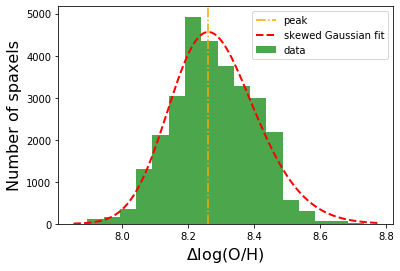

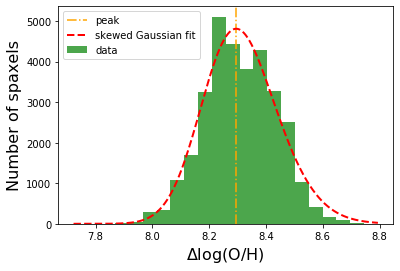

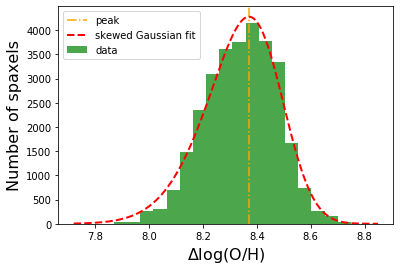

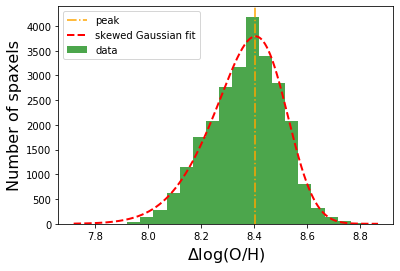

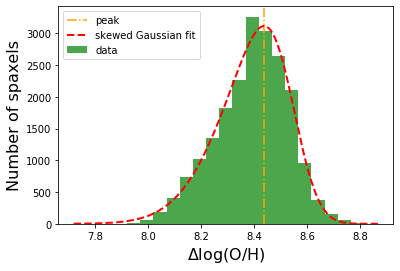

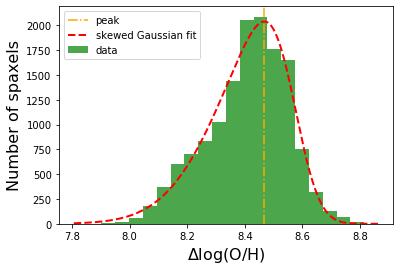

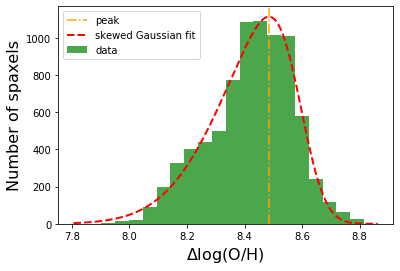

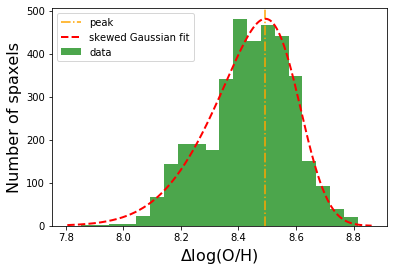

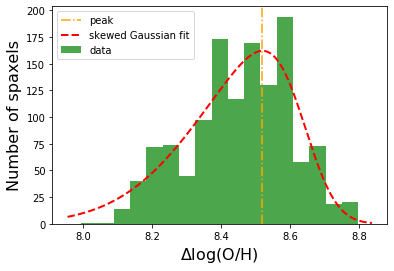

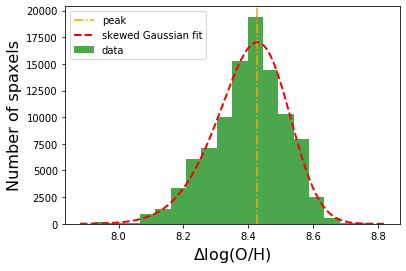

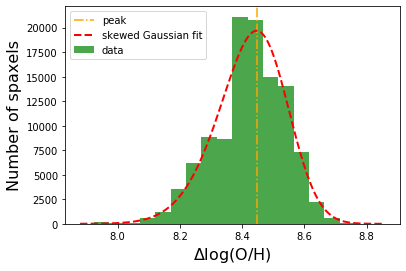

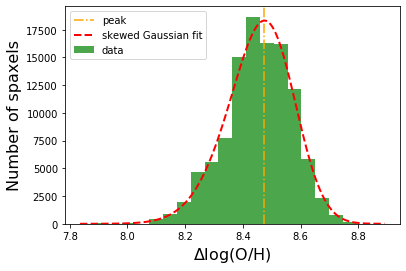

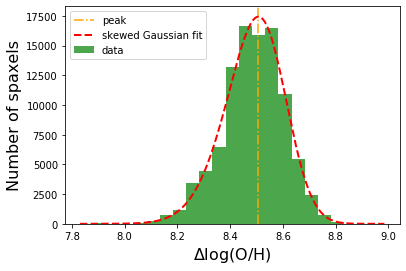

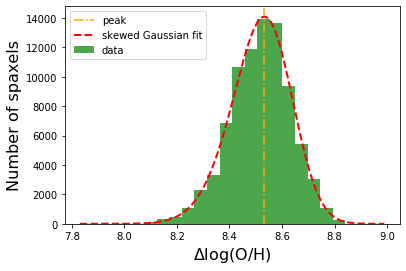

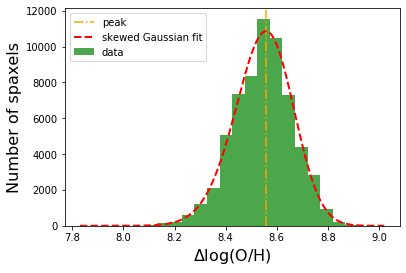

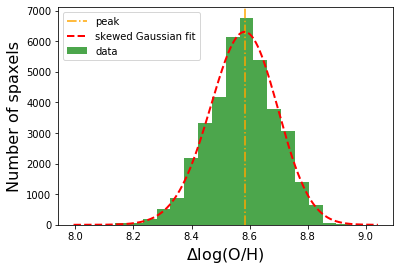

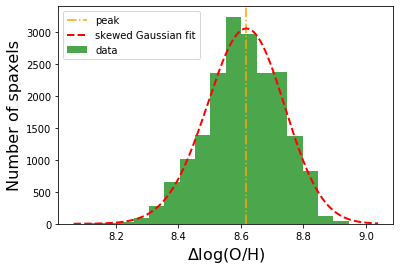

修正成功！！ modeZ =  8.58267832779852


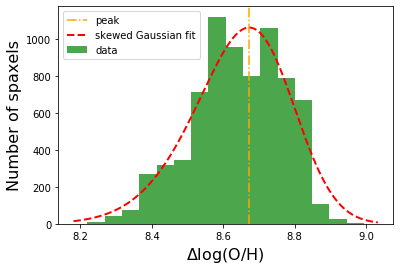

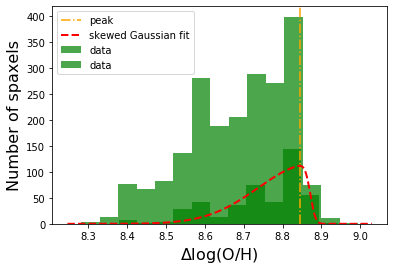

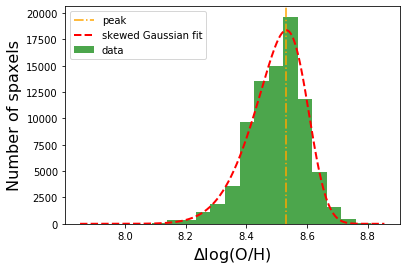

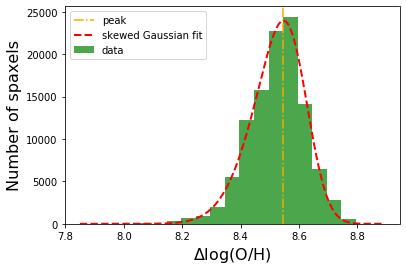

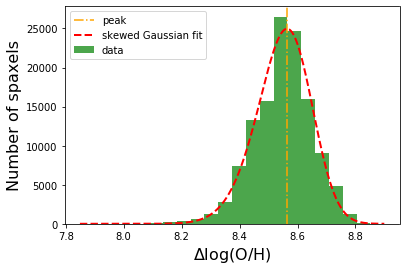

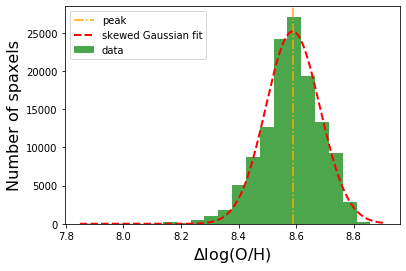

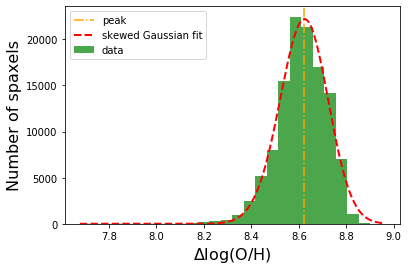

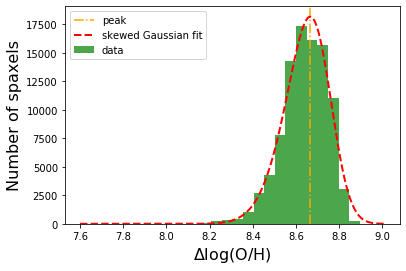

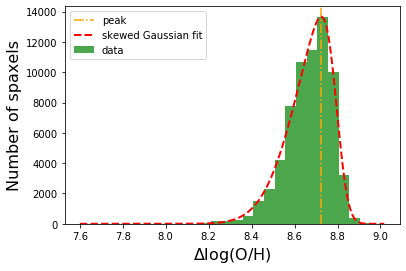

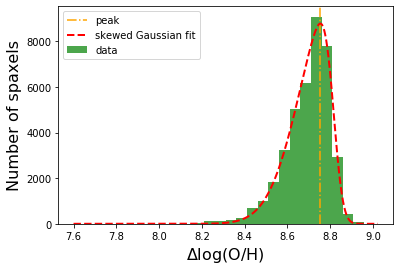

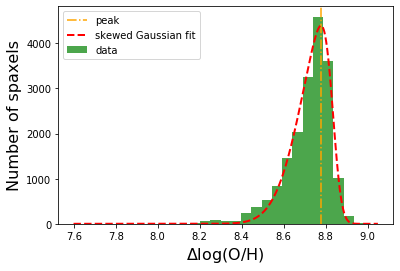

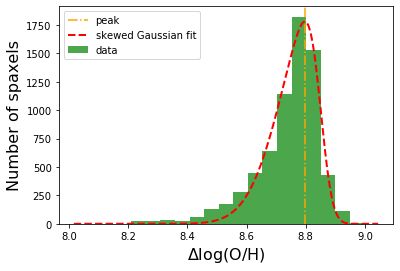

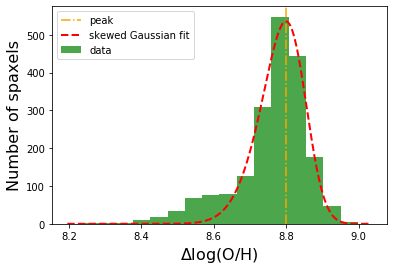

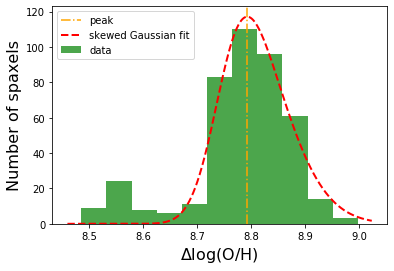

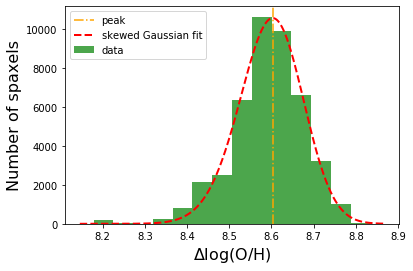

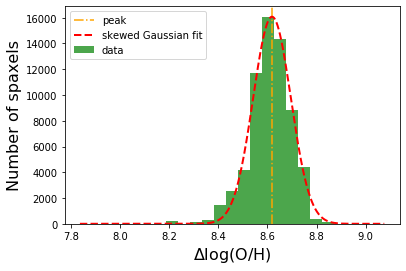

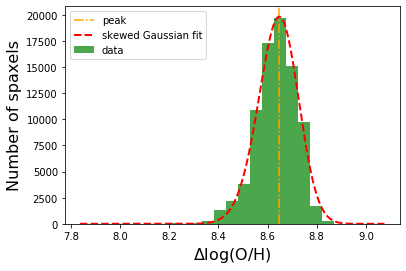

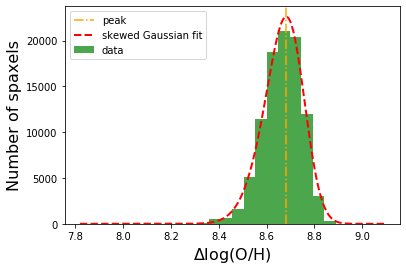

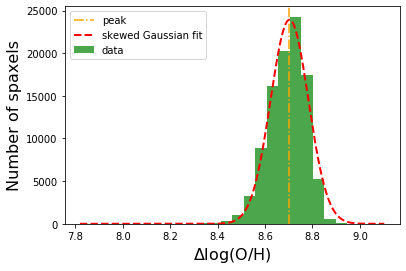

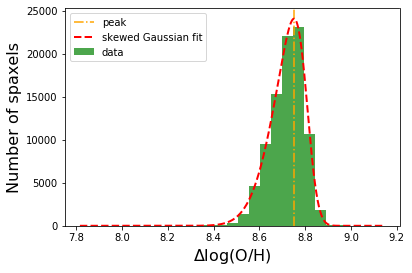

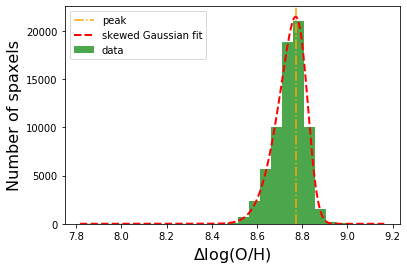

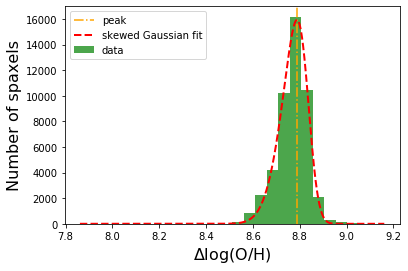

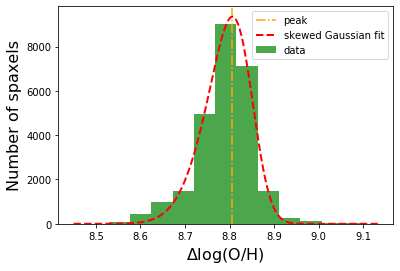

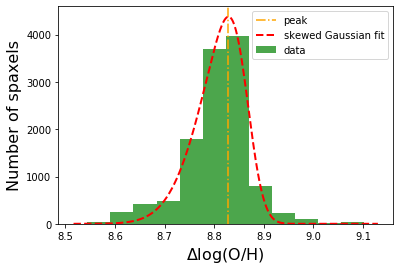

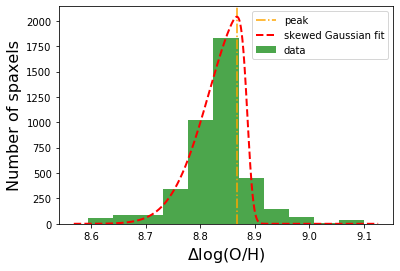

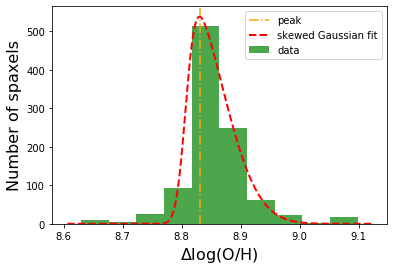

In [24]:
'''
mass_spaxel    # 每个spaxel所在的星系质量stellar mass
firefly_spaxel_density     # 每个spaxel的质量密度
Znew    # 每个spaxel的金属丰度
得到的最终结果为：expeted_data
    第一列：surface mass density
    第二列：metallicity mode
'''
#import matplotlib.mlab as mlab
# 高斯分布【正态分布】
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

# 偏态分布【plus=0就是正态分布】
def gaus_plus(x,a,x0,sigma,plus):
    fit_result = a*stats.skewnorm.pdf((x-x0)/sigma, plus)
    return fit_result

# 选择样本种类 Firefly或者PIPE3D
data_style = 'Firefly'# 'Firefly' #'PIPE3D'

# 按照 星系质量stellar mass分组
# 8.5-9，9-9.5，9.5-10，10-12
range_mass = np.array([[8.5,9],[9,9.5],[9.5,10],[10,12]])
# 初始化 预期金属丰度的数据点
expeted_data = np.ones([20*4,2])*np.nan
i_mass = 0
# j_density = 0
for i in range_mass:
    idspaxel = (mass_spaxel>=math.pow(10,i[0]))&(mass_spaxel<math.pow(10,i[1]))
    # surface mass density选择：firefly或者PIPE3D
    # spaxel_density[idspaxel[:,0]]#firefly_spaxel_density[idspaxel[:,0]]
    if data_style=='Firefly':
        tmp_density = (firefly_spaxel_density[idspaxel[:,0]]).copy()
    elif data_style=='PIPE3D':
        tmp_density = (spaxel_density[idspaxel[:,0]]).copy()
    else:
        raise ValueError("is data from Firefly or PIPE3D ???")
    
    tmp_Z = Znew[idspaxel[:,0]]
    j_density=0
    for j in np.arange(7,np.max(tmp_density[~np.isnan(tmp_density)]),0.2):#9.5,0.2):
        iddensity = (tmp_density>=j-0.4)&(tmp_density<=j+0.4)
        fix_density = tmp_density[iddensity]
        fix_Z = tmp_Z[iddensity]
        #if fix_Z.size==0:
            #j_density+=1
            #continue
        # 金属丰度分布
        #hist,bins,__ = plt.hist(tmp_Znew,bins=100,label='data',normed=1)#,normed=1
        hist,bins,__ = plt.hist(fix_Z,bins=int(((np.max(fix_Z)-np.min(fix_Z))/0.05)+1),alpha=0.7, color='g',label='data');
        #hist,bins = np.histogram(fix_Z,bins=int((np.max(fix_Z)-np.min(fix_Z))/0.03+1));
        if len(hist)==1:
            j_density+=1
            continue
        # 预期金属丰度
        #modeZ = (bins[np.where(hist==np.max(hist))]+(bins[1]-bins[0])/2)[0]
        #expeted_data[i_mass*20+j_density,0] = j
        #expeted_data[i_mass*20+j_density,1] = expcted_Z
        #num_Z = hist[np.where(hist==np.max(hist))][0]
        #plt.axvline(expcted_Z,color='orange',linestyle='-.',label='mode');
        
        # 高斯分布拟合
        #mu =np.mean(fix_Z) #计算均值 
        #sigma =np.std(fix_Z)
        #y = mlab.normpdf(bins, mu, sigma)#拟合一条最佳正态分布曲线y 
        #plt.plot(bins, y, 'r--',label='Gaussian fit') #绘制y的曲线
        #plt.legend(loc='best')
        #plt.title('Metallicity distribution',fontsize=18)
        #plt.xlabel('Metallicity',fontsize=16)
        #plt.ylabel('Number of spaxels',fontsize=16)
        #plt.show()
        
        x = bins[1:]-(bins[1]-bins[0])/2
        y = hist
        # 去除无用数据
        x = x[np.where(y!=0)]
        y = y[np.where(y!=0)]
        x = x[np.where(y!=1)]
        y = y[np.where(y!=1)]
        n = len(x)                          #the number of data
        mean = sum(x)/n                   #note this correction
        sigma = (sum((x-mean)**2)/n)**0.5        #note this correction
        
        a = np.max(y)
        #popt,pcov = curve_fit(gaus_plus,x,y,p0=[a,mean,sigma,0])
        try:
            popt,pcov = curve_fit(gaus_plus,x,y,p0=[a,mean,sigma,0])
            
        except:
            j_density+=1
            continue
            pass
        
        
        #popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])
        # popt,pcov = curve_fit(gaus,x,y)
        # plt.plot(x,y,'b+:',label='data')
        xmin,xmax = plt.xlim()
        newxx = np.linspace(xmin,xmax,10000)
        newx = np.linspace(xmin,xmax,5000)
        # 预期金属丰度，skewed Gaussian fit中的peak值
        newy = gaus_plus(newx,*popt)
        newyy = gaus_plus(newxx,*popt)
        expcted_Z = newx[np.where(newy==newy.max())[0]][0]
        # 存储expected metallicity
        expeted_data[i_mass*20+j_density,0] = j
        expeted_data[i_mass*20+j_density,1] = expcted_Z
        # 修正绿色的点
        if (8.5<j<8.7)&(data_style=='Firefly')&(i==np.array([ 9.0,9.5 ])).all():
            modeZ = (bins[np.where(hist==np.max(hist))]+(bins[1]-bins[0])/2)[0]
            expeted_data[i_mass*20+j_density,1] = modeZ
            print('修正成功！！ modeZ = ',modeZ)
        plt.axvline(expcted_Z,color='orange',linestyle='-.',label='peak');
        newxxx = (newxx - expeted_data[i_mass*20+j_density,1]).copy()
        #plt.show()
        plt.plot(newxx,newyy, 'r--', linewidth=2,label='skewed Gaussian fit')
        
        # 检查错误
        #print('stellar mass range = ',i,'\nsurface mass density = ',j,'\nexpected metallicity = ',expcted_Z,)
        #print('x = ',list(x))
        #print('y = ',list(y))
        #plt.plot(newx,gaus(newx,*popt),'r--',label='Gaussian fit')
        #plt.plot(x,gaus(x,*popt),'ro:',label='Gaussian fit')
        
        # 画图调整
        plt.legend(loc='best')
        ##plt.title('Metallicity distribution',fontsize=18)
        #plt.xlabel('Metallicity',fontsize=16)
        plt.xlabel('$\Delta$log(O/H)',fontsize=16)
        plt.ylabel('Number of spaxels',fontsize=16)
        #plt.xlim([-0.5,0.5])
        plt.show()
        # np.histogram
        j_density+=1
    i_mass+=1
# plt.xlim([-0.5,0.5])
# plt.xlim([8,9])
# plt.show()

# # expected metallicity plot
# kind = 'linear'#'linear'# 'cubic'# interpolation method 
# a = expeted_data[::-1].copy()# 倒序排列数组
# i = 0# 循环计数
# plt.figure(figsize=(6.5,6))
# for_list = np.array([['yellow','green','red','brown'],['8.5-9.0','9.0-9.5','9.5-10.0','10.0-12.0']],dtype=str)
# for_list = for_list.transpose()[::-1]
# for c,label in for_list:
#     x = a[20*i:20*i+20,0]
#     y = a[20*i:20*i+20,1]
    
#     #pl.plot(x,y,"ro",label='sample')# 样本点画图
#     f=interpolate.interp1d(x[~np.isnan(x)],y[~np.isnan(y)],fill_value="extrapolate",kind=kind)# 使用插值函数
#     xnew = np.linspace(7,x[~np.isnan(x)].max(),50)
#     ynew=f(xnew)# 得到插值结果
#     plt.plot(xnew,ynew,'--',color='black')#,bandwidth=0.2)
#     plt.plot(x,y,'o',color=c,label=label)
#     i+=1



# plt.title("Expected matallicity",fontsize=16)
# plt.xlabel('$Log(\Sigma_*/M_\odot kpc^{-2})$',fontsize=16)    # x轴标签
# plt.ylabel('12+Log(O/H)',fontsize=16)    # y轴标签
# plt.tick_params(which='both',direction='in')
# plt.legend(loc='lower right',title='$log(M_*/M_\odot)$')
# plt.xlim([6,10.5])
# plt.ylim([7.8,9])
# plt.show()

In [23]:
lala_num

666098

### 金属丰度质量分组中的peak

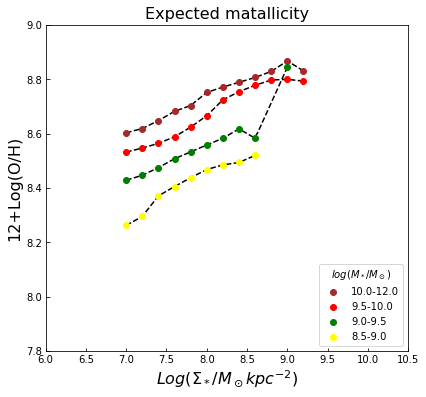

In [25]:
# expected metallicity plot
kind = 'linear'#'linear'# 'cubic'# interpolation method 
a = expeted_data[::-1].copy()# 倒序排列数组
i = 0# 循环计数
plt.figure(figsize=(6.5,6))
for_list = np.array([['yellow','green','red','brown'],['8.5-9.0','9.0-9.5','9.5-10.0','10.0-12.0']],dtype=str)
for_list = for_list.transpose()[::-1]
for c,label in for_list:
    x = a[20*i:20*i+20,0]
    y = a[20*i:20*i+20,1]
    
    #pl.plot(x,y,"ro",label='sample')# 样本点画图
    f=interpolate.interp1d(x[~np.isnan(x)],y[~np.isnan(y)],fill_value="extrapolate",kind=kind)# 使用插值函数
    xnew = np.linspace(7,x[~np.isnan(x)].max(),50)
    ynew=f(xnew)# 得到插值结果
    plt.plot(xnew,ynew,'--',color='black')#,bandwidth=0.2)
    plt.plot(x,y,'o',color=c,label=label)
    i+=1



plt.title("Expected matallicity",fontsize=16)
plt.xlabel('$Log(\Sigma_*/M_\odot kpc^{-2})$',fontsize=16)    # x轴标签
plt.ylabel('12+Log(O/H)',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
plt.legend(loc='lower right',title='$log(M_*/M_\odot)$')
plt.xlim([6,10.5])
plt.ylim([7.8,9])
plt.show()

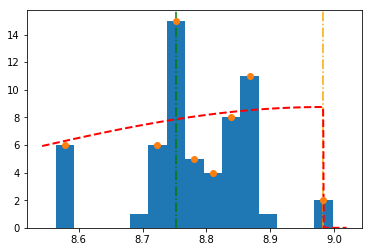

In [439]:
x =  [8.578817191820022, 8.72339847732998, 8.752314734431973, 8.781230991533967, 8.810147248635957, 8.83906350573795, 8.86797976283994, 8.983644791247908]
y =  [6.0, 6.0, 15.0, 5.0, 4.0, 8.0, 11.0, 2.0]
i = np.array([ 9.5,10. ])
j = 9.2
x = np.array(x)
y = np.array(y)
x = x[np.where(y!=0)]
y = y[np.where(y!=0)]
# x = x[np.where(y!=1)]
# y = y[np.where(y!=1)]
# y[np.where(y==0)]=np.nan
# plt.plot(x,y,'o')
def gaus_plus(x,a,x0,sigma,plus):
    fit_result = a*stats.skewnorm.pdf((x-x0)/sigma, plus)
    return fit_result

idspaxel = (mass_spaxel>=math.pow(10,i[0]))&(mass_spaxel<math.pow(10,i[1]))
iddensity = (tmp_density>=j-0.2)&(tmp_density<=j+0.2)
# surface mass density选择：firefly或者PIPE3D
# spaxel_density[idspaxel[:,0]]#firefly_spaxel_density[idspaxel[:,0]]
tmp_density = (firefly_spaxel_density[idspaxel[:,0]]).copy()
tmp_Z = Znew[idspaxel[:,0]]
iddensity = (tmp_density>=j-0.2)&(tmp_density<=j+0.2)
fix_density = tmp_density[iddensity]
fix_Z = tmp_Z[iddensity]
hist,bins,__ = plt.hist(fix_Z,bins=int((np.max(fix_Z)-np.min(fix_Z))/0.03+1),label='data')

modeZ = (bins[np.where(hist==np.max(hist))]+(bins[1]-bins[0])/2)[0]
n = len(x)                          #the number of data
mean = sum(x)/n                   #note this correction
sigma = (sum((x-mean)**2)/n)**0.5        #note this correction

a = np.max(y)
popt,pcov = curve_fit(gaus_plus,x,y,p0=[a,mean,sigma,0])
xmin,xmax = plt.xlim()
newx = np.linspace(xmin,xmax,1000)

# 预期金属丰度，skewed Gaussian fit中的peak值
newy = gaus_plus(newx,*popt)
expcted_Z = newx[np.where(newy==newy.max())[0]][0]
plt.axvline(expcted_Z,color='orange',linestyle='-.',label='peak')
plt.axvline(modeZ,color='green',linestyle='-.',label='mode')
plt.plot(newx,newy, 'r--', linewidth=2,label='better fit')
plt.plot(x,y,'o')
plt.show()

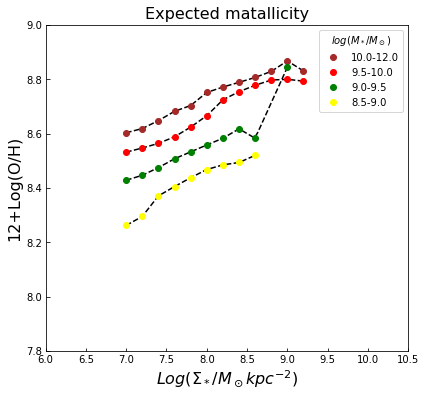

In [26]:
from scipy import interpolate


# xnew = np.linspace(7,9)
kind = 'linear'#'linear'# 'cubic'# interpolation method 

a = expeted_data[::-1]
i = 0
plt.figure(figsize=(6.5,6))
for_list = np.array([['yellow','green','red','brown'],['8.5-9.0','9.0-9.5','9.5-10.0','10.0-12.0']],dtype=str)
for_list = for_list.transpose()[::-1]
for c,label in for_list:
    x = a[20*i:20*i+20,0]
    y = a[20*i:20*i+20,1]
    
    #pl.plot(x,y,"ro",label='sample')# 样本点画图
    f=interpolate.interp1d(x[~np.isnan(x)],y[~np.isnan(y)],fill_value="extrapolate",kind=kind)# 使用插值函数
    xnew = np.linspace(7,x[~np.isnan(x)].max(),50)
    ynew=f(xnew)# 得到插值结果
    plt.plot(xnew,ynew,'--',color='black')#,bandwidth=0.2)
    plt.plot(x,y,'o',color=c,label=label)
    i+=1



plt.title("Expected matallicity",fontsize=16)
plt.xlabel('$Log(\Sigma_*/M_\odot kpc^{-2})$',fontsize=16)    # x轴标签
plt.ylabel('12+Log(O/H)',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
plt.legend(loc='best',title='$log(M_*/M_\odot)$')#loc='lower right'
plt.xlim([6,10.5])
plt.ylim([7.8,9])
plt.show()

### $Z$ - $\Sigma_*/M_\odot$ and $Z_{peak}$

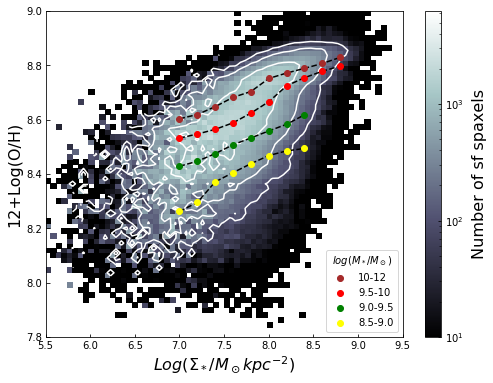

In [27]:
y = Znew.copy()
if data_style=='Firefly':
    x = firefly_spaxel_density.copy()# firefly surface mass density
elif data_style=='PIPE3D':
    x = spaxel_density.copy()
else:
    raise DataError("is data from Firefly or PIPE3D ???")
# x = spaxel_density.copy()# PIPE3D surface mass density
# x = firefly_spaxel_density.copy()# firefly surface mass density


fig = plt.figure(figsize=(8,6))    # 设定图形大小
ax1 = fig.add_subplot(111)    # 设定子图，调整位置

# hist2d画图
nhist,xbins,ybins,cax = ax1.hist2d(x,y,bins=(66,66),# 分组个数
                                  range=[[5.5,9.5],[7.8,9]],# 坐标轴范围
                                  cmap='bone',norm= mpl.colors.LogNorm(),vmin=10**1,vmax=10**3.8)# colorbar样式
plt.contour(xbins[1:],ybins[1:],nhist.transpose(),[10**2,10**2.5,10**3],colors='white',norm= mpl.colors.LogNorm(),linewidth=0.5,vmin=1,vmax=3800)
# ax1.set_aspect(1)    # 1：1图的大小

plt.xlabel('$Log(\Sigma_*/M_\odot kpc^{-2})$',fontsize=16)    # x轴标签
plt.ylabel('12+Log(O/H)',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = fig.colorbar(cax)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("Number of sf spaxels",fontsize=16,labelpad=8)
# plt.title('with intrinsic extinction correction',fontsize=16)

# xnew = np.linspace(7,9)
kind = 'linear'#'linear'# 'cubic'# interpolation method 

a = expeted_data[::-1].copy()
i = 0
# plt.figure(figsize=(6.5,6))
for_list = np.array([['yellow','green','red','brown'],['8.5-9.0','9.0-9.5','9.5-10','10-12']],dtype=str)
for_list = for_list.transpose()[::-1]
for c,label in for_list:
    x = a[20*i:20*i+20,0]
    y = a[20*i:20*i+20,1]
    # 去除不想要的黄色点
    if c=='yellow':
        x[np.where(x>8.5)[0]]=np.nan
        y[np.where(x>8.5)[0]]=np.nan
    # 去除不想要的绿色点
    if c=='green':
        x[np.where(x>8.5)[0]]=np.nan
        y[np.where(x>8.5)[0]]=np.nan
    # 去除不想要的红色点
    if c=='red':
        x[np.where(x>8.9)[0]]=np.nan
        y[np.where(x>8.9)[0]]=np.nan
    # 去除不想要的褐色点
    if c=='brown':
        x[np.where(x>8.9)[0]]=np.nan
        y[np.where(x>8.9)[0]]=np.nan
    #pl.plot(x,y,"ro",label='sample')# 样本点画图
    f=interpolate.interp1d(x[~np.isnan(x)],y[~np.isnan(x)],fill_value="extrapolate",kind=kind)# 使用插值函数
    xnew = np.linspace(7,x[~np.isnan(x)].max(),50)
    ynew=f(xnew)# 得到插值结果
    plt.plot(xnew,ynew,'--',color='black')#,alpha=0.6)
    plt.plot(x,y,'o',color=c,label=label)
    i+=1




plt.legend(loc='lower right',title='$log(M_*/M_\odot)$')#loc='lower right'#loc='best'
# plt.xlim([6,10.5])
# plt.ylim([7.8,9])
plt.show()


In [466]:
range_mass = np.array([[8.5,9],[9,9.5],[9.5,10],[10,12]])
for_mass = range_mass[::-1]
for_mass

array([[10. , 12. ],
       [ 9.5, 10. ],
       [ 9. ,  9.5],
       [ 8.5,  9. ]])

## `spaxel预期金属丰度`

cc =  (array([     0,      1,      2, ..., 666095, 666096, 666097]), array([0, 0, 0, ..., 0, 0, 0]))
cc维度 =  (2, 666098)


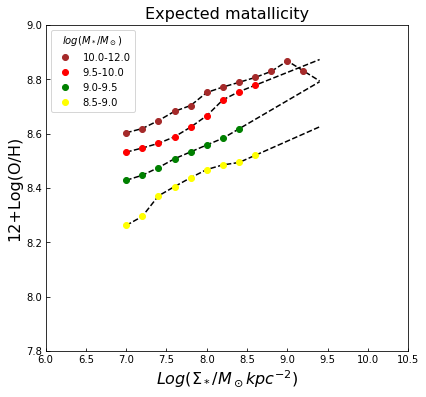

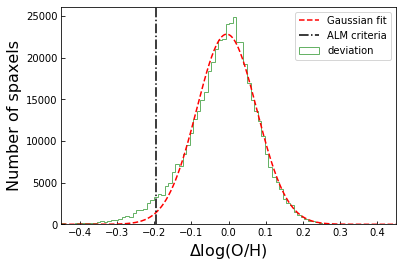

In [47]:
# 计算每个spaxel的预期金属丰度
# 得到 number of spaxels - metallicity deviation图
# 再加上高斯分布的拟合，对比二者得到ALM区域的标准

'''
1. 求出 expected metallicity
2. obs - exp 求出偏差
3. 得到 金属丰度偏差 的分布直方图
'''
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

# 读取数据
cc = np.where(mass_spaxel>=math.pow(10,8.5))# 挑选出星系质量>10^8.5Msun 的spaxel
print('cc = ',cc)
print('cc维度 = ',np.shape(cc))
mass_sel = cc[0]
sel_spaxel_data = spaxel_data[mass_sel].copy()
sel_mass_spaxel = mass_spaxel[mass_sel].copy()
sel_Znew = Znew[mass_sel].copy()
sel_density = firefly_spaxel_density[mass_sel].copy() #firefly_spaxel_density[mass_sel] #spaxel_density[mass_sel]
den_Z = expeted_data[::-1].copy()# 待插值的 密度，金属丰度 数据点

# 插值方法
kind = 'linear'#'linear'# 'cubic'# interpolation method 

range_mass = np.array([[8.5,9],[9,9.5],[9.5,10],[10,12]])
for_mass = range_mass[::-1]

# 初始化 预期金属丰度 数组
Z_exp = np.ones([sel_Znew.size,1])*np.nan
Z_dev = np.ones([sel_Znew.size,1])*np.nan
i = 0# 循环计数变量
plt.figure(figsize=(6.5,6))
for_list = np.array([['yellow','green','red','brown'],['8.5-9.0','9.0-9.5','9.5-10.0','10.0-12.0']],dtype=str)
for_list = for_list.transpose()[::-1]
for c,label in for_list:
    x = den_Z[20*i:20*i+20,0]
    y = den_Z[20*i:20*i+20,1]
    # 去除不想要的黄色点
    if c=='yellow0':
        x[np.where(x>8.7)[0]]=np.nan
        y[np.where(x>8.7)[0]]=np.nan
    # 去除不想要的绿色点
    if c=='green':
        x[np.where(x>8.5)[0]]=np.nan
        y[np.where(x>8.5)[0]]=np.nan
    # 去除不想要的红色点
    if c=='red':
        x[np.where(x>8.9)[0]]=np.nan
        y[np.where(x>8.7)[0]]=np.nan
    # 去除不想要的褐色点
    if c=='brown0':
        x[np.where(x>8.7)[0]]=np.nan
        y[np.where(x>8.7)[0]]=np.nan
    
    #pl.plot(x,y,"ro",label='sample')# 样本点画图
    lala = (~np.isnan(x))&(~np.isnan(y))
    f=interpolate.interp1d(x[lala],y[lala],fill_value="extrapolate",kind=kind)# 使用插值函数
    #xnew = np.linspace(7,x[~np.isnan(x)].max(),50)
    xnew = np.linspace(7,9.4,100)
    ynew=f(xnew)# 得到插值结果
    plt.plot(xnew,ynew,'--',color='black')#,bandwidth=0.2)
    plt.plot(x,y,'o',color=c,label=label)
    
    # 获取每个spaxel的预期金属丰度
    ii = for_mass[i]
    idspaxel = (sel_mass_spaxel>=math.pow(10,ii[0]))&(sel_mass_spaxel<math.pow(10,ii[1]))
    Z_exp[idspaxel] = f(sel_density[idspaxel[:,0]])
    Z_dev[idspaxel] = sel_Znew[idspaxel[:,0]] - Z_exp[idspaxel]
    i+=1

plt.title("Expected matallicity",fontsize=16)
plt.xlabel('$Log(\Sigma_*/M_\odot kpc^{-2})$',fontsize=16)    # x轴标签
plt.ylabel('12+Log(O/H)',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
plt.legend(loc='best',title='$log(M_*/M_\odot)$')#loc='lower right'
plt.xlim([6,10.5])
plt.ylim([7.8,9])
plt.show()

# 金属丰度偏差
# Z_dev = sel_Znew - Z_exp

# 筛选出 星系质量>10^9Msun 的spaxels
cc = np.where(sel_mass_spaxel>=math.pow(10,9))[0]# 挑选出星系质量>10^9Msun 的spaxels
sel_density = sel_density[cc]
Z_dev = Z_dev[cc]
Z_exp = Z_exp[cc]
# dd = np.where(sel_density>7)[0]# 挑选出surface mass density>10^7的spaxels
sel_Z_dev = Z_dev[dd]
Z_exp = Z_exp[dd]
sel_density = sel_density[dd]

# 金属丰度偏差 分布图
hist,bins,__ = plt.hist(sel_Z_dev,bins=150, alpha=0.6, color='g',histtype='step',label='deviation');
plt.xlim([-0.45,0.45])
###################################################################################
# hist,bins = np.histogram(Z_dev,bins=150);
# 高斯拟合
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

x = bins[1:]-(bins[1]-bins[0])/2# 调整bin的个数及大小
y = hist# 数量

n = len(x)# 数据点总数
mean = sum(x)/n# 平均数
sigma = (sum((x-mean)**2)/n)**0.5# 标准差

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])# 开始拟合
xmin,xmax = plt.xlim()# 坐标轴范围
newx = np.linspace(xmin,xmax,1000)# 新的更密集的点，用来画图，更加光滑
plt.plot(newx,gaus(newx,*popt),'r--',label='Gaussian fit')# 画图
###########################################################################

# ALM 标准
y_exp = gaus(x,*popt)
delta_y = y - y_exp
delta_y = delta_y[np.where(x<-0.1)]
x = x[np.where(x<-0.1)]
ALM = x[np.where(delta_y==delta_y.max())]
plt.axvline(ALM,color='black',linestyle='-.',label='ALM criteria')

plt.tick_params(which='both',direction='in')
plt.legend(loc='best')
plt.xlabel('$\Delta$log(O/H)',fontsize=16)
plt.ylabel('Number of spaxels',fontsize=16)
plt.show()

In [48]:
print(np.shape(mass_spaxel))
print(np.shape(spaxel_data))
print(np.shape(Znew))g
print(np.shape(sel_Z_dev))

(666098, 1)
(666098, 12)
(666098,)
(497576, 1)


## ALM条件

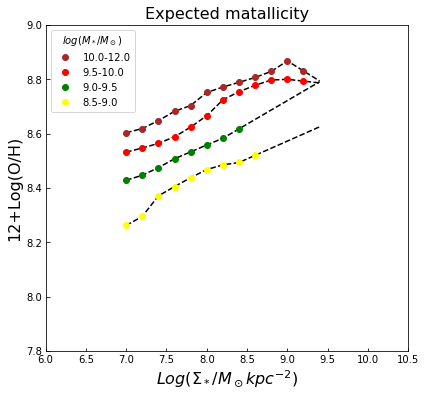

Z_exp =  (666098, 1)
Znew =  (666098,)
xx =  [0.02928349 0.03938035 0.04947721 0.05957407 0.06967092 0.07976778
 0.08986464 0.0999615  0.11005836 0.12015522 0.13025208 0.14034894
 0.15044579 0.16054265 0.17063951 0.18073637 0.19083323 0.20093009
 0.21102695 0.22112381 0.23122066 0.24131752 0.25141438 0.26151124
 0.2716081  0.28170496 0.29180182 0.30189868 0.31199554 0.32209239
 0.33218925 0.34228611 0.35238297 0.36247983 0.37257669 0.38267355
 0.39277041 0.40286726 0.41296412 0.42306098 0.43315784 0.4432547 ] 
yy =  [2.9919e+04 2.6945e+04 2.3008e+04 2.1124e+04 1.8664e+04 1.8519e+04
 1.5169e+04 1.2490e+04 1.1145e+04 1.0287e+04 7.8620e+03 7.0090e+03
 4.7360e+03 4.6210e+03 3.8180e+03 2.6700e+03 1.7890e+03 1.3610e+03
 8.5800e+02 7.7800e+02 6.4700e+02 3.3400e+02 1.0350e+03 2.1500e+02
 7.2900e+02 9.2000e+01 6.5000e+01 1.2500e+02 3.9000e+01 3.0000e+01
 5.9000e+01 3.4000e+01 2.0000e+01 1.4000e+01 9.0000e+00 1.1000e+01
 4.0000e+00 1.3000e+01 6.1000e+01 0.0000e+00 1.0000e+00 4.0000e+00]


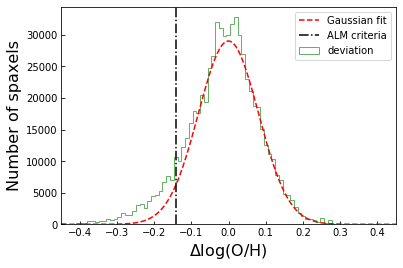

In [57]:
# 只对 偏差>0 的部分进行拟合！！！
# 求 ALM 条件！！！

# 计算每个spaxel的预期金属丰度
# 得到 number of spaxels - metallicity deviation图
# 再加上高斯分布的拟合，对比二者得到ALM区域的标准

'''
1. 求出 expected metallicity
2. obs - exp 求出偏差
3. 得到 金属丰度偏差 的分布直方图
'''
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

# 读取数据
cc = np.where(mass_spaxel>=math.pow(10,8.5))# 挑选出星系质量>10^8.5Msun 的spaxels
mass_sel = cc[0]
sel_spaxel_data = spaxel_data[mass_sel].copy()
sel_mass_spaxel = mass_spaxel[mass_sel].copy()
sel_Znew = Znew[mass_sel].copy()
sel_density = firefly_spaxel_density[mass_sel].copy() #firefly_spaxel_density[mass_sel]
den_Z = expeted_data[::-1].copy()# 待插值的 密度，金属丰度 数据点

# 插值方法
kind = 'linear'#'linear'# 'cubic'# interpolation method 

range_mass = np.array([[8.5,9],[9,9.5],[9.5,10],[10,12]])
for_mass = range_mass[::-1]

# 初始化 预期金属丰度 数组
Z_exp = np.ones([sel_Znew.size,1])*np.nan
Z_dev = np.ones([sel_Znew.size,1])*np.nan
i = 0# 循环计数变量
plt.figure(figsize=(6.5,6))
for_list = np.array([['yellow','green','red','brown'],['8.5-9.0','9.0-9.5','9.5-10.0','10.0-12.0']],dtype=str)
for_list = for_list.transpose()[::-1]
for c,label in for_list:
    x = den_Z[20*i:20*i+20,0]
    y = den_Z[20*i:20*i+20,1]
    # 去除不想要的黄色点
    if c=='yellow0':
        x[np.where(x>8.7)[0]]=np.nan
        y[np.where(x>8.7)[0]]=np.nan
    # 去除不想要的绿色点
    if c=='green':
        x[np.where(x>8.5)[0]]=np.nan
        y[np.where(x>8.5)[0]]=np.nan
    # 去除不想要的红色点
    if c=='red0':
        x[np.where(x>8.7)[0]]=np.nan
        y[np.where(x>8.7)[0]]=np.nan
    # 去除不想要的褐色点
    if c=='brown0':
        x[np.where(x>8.7)[0]]=np.nan
        y[np.where(x>8.7)[0]]=np.nan
    
    #pl.plot(x,y,"ro",label='sample')# 样本点画图
    lala = (~np.isnan(x))&(~np.isnan(y))
    f=interpolate.interp1d(x[lala],y[lala],fill_value="extrapolate",kind=kind)# 使用插值函数
    #xnew = np.linspace(7,x[~np.isnan(x)].max(),50)
    xnew = np.linspace(7,9.4,100)
    ynew=f(xnew)# 得到插值结果
    plt.plot(xnew,ynew,'--',color='black')#,bandwidth=0.2)
    plt.plot(x,y,'o',color=c,label=label)
    
    # 获取每个spaxel的预期金属丰度
    ii = for_mass[i]
    idspaxel = (sel_mass_spaxel>=math.pow(10,ii[0]))&(sel_mass_spaxel<math.pow(10,ii[1]))
    Z_exp[idspaxel] = f(sel_density[idspaxel[:,0]])
    Z_dev[idspaxel] = sel_Znew[idspaxel[:,0]] - Z_exp[idspaxel]
    i+=1

plt.title("Expected matallicity",fontsize=16)
plt.xlabel('$Log(\Sigma_*/M_\odot kpc^{-2})$',fontsize=16)    # x轴标签
plt.ylabel('12+Log(O/H)',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
plt.legend(loc='best',title='$log(M_*/M_\odot)$')#loc='lower right'
plt.xlim([6,10.5])
plt.ylim([7.8,9])
plt.show()

# 金属丰度偏差
# Z_dev = sel_Znew - Z_exp
print("Z_exp = ",np.shape(Z_exp))
print("Znew = ",np.shape(Znew))

# 筛选出 星系质量>10^9Msun 的spaxels
cc = np.where(sel_mass_spaxel>=math.pow(10,8.5))[0]# 挑选出星系质量>10^9Msun 的spaxels
sel_density = sel_density[cc]
Z_dev = Z_dev[cc]
Z_exp = Z_exp[cc]
sel_spaxel_data = sel_spaxel_data[cc]
sel_mass_spaxel = sel_mass_spaxel[cc]
# dd = np.where(sel_density>7)[0]# 挑选出surface mass density>10^7的spaxels
dd = np.where(sel_density>0)[0]# 挑选出surface mass density>10^7的spaxels
# Z_dev = Z_dev[dd]
sel_Z_dev = Z_dev[dd]
Z_exp = Z_exp[dd]
sel_spaxel_data = sel_spaxel_data[dd]
sel_mass_spaxel = sel_mass_spaxel[dd]
sel_density = sel_density[dd]

# 金属丰度偏差 分布图
hist,bins,__ = plt.hist(sel_Z_dev,bins=150, alpha=0.6, color='g',histtype='step',label='deviation');
plt.xlim([-0.45,0.45])
###################################################################################
# hist,bins = np.histogram(Z_dev,bins=150);
# 高斯拟合
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

xx = (bins[1:]-(bins[1]-bins[0])/2).copy()# 调整bin的个数及大小
yy = hist.copy()# 数量
yy = yy[np.where(xx>0.02)]
xx = xx[np.where(xx>0.02)]
print('xx = ',xx,'\nyy = ',yy)
# 只需要 x>0 的部分，按照 x=0 做对称
x = np.ones(xx.size*2)*np.nan
y = np.ones(yy.size*2)*np.nan
x[0:xx.size] = -xx
x[xx.size:] = xx
y[0:yy.size] = yy
y[yy.size:] = yy
x[xx.size] = np.nan
y[yy.size] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

n = len(x)# 数据点总数
mean = sum(x)/n# 平均数
sigma = (sum((x-mean)**2)/n)**0.5# 标准差

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])# 开始拟合
xmin,xmax = plt.xlim()# 坐标轴范围
newx = np.linspace(xmin,xmax,1000)# 新的更密集的点，用来画图，更加光滑
plt.plot(newx,gaus(newx,*popt),'r--',label='Gaussian fit')# 画图
###########################################################################

# # ALM 标准
# y_exp = gaus(x,*popt)
# delta_y = y - y_exp
# delta_y = delta_y[np.where(x<-0.1)]
# x = x[np.where(x<-0.1)]
# ALM = x[np.where(delta_y==delta_y.max())]
# plt.axvline(ALM,color='black',linestyle='-.',label='ALM criteria')

# 高斯分布和实际分布的差
oldx = (bins[1:]-(bins[1]-bins[0])/2).copy()# 调整bin的个数及大小
oldy = hist.copy()# 数量
delta_y = oldy - gaus(oldx,*popt)
tmp_crit = -0.1
delta_y = delta_y[np.where(oldx<tmp_crit)]
oldx = oldx[np.where(oldx<tmp_crit)]
ALM = oldx[np.where(delta_y==delta_y.max())]
plt.axvline(ALM,color='black',linestyle='-.',label='ALM criteria')
# plt.plot(oldx,delta_y,'k--')# 画图

plt.tick_params(which='both',direction='in')
plt.legend(loc='best')
plt.xlabel('$\Delta$log(O/H)',fontsize=16)
plt.ylabel('Number of spaxels',fontsize=16)
plt.show()


In [61]:
print(np.shape(Znew))
print(np.shape(sel_Znew))
print(np.shape(Z_exp))

print(np.shape(sel_mass_spaxel))
print(np.shape(sel_Z_dev))

print(np.shape(spaxel_data))
print(np.shape(sel_spaxel_data))

(666098,)
(666098,)
(666098, 1)
(666098, 1)
(666098, 1)
(666098, 12)
(666098, 12)


In [62]:
# 获取 "plate-ifu" 信息
# MaNGA 每个星系的 star-forming spaxels个数【plate,ifu,num_sf_spaxles,id[0,4675]】
plate_ifu_sfnum = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/plate_ifu_spaxel_v2.0.dat")
print(np.shape(plate_ifu_sfnum))

(4675, 4)


In [78]:
spaxel_data[8800,:13]

array([ 5.50000000e+01,  3.80000000e+01,  3.00000000e+01,  2.90000000e+01,
        8.30052948e+00,  9.26379490e+00,  2.28691816e+00,  2.68946099e+00,
        5.56418359e-01,  1.86045241e+00,  1.34696937e+00, -9.99900000e+03])

In [59]:
ALM

array([-0.14236311])

In [33]:
print(np.shape(sel_Znew))

(666098,)


In [188]:
print(popt)
print(pcov)

[ 2.30826542e+04 -3.08247991e-05  7.37866330e-02]
[[ 3.38032649e+04  4.65949206e-03 -6.99439183e-02]
 [ 4.65949206e-03  2.23165646e-07 -8.84220274e-09]
 [-6.99439183e-02 -8.84220274e-09  2.88794426e-07]]


In [21]:
sel_spaxel_data.shape

(497576, 12)

In [32]:
Z_dev.shape

(497576, 1)

## 导出数据【金属丰度及其预期值】
+ 金属丰度由pyqz二维格子插值得到&emsp;$Z_{new}$
+ 预期值由每一质量分组的peak得到的函数进行拟合得到&emsp;$Z_{exp}$   
比较 csv，pkl，npy三种保存方式的文件大小：`npy<pkl<csv`
> csv和txt一样，都能用excel等软件直接打开   
> pkl是pandas.dataframe拥有的 `序列化` 存储，可以很好的压缩。   
> npy是numpy的保存为 `二进制` 文件，压缩情况最好，读写速度也最快。

In [ ]:
# 获取每个spaxel所在的星系的 plate-ifu 编号
firefly_fits = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
tmp_plaifu = firefly_fits[1].data['PLATEIFU']
array_id = sel_spaxel_data[:,0].astype(int)
plateifu = tmp_plaifu[array_id]
firefly_fits.close()



In [181]:
import pandas as pd    # numpy加强版
# 构造字典
array_id = sel_spaxel_data[:,0].astype(dtype='int64')
bin_id_2800 = sel_spaxel_data[:,1].astype(dtype='int64')
spaxel_x = sel_spaxel_data[:,2].astype(dtype='int64')
spaxel_y = sel_spaxel_data[:,3].astype(dtype='int64')
data = {'plate-ifu':plateifu,
        'array_id':array_id,
        'bin_id_2800':bin_id_2800,
        'spaxel_x':spaxel_x,
        'spaxel_y':spaxel_y,
        'metallicity_pyqz':Znew,
        'metallicity_expeted':Z_exp[:,0]}
# 转换为 pandas 数组
df = pd.DataFrame(data,columns=['plate-ifu','array_id','bin_id_2800','spaxel_x','spaxel_y','metallicity_pyqz','metallicity_expeted'])
# # 更改变量类型
# df = df.astype(dtype={'plate-ifu': str})

# 转换为 numpy 数组
# names = ['plate-ifu','array_id','bin_id_2800','spaxel_x','spaxel_y','metallicity_pyqz','metallicity_expeted']
# formats = ['str','int64','int64','int64','int64','float64','float64']
# dtype = dict(names = names, formats=formats)
save_np = df.to_numpy()

# 打印检查
print("数据格式为：\n",df.ftypes)
# print("数据为： ",df)
print("数据格式为：\n",save_np.dtype)
print("数据为： ",save_np)

# 导出文件
# df.to_csv('recfast_z_XeH_XeHe_Xe_Tm.csv',index=1,header=1)# 保存行名，列名
# 保存文件：original_df.to_pickle("./dummy.pkl")
# 读取文件：unpickled_df = pd.read_pickle("./dummy.pkl")
# df.to_pickle("./tmp_storage/MaNGA_Z.pd.pkl")

# numpy 导出为二进制文件 npy
# np.save("./tmp_storage/MaNGA_Z.npy",save_np)

数据格式为：
 plate-ifu               object:dense
array_id                 int64:dense
bin_id_2800              int64:dense
spaxel_x                 int64:dense
spaxel_y                 int64:dense
metallicity_pyqz       float64:dense
metallicity_expeted    float64:dense
dtype: object
数据格式为：
 object
数据为：  [['8252-12701' 0 17 ... 28 7.934875144155075 8.42305404280939]
 ['8252-12701' 0 17 ... 28 7.934875144155075 8.42305404280939]
 ['8252-12701' 0 17 ... 29 7.934875144155075 8.42305404280939]
 ...
 ['8485-12704' 4674 84 ... 38 8.369295109774379 8.427855904925094]
 ['8485-12704' 4674 84 ... 39 8.369295109774379 8.427855904925094]
 ['8485-12704' 4674 84 ... 37 8.369295109774379 8.427855904925094]]


In [182]:
# numpy 导出为压缩的 二进制文件 npy
np.save("./tmp_storage/MaNGA_Z.npy",save_np)

In [183]:
# pandas 导出为压缩的 序列化 数据
df.to_pickle("./tmp_storage/MaNGA_Z.pd.pkl")

In [184]:
# pandas 导出为一般的文本文件，未压缩
df.to_csv('./tmp_storage/MaNGA_Z.csv',index=1,header=1)

In [169]:
result = {0: 1.1181753789488595, 1: 0.5566080288678394, 2: 0.4718269778030734, 3: 0.48716683119447185, 4: 1.0, 5: 0.1395076201641266, 6: 0.20941558441558442}

names = ['id','data']
formats = ['f8','f8']
dtype = dict(names = names, formats=formats)
# array=np.array([[key,val] for (key,val) in result.iteritems()],dtype)
array = np.fromiter(result.items(), dtype=dtype, count=len(result))
type(array)

numpy.ndarray

In [180]:
df.to_numpy()

array([['8252-12701', 0, 17, ..., 28, 7.934875144155075,
        8.42305404280939],
       ['8252-12701', 0, 17, ..., 28, 7.934875144155075,
        8.42305404280939],
       ['8252-12701', 0, 17, ..., 29, 7.934875144155075,
        8.42305404280939],
       ...,
       ['8485-12704', 4674, 84, ..., 38, 8.369295109774379,
        8.427855904925094],
       ['8485-12704', 4674, 84, ..., 39, 8.369295109774379,
        8.427855904925094],
       ['8485-12704', 4674, 84, ..., 37, 8.369295109774379,
        8.427855904925094]], dtype=object)

***

In [80]:
firefly_fits = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits') 


In [188]:
a = firefly_fits[1].data['PLATEIFU']
print(np.shape(a))
print(np.shape(sel_spaxel_data)[0])

plateifu = 0#np.ones(np.shape(sel_spaxel_data)[0]-1000)*-666
# plateifu = plateifu.astype(str)
# plateifu = np.chararray(np.shape(sel_spaxel_data)[0])
print(np.shape(plateifu))
b = sel_spaxel_data[:,0].astype(int)
plateifu = a[b]
print("plateifu 格式为",plateifu.dtype)

(4675,)
666098
()
plateifu 格式为 <U20


In [273]:
ipcluster start -n

SyntaxError: invalid syntax (<ipython-input-273-f8702843deea>, line 1)

In [98]:
sel_Z_dev.shape

(586519,)

# 重写 金属丰度预期值

In [ ]:
'''
以 firefly_MaNGA 4675 为标准
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from copy import copy as copy
from os.path import join
from marvin.tools import Maps
import warnings
# warnings.filterwarnings('ignore')    # 不显示warning信息

# 获取 spaxel 数据：surface mass density, stellar mass, metallicity(pyqz)

# drpall.fits 获取 plate-ifu, NSA_ELPETRO_BA
path_drpall = '/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits'
drpall = fits.open(path_drpall)
drpall_plifu = drpall[1].data['PLATEIFU']
drpall_ba = drpall[1].data['NSA_ELPETRO_BA']

# firefly.fits 获取 surface mass density

# 导入 pyqz 计算出的 spaxel 的 metallicity
manga_Z = pd.read_pickle("./tmp_storage/MaNGA_Z.pd.pkl")
sp_Z = manga_Z['metallicity_pyqz'].values





In [ ]:
# 锁定每个 spaxel 的 surface mass density 值
# 使用 firefly.fits
# datamodel: https://data.sdss.org/datamodel/files/MANGA_FIREFLY/FIREFLY_VER/manga_firefly.html
# MaNGA_plaifu = '8945-12705'
def mask_density(plate_ifu):
    firefly_fits = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
    tmp_id = (plate_ifu==firefly_fits[1].data['PLATEIFU'])
    surf_density = firefly_fits[13].data[tmp_id,:,0][0]# 2800长度

    # 2800数组转为二维正方形矩阵，导出 mask
    #read in the vac file

    binid = firefly_fits[5].data[tmp_id,:,:][0]
    bin1d = firefly_fits[4].data[tmp_id,:,0][0]    # 获取一维的bin数据
    arr_2800 = surf_density
    # 画图
    image_sz = np.shape(ha)[0]    # 图像边长
    matrix = np.ones((image_sz,image_sz))*np.nan    # 初始化画图数组
    for i in range(image_sz):
        for j in range(image_sz):
            idbin = (bin1d==binid[i,j])    # 搜索二维bin的值在一维bin数组中的 位置
            if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
                matrix[i,j] = arr_2800[idbin]

    # surface mass density 筛选
    # mask_density = np.ma.array(matrix,mask=(matrix>7))
    mask_density = (matrix>7)
    return mask_density

In [441]:
''' 简单的修改，直接循环计算所有的spaxel的金属丰度预期值
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from copy import copy as copy
from os.path import join
from marvin.tools import Maps
import warnings
# warnings.filterwarnings('ignore')    # 不显示warning信息

path_drpall = '/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits'
drpall = fits.open(path_drpall)
firefly_fits = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
manga_Z = pd.read_pickle("./tmp_storage/MaNGA_Z.pd.pkl")

# every spaxel's stellar mass
stellar_mass = [
    firefly_fits[1].data['PHOTOMETRIC_MASS'][(firefly_fits[1].data['PLATEIFU']==plifu)][0]\
    for plifu in manga_Z['plate-ifu']
]
stellar_mass = np.log10(stellar_mass)
# every spaxel's surface mass density
mass_density = [
    firefly_fits[13].data[(firefly_fits[1].data['PLATEIFU']==plifu),x2800,0][0]\
 for plifu,x2800 in zip(manga_Z['plate-ifu'],\
                        manga_Z['bin_id_2800'])
]



In [463]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy import stats

# 偏态分布【plus=0就是正态分布】
def gaus_plus(x,a,x0,sigma,plus):
    fit_result = a*stats.skewnorm.pdf((x-x0)/sigma, plus)
    return fit_result

# 分组，寻找 金属丰度预期值
def peak_Z(mass,density):
    if mass>10.25:
        sel_mass = (stellar_mass>=mass-0.25)
    elif mass>0:
        sel_mass = (stellar_mass>=mass-0.25)&(stellar_mass<=mass+0.25)
    else:
        raise ValueError("value of stellar mass wrong")
    sel_density = (mass_density>=density-0.1)&(mass_density<=density+0.1)
    sel_Z = manga_Z['metallicity_pyqz'].values[sel_mass&sel_density]
    
    bins = int((np.max(sel_Z)-np.min(sel_Z))/0.05)+1  # 避免出现最大值和最小值一样的情况
    if bins==1:
        return np.max(sel_Z)
    else:
        # 直方图分布
        hist_y,bins_x = np.histogram(sel_Z,bins=bins)
        #hist,bins,__ = plt.hist(fix_Z,bins=int(((np.max(fix_Z)-np.min(fix_Z))/0.05)+1),alpha=0.7, color='g',label='data');
        
        # 拟合
        x = bins_x[1:]-(bins_x[1]-bins_x[0])/2  # 去掉左端值，并且向右侧平移半格
        y = hist_y
        n = len(x)  # 数据点个数
        mean = sum(x)/n  # 金属丰度平均值
        sigma = (sum((x-mean)**2)/n)**0.5
        a = np.max(y)
        
        # 若拟合失败，则返回平均值
        try:
            popt,pcov = curve_fit(gaus_plus,x,y,p0=[a,mean,sigma,0])
        except:
            return mean
        
        # 找peak
        newx = np.linspace(x.min(),x.max(),3000)
        newy = gaus_plus(newx,*popt)
        expcted_Z = newx[np.where(newy==newy.max())[0]][0]
        return expcted_Z

new_exp_Z = [peak_Z(mass,density)for mass,density in zip(stellar_mass[0:100], mass_density[0:100])]
# print(new_exp_Z)

In [465]:
save_hist(data, name, filename):
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(a, bins=30, color="blue")
fig.tight_layout()
fig.savefig("tmp_Z.png")
plt.close(fig)

(666098,)

In [ ]:
tmp_exp_Z = [peak_Z(mass,density)for mass,density in zip(stellar_mass[22:25], mass_density[22:25])]
tmp_peak_Z = partial(peak_Z, density=mass_density[22:25])
a = np.array(list(map(tmp_peak_Z,stellar_mass[22:25])))
print(a)             

In [466]:
from multiprocessing import Pool

# if __name__ == '__main__': # 多线程，多参数，starmap版本
x = stellar_mass
y = mass_density

zip_args = list(zip(x, y))
pool = Pool()
new_exp_Z = pool.starmap(peak_Z, zip_args)
pool.close()
pool.join()

print(a)

OSError: [Errno 12] Cannot allocate memory

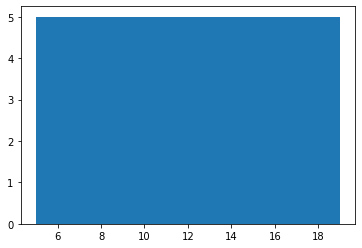

In [467]:
''' 【并行版本】简单的修改，直接循环计算所有的spaxel的金属丰度预期值
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from copy import copy as copy
from os.path import join
from marvin.tools import Maps
import warnings
from multiprocessing import Pool
warnings.filterwarnings('ignore')    # 不显示warning信息

path_drpall = '/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits'
drpall = fits.open(path_drpall)
firefly_fits = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
manga_Z = pd.read_pickle("./tmp_storage/MaNGA_Z.pd.pkl")

def _stellar_mass(plateifu):
    mass = firefly_fits[1].data['PHOTOMETRIC_MASS'][(firefly_fits[1].data['PLATEIFU']==plateifu)][0]
    return mass

def _mass_density(plateifu,x2800):
    density = firefly_fits[13].data[(firefly_fits[1].data['PLATEIFU']==plateifu),x2800,0][0]
    return density


# 开始并行
pool = Pool()

stellar_mass = pool.map(_stellar_mass, manga_Z['plate-ifu'])

x = manga_Z['plate-ifu']
y =  manga_Z['bin_id_2800']
zip_args = list(zip(x, y))
mass_density = pool.starmap(_mass_density, zip_args)

pool.close()
pool.join()

In [ ]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy import stats

# 偏态分布【plus=0就是正态分布】
def gaus_plus(x,a,x0,sigma,plus):
    fit_result = a*stats.skewnorm.pdf((x-x0)/sigma, plus)
    return fit_result

# 分组，寻找 金属丰度预期值
def peak_Z(mass,density):
    if mass>10.25:
        sel_mass = (stellar_mass>=mass-0.25)
    elif mass>0:
        sel_mass = (stellar_mass>=mass-0.25)&(stellar_mass<=mass+0.25)
    else:
        raise ValueError("value of stellar mass wrong")
    sel_density = (mass_density>=density-0.1)&(mass_density<=density+0.1)
    sel_Z = manga_Z['metallicity_pyqz'].values[sel_mass&sel_density]
    
    bins = int((np.max(sel_Z)-np.min(sel_Z))/0.05)+1  # 避免出现最大值和最小值一样的情况
    if bins==1:
        return np.max(sel_Z)
    else:
        # 直方图分布
        hist_y,bins_x = np.histogram(sel_Z,bins=bins)
        #hist,bins,__ = plt.hist(fix_Z,bins=int(((np.max(fix_Z)-np.min(fix_Z))/0.05)+1),alpha=0.7, color='g',label='data');
        
        # 拟合
        x = bins_x[1:]-(bins_x[1]-bins_x[0])/2  # 去掉左端值，并且向右侧平移半格
        y = hist_y
        n = len(x)  # 数据点个数
        mean = sum(x)/n  # 金属丰度平均值
        sigma = (sum((x-mean)**2)/n)**0.5
        a = np.max(y)
        
        # 若拟合失败，则返回平均值
        try:
            popt,pcov = curve_fit(gaus_plus,x,y,p0=[a,mean,sigma,0])
        except:
            return mean
        
        # 找peak
        newx = np.linspace(x.min(),x.max(),3000)
        newy = gaus_plus(newx,*popt)
        expcted_Z = newx[np.where(newy==newy.max())[0]][0]
        return expcted_Z

# new_exp_Z = [peak_Z(mass,density)for mass,density in zip(stellar_mass[0:100], mass_density[0:100])]
# print(new_exp_Z)

In [ ]:
# 开始计算 预期值
from multiprocessing import Pool

# if __name__ == '__main__': # 多线程，多参数，starmap版本
x = stellar_mass
y = mass_density

zip_args = list(zip(x, y))
pool = Pool()
new_exp_Z = pool.starmap(peak_Z, zip_args)
pool.close()
pool.join()


In [ ]:
# 导出为文件
import pandas as pd    # numpy加强版
# 构造字典
array_id = sel_spaxel_data[:,0].astype(dtype='int64')
bin_id_2800 = sel_spaxel_data[:,1].astype(dtype='int64')
spaxel_x = sel_spaxel_data[:,2].astype(dtype='int64')
spaxel_y = sel_spaxel_data[:,3].astype(dtype='int64')
data = {'plate-ifu':manga_Z['plate-ifu'].values,
        'array_id':manga_Z['array_id'].values,
        'bin_id_2800':manga_Z['bin_id_2800'].values,
        'spaxel_x':manga_Z['spaxel_x'].values,
        'spaxel_y':manga_Z['spaxel_y'].values,
        'metallicity_pyqz':manga_Z['metallicity_pyqz'].values,
        'metallicity_expeted':new_exp_Z}
# 转换为 pandas 数组
df = pd.DataFrame(data,columns=['plate-ifu','array_id','bin_id_2800','spaxel_x','spaxel_y','metallicity_pyqz','metallicity_expeted'])
# # 更改变量类型
# # pandas 导出为压缩的 序列化 数据
# df.to_pickle("./tmp_storage/MaNGA_Z_v2.0.pd.pkl")

(array([3., 3., 4.]), array([ 5.,  8., 11., 14.]), <a list of 3 Patch objects>)

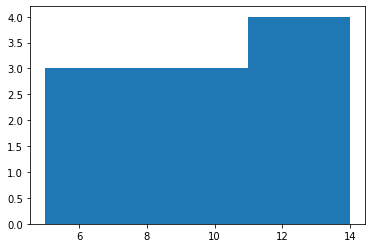

In [436]:
# ALM 分布图
# ALM 条件

sel_Z_dev = copy(manga_Z['metallicity_pyqz'] - new_exp_Z)

# surface mass density > 7 筛选
# sel_Z_dev = sel_Z_dev[mass_density>7]

# surface mass density > 7 & stellar mass > 9 筛选
# sel_Z_dev = sel_Z_dev[(mass_density>7)&(stellar_mass>9)]


# 金属丰度偏差 分布图
hist,bins,__ = plt.hist(sel_Z_dev,bins=150, alpha=0.6, color='g',histtype='step',label='deviation');
plt.xlim([-0.45,0.45])
###################################################################################
# hist,bins = np.histogram(Z_dev,bins=150);
# 高斯拟合
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

xx = (bins[1:]-(bins[1]-bins[0])/2).copy()# 调整bin的个数及大小
yy = hist.copy()# 数量
yy = yy[np.where(xx>0.02)]
xx = xx[np.where(xx>0.02)]
# print('xx = ',xx,'\nyy = ',yy)
# 只需要 x>0 的部分，按照 x=0 做对称
x = np.ones(xx.size*2)*np.nan
y = np.ones(yy.size*2)*np.nan
x[0:xx.size] = -xx
x[xx.size:] = xx
y[0:yy.size] = yy
y[yy.size:] = yy
x[xx.size] = np.nan
y[yy.size] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

n = len(x)# 数据点总数
mean = sum(x)/n# 平均数
sigma = (sum((x-mean)**2)/n)**0.5# 标准差

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])# 开始拟合
xmin,xmax = plt.xlim()# 坐标轴范围
newx = np.linspace(xmin,xmax,1000)# 新的更密集的点，用来画图，更加光滑
plt.plot(newx,gaus(newx,*popt),'r--',label='Gaussian fit')# 画图
###########################################################################

# # ALM 标准
# y_exp = gaus(x,*popt)
# delta_y = y - y_exp
# delta_y = delta_y[np.where(x<-0.1)]
# x = x[np.where(x<-0.1)]
# ALM = x[np.where(delta_y==delta_y.max())]
# plt.axvline(ALM,color='black',linestyle='-.',label='ALM criteria')

# 高斯分布和实际分布的差
oldx = (bins[1:]-(bins[1]-bins[0])/2).copy()# 调整bin的个数及大小
oldy = hist.copy()# 数量
delta_y = oldy - gaus(oldx,*popt)
tmp_crit = -0.1
delta_y = delta_y[np.where(oldx<tmp_crit)]
oldx = oldx[np.where(oldx<tmp_crit)]
ALM = oldx[np.where(delta_y==delta_y.max())]
plt.axvline(ALM,color='black',linestyle='-.',label='ALM criteria')
# plt.plot(oldx,delta_y,'k--')# 画图

plt.tick_params(which='both',direction='in')
plt.legend(loc='best')
plt.xlabel('$\Delta$log(O/H)',fontsize=16)
plt.ylabel('Number of spaxels',fontsize=16)
plt.annotate(r'$\Delta log(O/H)=%.3f$' % ALM, xy=(ALM, 20000), xycoords='data', xytext=(-100, +30),
             textcoords='offset points', fontsize=9,
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2"))
plt.show()

In [431]:
def tmp_test(x,y):
    print(x,y)
    return 0
def tmp_test2(x,y):
    print(x,"y")
    return 1
[[tmp_test(x,y),tmp_test2(x,"y")][x<5]for x,y in zip(np.array([1,1,2,2,5,99]),range(6))]

1 0
1 y
1 1
1 y
2 2
2 y
2 3
2 y
5 4
5 y
99 5
99 y


[1, 1, 1, 1, 0, 0]

In [429]:
# [[x*100,x][x %2] for x in range(1,10)]
[[x*100,y][x %2] for x,y in zip(range(1,10),range(10,20))]

[10, 200, 12, 400, 14, 600, 16, 800, 18]

In [425]:
[print(x,"y") if y<5 else print(x,y)for x,y in zip(np.array([1,1,2,2,5,99]),range(6))]

1 y
1 y
2 y
2 y
5 y
99 5


[None, None, None, None, None, None]

In [417]:
manga_Z

plate-ifu  array_id  bin_id_2800  spaxel_x  spaxel_y  \
0       8252-12701         0           17        27        28   
1       8252-12701         0           17        28        28   
2       8252-12701         0           17        28        29   
3       8252-12701         0           17        28        30   
4       8252-12701         0           17        28        31   
...            ...       ...          ...       ...       ...   
666093  8485-12704      4674           84        53        36   
666094  8485-12704      4674           84        53        37   
666095  8485-12704      4674           84        53        38   
666096  8485-12704      4674           84        53        39   
666097  8485-12704      4674           84        54        37   

        metallicity_pyqz  metallicity_expeted  
0               7.934875             8.423054  
1               7.934875             8.423054  
2               7.934875             8.423054  
3               7.934875             8.423054  
4               7.934875             8.423054  
...                  ...                  ...  
666093          8.369295             8.427856  
666094          8.369295             8.427856  
666095          8.369295             8.427856  
666096          8.369295             8.427856  
666097          8.369295             8.427856  

[666098 rows x 7 columns]

In [415]:
from multiprocessing import Pool
import os, time, random

def long_time_task(name):
    print('Run task %s (%s)...' % (name, os.getpid()))
    start = time.time()
    time.sleep(random.random() * 3)
    end = time.time()
    print('Task %s runs %0.2f seconds.' % (name, (end - start)))

if __name__=='__main__':
    print('Parent process %s.' % os.getpid())
    p = Pool(4)
    for i in range(5):
        p.apply_async(long_time_task, args=(i,))
    print('Waiting for all subprocesses done...')
    p.close()
    p.join()
    print('All subprocesses done.')

Parent process 13353.


OSError: [Errno 12] Cannot allocate memory

In [414]:
import multiprocessing
 
def f(x):
    return x * x
 
cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=cores)
xs = range(5)
 
# method 1: map
pool.map(f, xs)  # prints [0, 1, 4, 9, 16]

OSError: [Errno 12] Cannot allocate memory

In [ ]:
# 偏态分布【plus=0就是正态分布】
def gaus_plus(x,a,x0,sigma,plus):
    fit_result = a*stats.skewnorm.pdf((x-x0)/sigma, plus)
    return fit_result

for i in mass,density
if 
mass_range = (mass)
density_range = 

In [413]:
'''
mass_spaxel    # 每个spaxel所在的星系质量stellar mass
firefly_spaxel_density     # 每个spaxel的质量密度
Znew    # 每个spaxel的金属丰度
得到的最终结果为：expeted_data
    第一列：surface mass density
    第二列：metallicity mode
'''
#import matplotlib.mlab as mlab
# 高斯分布【正态分布】
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

# 偏态分布【plus=0就是正态分布】
def gaus_plus(x,a,x0,sigma,plus):
    fit_result = a*stats.skewnorm.pdf((x-x0)/sigma, plus)
    return fit_result

# 选择样本种类 Firefly或者PIPE3D
data_style = 'Firefly'# 'Firefly' #'PIPE3D'

# 按照 星系质量stellar mass分组
# 8.5-9，9-9.5，9.5-10，10-12
range_mass = np.array([[8.5,9],[9,9.5],[9.5,10],[10,12]])
# 初始化 预期金属丰度的数据点
expeted_data = np.ones([20*4,2])*np.nan
i_mass = 0
# j_density = 0
for i in range_mass:
    idspaxel = (mass_spaxel>=math.pow(10,i[0]))&(mass_spaxel<math.pow(10,i[1]))
    # surface mass density选择：firefly或者PIPE3D
    # spaxel_density[idspaxel[:,0]]#firefly_spaxel_density[idspaxel[:,0]]
    if data_style=='Firefly':
        tmp_density = (firefly_spaxel_density[idspaxel[:,0]]).copy()
    elif data_style=='PIPE3D':
        tmp_density = (spaxel_density[idspaxel[:,0]]).copy()
    else:
        raise ValueError("is data from Firefly or PIPE3D ???")
    
    tmp_Z = Znew[idspaxel[:,0]]
    j_density=0
    for j in np.arange(7,np.max(tmp_density[~np.isnan(tmp_density)]),0.2):#9.5,0.2):
        iddensity = (tmp_density>=j-0.4)&(tmp_density<=j+0.4)
        fix_density = tmp_density[iddensity]
        fix_Z = tmp_Z[iddensity]
        #if fix_Z.size==0:
            #j_density+=1
            #continue
        # 金属丰度分布
        #hist,bins,__ = plt.hist(tmp_Znew,bins=100,label='data',normed=1)#,normed=1
        hist,bins,__ = plt.hist(fix_Z,bins=int(((np.max(fix_Z)-np.min(fix_Z))/0.05)+1),alpha=0.7, color='g',label='data');
        #hist,bins = np.histogram(fix_Z,bins=int((np.max(fix_Z)-np.min(fix_Z))/0.03+1));
        if len(hist)==1:
            j_density+=1
            continue
        # 预期金属丰度
        #modeZ = (bins[np.where(hist==np.max(hist))]+(bins[1]-bins[0])/2)[0]
        #expeted_data[i_mass*20+j_density,0] = j
        #expeted_data[i_mass*20+j_density,1] = expcted_Z
        #num_Z = hist[np.where(hist==np.max(hist))][0]
        #plt.axvline(expcted_Z,color='orange',linestyle='-.',label='mode');
        
        # 高斯分布拟合
        #mu =np.mean(fix_Z) #计算均值 
        #sigma =np.std(fix_Z)
        #y = mlab.normpdf(bins, mu, sigma)#拟合一条最佳正态分布曲线y 
        #plt.plot(bins, y, 'r--',label='Gaussian fit') #绘制y的曲线
        #plt.legend(loc='best')
        #plt.title('Metallicity distribution',fontsize=18)
        #plt.xlabel('Metallicity',fontsize=16)
        #plt.ylabel('Number of spaxels',fontsize=16)
        #plt.show()
        
        x = bins[1:]-(bins[1]-bins[0])/2
        y = hist
        # 去除无用数据
        x = x[np.where(y!=0)]
        y = y[np.where(y!=0)]
        x = x[np.where(y!=1)]
        y = y[np.where(y!=1)]
        n = len(x)                          #the number of data
        mean = sum(x)/n                   #note this correction
        sigma = (sum((x-mean)**2)/n)**0.5        #note this correction
        
        a = np.max(y)
        #popt,pcov = curve_fit(gaus_plus,x,y,p0=[a,mean,sigma,0])
        try:
            popt,pcov = curve_fit(gaus_plus,x,y,p0=[a,mean,sigma,0])
            
        except:
            j_density+=1
            continue
            pass
        
        
        #popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])
        # popt,pcov = curve_fit(gaus,x,y)
        # plt.plot(x,y,'b+:',label='data')
        xmin,xmax = plt.xlim()
        newxx = np.linspace(xmin,xmax,10000)
        newx = np.linspace(xmin,xmax,5000)
        # 预期金属丰度，skewed Gaussian fit中的peak值
        newy = gaus_plus(newx,*popt)
        newyy = gaus_plus(newxx,*popt)
        expcted_Z = newx[np.where(newy==newy.max())[0]][0]
        # 存储expected metallicity
        expeted_data[i_mass*20+j_density,0] = j
        expeted_data[i_mass*20+j_density,1] = expcted_Z
        # 修正绿色的点
        if (8.5<j<8.7)&(data_style=='Firefly')&(i==np.array([ 9.0,9.5 ])).all():
            modeZ = (bins[np.where(hist==np.max(hist))]+(bins[1]-bins[0])/2)[0]
            expeted_data[i_mass*20+j_density,1] = modeZ
            print('修正成功！！ modeZ = ',modeZ)
        plt.axvline(expcted_Z,color='orange',linestyle='-.',label='peak');
        newxxx = (newxx - expeted_data[i_mass*20+j_density,1]).copy()
        #plt.show()
        plt.plot(newxx,newyy, 'r--', linewidth=2,label='skewed Gaussian fit')
        
        # 检查错误
        #print('stellar mass range = ',i,'\nsurface mass density = ',j,'\nexpected metallicity = ',expcted_Z,)
        #print('x = ',list(x))
        #print('y = ',list(y))
        #plt.plot(newx,gaus(newx,*popt),'r--',label='Gaussian fit')
        #plt.plot(x,gaus(x,*popt),'ro:',label='Gaussian fit')
        
        # 画图调整
        plt.legend(loc='best')
        ##plt.title('Metallicity distribution',fontsize=18)
        #plt.xlabel('Metallicity',fontsize=16)
        plt.xlabel('$\Delta$log(O/H)',fontsize=16)
        plt.ylabel('Number of spaxels',fontsize=16)
        #plt.xlim([-0.5,0.5])
        plt.show()
        # np.histogram
        j_density+=1
    i_mass+=1
# plt.xlim([-0.5,0.5])
# plt.xlim([8,9])
# plt.show()

# # expected metallicity plot
# kind = 'linear'#'linear'# 'cubic'# interpolation method 
# a = expeted_data[::-1].copy()# 倒序排列数组
# i = 0# 循环计数
# plt.figure(figsize=(6.5,6))
# for_list = np.array([['yellow','green','red','brown'],['8.5-9.0','9.0-9.5','9.5-10.0','10.0-12.0']],dtype=str)
# for_list = for_list.transpose()[::-1]
# for c,label in for_list:
#     x = a[20*i:20*i+20,0]
#     y = a[20*i:20*i+20,1]
    
#     #pl.plot(x,y,"ro",label='sample')# 样本点画图
#     f=interpolate.interp1d(x[~np.isnan(x)],y[~np.isnan(y)],fill_value="extrapolate",kind=kind)# 使用插值函数
#     xnew = np.linspace(7,x[~np.isnan(x)].max(),50)
#     ynew=f(xnew)# 得到插值结果
#     plt.plot(xnew,ynew,'--',color='black')#,bandwidth=0.2)
#     plt.plot(x,y,'o',color=c,label=label)
#     i+=1



# plt.title("Expected matallicity",fontsize=16)
# plt.xlabel('$Log(\Sigma_*/M_\odot kpc^{-2})$',fontsize=16)    # x轴标签
# plt.ylabel('12+Log(O/H)',fontsize=16)    # y轴标签
# plt.tick_params(which='both',direction='in')
# plt.legend(loc='lower right',title='$log(M_*/M_\odot)$')
# plt.xlim([6,10.5])
# plt.ylim([7.8,9])
# plt.show()

9.101979199011232

# ALM星系画图

## 数量统计 | 比例

In [249]:
#################################################################################
### 筛选星系：b/a, , Nair_b/a, stellar mass, fracDeV, star-forming spaxels ######
#################################################################################
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
from copy import copy as copy
from os.path import join
import math
import numpy as np
from matplotlib.colors import ListedColormap
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot
import warnings
warnings.filterwarnings('ignore')    # 不显示warning信息

# 读取文件
# MaNGA和Nair的匹配数组【已经去除重复匹配星系】
manga_match_nair = np.loadtxt("./tmp_storage/MaNGA_match_Nair.dat")
manga_match_nair = manga_match_nair.astype(int)
# MaNGA和nsa的匹配数组【已经去除重复匹配星系】
manga_match_nsa = np.loadtxt("./tmp_storage/MaNGA_match_nsa.dat")
manga_match_nsa = manga_match_nsa.astype(int)
# # MaNGA 每个星系的 star-forming spaxels个数【plate,ifu,num_sf_spaxles,id[0,4675]】
# plate_ifu_sfnum = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/plate_ifu_spaxel_v2.0.dat")
# Nair_2010中的b/a
nair_radec_ba = np.loadtxt('/root/cosmos/data/nair_ra_dec_ba.txt')
# 读取MaNGA的fits文件
manga_fits = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic_manga = copy(manga_fits[1].data)
# 读取 NASA-Sloan catalog v1 0 1 fits文件
nsa_fits = fits.open('/root/cosmos/data/nsa_v1_0_1.fits') 
basic_nsa = nsa_fits[1].data
# 载入数据
# spaxel_data = np.loadtxt("./tmp_storage/galid_ij_den_NO_logOiiioii_logniioii_star_forming_v2.0.dat")
# 读取全部的star-forming spaxel数据
spaxel_data = np.loadtxt("./tmp_storage/MaNGA_star_forming_spaxels_data_v2.0.dat")
spaxel_density = np.loadtxt("./tmp_storage/MaNGA_PIPE3D_spaxels_density_no_dust_corr.dat")
# Z = np.loadtxt("./tmp_storage/spaxels_pyqz_Metallicity.dat")
# 去除无效数据
spaxel_density = spaxel_density[np.where(spaxel_data[:,0]!=-9999)]
spaxel_data = spaxel_data[np.where(spaxel_data[:,0]!=-9999)]

# 星系椭圆率 b/a
nsa_ba = copy(basic_nsa['ELPETRO_BA'])
# 星系质量 stellar mass
nsa_mass = copy(basic_nsa['ELPETRO_MASS'])    #Stellar mass from K-correction fit (use with caution) for elliptical Petrosian fluxes
# 星系的红移 redshift
z_redshift = copy(basic_nsa['Z'])
# 星系的年龄大小的量 fracDeV<0.7
fracDeV = np.loadtxt('lalala_manga_fradeV.txt')

# 星系的 star forming spaxels 数量
num_sf = np.ones([4675,1])*np.nan# 初始化star-forming spaxels数量数组
for i in range(4675):
    idmanga = (i==spaxel_data[:,0])
    num_sf[i,0] = np.size(np.where(idmanga==True))
num_sf = num_sf.astype(int)

# num_sf = plate_ifu_sfnum[:,2]
# num_sf = num_sf.astype(int)
# nair肉眼辨别的b/a
nair_ba = nair_radec_ba[:,2]
nair_ba[np.where(nair_ba==999999)]=1    # 无效数据重置为0

# 依据 MaNGA && Nsa and MaNGA && Nair 匹配结果修整数据变量
b_over_a = nsa_ba[manga_match_nsa[:,1]]
z = z_redshift[manga_match_nsa[:,1]]
nsa_mass = nsa_mass[manga_match_nsa[:,1]]
manga_mass = nsa_mass
fracDeV = fracDeV[manga_match_nsa[:,0]]
num_sf = num_sf[manga_match_nsa[:,0]]
nair_ba = nair_ba[manga_match_nair[:,1]]

# 星系质量筛选：M >= 10^8.5 Msun
# mass_id = np.where(manga_mass >= math.pow(10,8.5))
mass_id = np.where(manga_mass >= 9)
# fracDeV筛选：fracDeV<0.7
fraD_id = np.where(fracDeV<0.7)
# b/a筛选：b/a>=0.3
ba_id = np.where(b_over_a>=0.3)
# Nair b/a筛选
nair_ba_id = np.where(nair_ba<0.42)
# 星系star-forming区域筛选：sfr spaxels >= 20
sf_id = np.where(num_sf>=20)


# 开始筛选，符合条件就在筛选数组的相应位置+1
# 初始化筛选数组
sel_manga = np.zeros([manga_mass.size,1])
sel_manga[mass_id] += 1 # 质量筛选
sel_manga[fraD_id] += 1    # 年龄筛选
print("筛选fracDeV && late-type 星系个数： ",np.shape(np.where(sel_manga==2)))
sel_manga[ba_id] += 1    # 椭圆率筛选
sel_manga[sf_id] += 1    # pure star forming 筛选

sel_galaxy = np.where(sel_manga==4)
print("不考虑nair catalog时：","\n已从 manga 4675 个星系中找出 ",np.shape(sel_galaxy)[1]," 个星系",
      "\n距论文中的 1222 个星系还差  ",np.shape(sel_galaxy)[1]-1222,"个")

# 第五次筛选：manga与nair匹配的星系中，nair_b/a >=0.4
for i in range(0,nair_ba_id[0].size):
    tmp_manga_id = manga_match_nair[nair_ba_id[0][i],0]
    idmanga = (tmp_manga_id==manga_match_nsa[:,0])
    if len(manga_match_nsa[idmanga,0])==1:
        sel_manga[idmanga]+=66


sel_galaxy = np.where(sel_manga==4)
print("考虑nair catalog时：","\n已从 manga 4675 个星系中找出 ",np.shape(sel_galaxy)[1]," 个星系",
      "\n距论文中的 1222 个星系还差  ",np.shape(sel_galaxy)[1]-1222,"个")
# 关闭打开的fits文件
nsa_fits.close()
manga_fits.close()

筛选fracDeV && late-type 星系个数：  (2, 2254)
不考虑nair catalog时： 
已从 manga 4675 个星系中找出  1490  个星系 
距论文中的 1222 个星系还差   268 个
考虑nair catalog时： 
已从 manga 4675 个星系中找出  1415  个星系 
距论文中的 1222 个星系还差   193 个


In [236]:
manga_match_nsa = np.loadtxt("./tmp_storage/MaNGA_match_nsa.dat")
manga_match_nsa = manga_match_nsa.astype(int)
print(np.shape(manga_match_nsa))
print(manga_match_nsa[:7])

(4590, 2)
[[     0 138087]
 [     1 210173]
 [     2 456925]
 [     3 384424]
 [     4 152527]
 [     5 272047]
 [     6 567284]]


In [248]:
manga_match_nair = np.loadtxt("./tmp_storage/MaNGA_match_Nair.dat")
manga_match_nair = manga_match_nair.astype(int)
print(np.shape(manga_match_nair))
print(manga_match_nair[:7])

(1079, 2)
[[1156 1217]
 [3013 1278]
 [2503 1726]
 [1289 1723]
 [1177 1671]
 [1878 1697]
 [1978 1698]]


In [256]:
# 获取 star forming & late type galaxies 的 plate-ifu
# def sel_ga(ba,mass,red):
#     if ba:
#         return
#     else:
#         return -666
# sf_ga = [sel_ga() for ]




# 获取 MaNGA 数据
mg = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
mg_mgID = mg[1].data['MANGAID ']
mg_plifu = mg[1].data['PLATEIFU']
sel_sf_gal = mg_plifu[manga_match_nsa[sel_galaxy[0],0]]



In [258]:
sel_sf_gal.shape

(1415,)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from copy import copy as copy
from os.path import join
from marvin.tools import Maps
import warnings
# warnings.filterwarnings('ignore')    # 不显示warning信息

manga_Z = pd.read_pickle("./tmp_storage/MaNGA_Z_v2.0.pd.pkl")


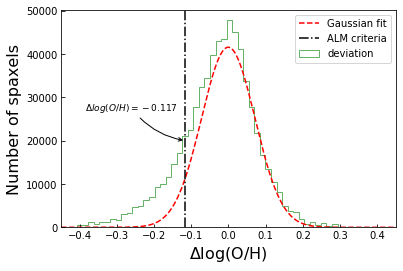

In [4]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

sel_Z_dev = manga_Z['metallicity_pyqz'].values - manga_Z['metallicity_expeted'].values

# surface mass density > 7 筛选
# sel_Z_dev = sel_Z_dev[np.array(manga_den)>7]

# stellar mass > 9 筛选



# 金属丰度偏差 分布图
hist,bins,__ = plt.hist(sel_Z_dev,bins=150, alpha=0.6, color='g',histtype='step',label='deviation');
plt.xlim([-0.45,0.45])
###################################################################################
# hist,bins = np.histogram(Z_dev,bins=150);
# 高斯拟合
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

xx = (bins[1:]-(bins[1]-bins[0])/2).copy()# 调整bin的个数及大小
yy = hist.copy()# 数量
yy = yy[np.where(xx>0.02)]
xx = xx[np.where(xx>0.02)]
# print('xx = ',xx,'\nyy = ',yy)
# 只需要 x>0 的部分，按照 x=0 做对称
x = np.ones(xx.size*2)*np.nan
y = np.ones(yy.size*2)*np.nan
x[0:xx.size] = -xx
x[xx.size:] = xx
y[0:yy.size] = yy
y[yy.size:] = yy
x[xx.size] = np.nan
y[yy.size] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

n = len(x)# 数据点总数
mean = sum(x)/n# 平均数
sigma = (sum((x-mean)**2)/n)**0.5# 标准差

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])# 开始拟合
xmin,xmax = plt.xlim()# 坐标轴范围
newx = np.linspace(xmin,xmax,1000)# 新的更密集的点，用来画图，更加光滑
plt.plot(newx,gaus(newx,*popt),'r--',label='Gaussian fit')# 画图
###########################################################################

# # ALM 标准
# y_exp = gaus(x,*popt)
# delta_y = y - y_exp
# delta_y = delta_y[np.where(x<-0.1)]
# x = x[np.where(x<-0.1)]
# ALM = x[np.where(delta_y==delta_y.max())]
# plt.axvline(ALM,color='black',linestyle='-.',label='ALM criteria')

# 高斯分布和实际分布的差
oldx = (bins[1:]-(bins[1]-bins[0])/2).copy()# 调整bin的个数及大小
oldy = hist.copy()# 数量
delta_y = oldy - gaus(oldx,*popt)
tmp_crit = -0.1
delta_y = delta_y[np.where(oldx<tmp_crit)]
oldx = oldx[np.where(oldx<tmp_crit)]
ALM = oldx[np.where(delta_y==delta_y.max())]
plt.axvline(ALM,color='black',linestyle='-.',label='ALM criteria')
# plt.plot(oldx,delta_y,'k--')# 画图

plt.tick_params(which='both',direction='in')
plt.legend(loc='best')
plt.xlabel('$\Delta$log(O/H)',fontsize=16)
plt.ylabel('Number of spaxels',fontsize=16)
plt.annotate(r'$\Delta log(O/H)=%.3f$' % ALM, xy=(ALM, 20000), xycoords='data', xytext=(-100, +30),
             textcoords='offset points', fontsize=9,
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2"))
plt.show()

In [6]:
manga_Z

plate-ifu  array_id  bin_id_2800  spaxel_x  spaxel_y  \
0       8252-12701         0           17        27        28   
1       8252-12701         0           17        28        28   
2       8252-12701         0           17        28        29   
3       8252-12701         0           17        28        30   
4       8252-12701         0           17        28        31   
...            ...       ...          ...       ...       ...   
666093  8485-12704      4674           84        53        36   
666094  8485-12704      4674           84        53        37   
666095  8485-12704      4674           84        53        38   
666096  8485-12704      4674           84        53        39   
666097  8485-12704      4674           84        54        37   

        metallicity_pyqz  metallicity_expeted  
0               7.934875             8.423054  
1               7.934875             8.423054  
2               7.934875             8.423054  
3               7.934875             8.423054  
4               7.934875             8.423054  
...                  ...                  ...  
666093          8.369295             8.427856  
666094          8.369295             8.427856  
666095          8.369295             8.427856  
666096          8.369295             8.427856  
666097          8.369295             8.427856  

[666098 rows x 7 columns]

In [49]:
ALM/2

array([-0.07118156])

In [5]:
# ALM spaxels 画图
MaNGA_plaifu = '9881-12701'


path_marvin_maps = '/root/bash_file/manga_maps_data'
# 使用Marvin读取数据
filename = join(path_marvin_maps, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(MaNGA_plaifu))
maps = Maps(filename=filename)
ha = maps.emline_gflux_ha_6564
image_sz = np.shape(ha)[0]    # 图像边长
sigma_z = -ALM/2

# 星系所在数组位置
# galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))
# idarray = np.where(manga_Z['plate-ifu'].values==MaNGA_plaifu)[0]
mask_den = mask_density(MaNGA_plaifu)
idarray = (manga_Z['plate-ifu'].values==MaNGA_plaifu)
# 每个spaxel的星系中的位置以及金属丰度偏差值
spaxel_x = manga_Z['spaxel_x'].values[idarray]
spaxel_y = manga_Z['spaxel_y'].values[idarray]
# spaxel_z = (manga_Z['metallicity_pyqz'].values - manga_Z['metallicity_expeted'].values)[idarray]/sigma_z#0.03#sigma_z
spaxel_z = np.array(manga_den)[idarray]
mtx_plt = np.ones((image_sz,image_sz))*np.nan
for i in range(spaxel_x.size):
    mtx_plt[int(spaxel_x[i]),int(spaxel_y[i])] = spaxel_z[i]
mtx_plt = np.ma.array(mtx_plt, mask = ~mask_den)
# 开始画图
cm = plt.cm.get_cmap('rainbow')
sc = plt.imshow(mtx_plt,origin='lower')#,vmin=-3,vmax=3,cmap=cm)
plt.xlabel('spaxel',fontsize=16)    # x轴标签
plt.ylabel('spaxel',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = plt.colorbar(sc)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label('$\Delta$log(O/H)/$\sigma_Z$',fontsize=16,labelpad=8)
# plt.title('Metallicity',fontsize=16)
plt.show()

NameError: name 'mask_density' is not defined

### 每个星系的 ALM spaxel 个数

In [265]:
# 统计每个星系的 ALM spaxel 个数
MaNGA_plaifu = '8945-12705'

def count_ALM_spaxel(plateifu):
    idarray = (manga_Z['plate-ifu'].values==plateifu)
    Z_dev = manga_Z['metallicity_pyqz'].values[idarray] - manga_Z['metallicity_expeted'].values[idarray]
    ALM_count = np.shape(np.where(Z_dev<ALM))[1]
    # print("Galaxy %s has %d ALM spaxels"%(plateifu,ALM_count))
    #print(Z_dev.min())
    return ALM_count
MaNGA_plifu = '8982-12703'
print("星系 %s 拥有 %d 个ALM spaxel" % (MaNGA_plifu,count_ALM_spaxel(MaNGA_plifu)))
sum_ALM = np.array(list(map(count_ALM_spaxel,firefly_fits[1].data['PLATEIFU'])))
# print("ALM galaxy number is ",np.shape(np.where(sum_ALM>=20))[1])
# print("fraction of ALM galaxis is ",)

# plaifu_ALM = firefly_fits[1].data['PLATEIFU'][np.where(sum_ALM>=20)]
# print("ALM galaxies' plate-ifu are",plaifu_ALM)

星系 8982-12703 拥有 271 个ALM spaxel


In [268]:
ALM

array([-0.14346938])

In [266]:
# ALM 星系
plaifu_ALM = firefly_fits[1].data['PLATEIFU'][np.where(sum_ALM>=20)]

In [271]:
plaifu_ALM.shape

(377,)

In [272]:
# ALM 星系和拥有 HI 数据的星系进行匹配
# 有多少个ALM星系是具有HI数据的
def is_matched(HI_plateifu):
    tmpid = (plaifu_ALM==HI_plateifu)
    if len(plaifu_ALM[tmpid])==1:
        return 1
    elif len(plaifu_ALM[tmpid])==0:
        return 0
    else:
        raise Exception("There exist repeating value", level)
# sum_ALM = np.array(list(map(count_ALM_spaxel,firefly_fits[1].data['PLATEIFU'])))
# plaifu_ALM_HI = firefly_fits[1].data['PLATEIFU'][np.where(sum_ALM>=20)]

### 星系数量 | 匹配结果

In [155]:
import pandas as pd
import numpy as np
from astropy.io import fits    # 读取fits文件
from copy import copy as copy    # 去除只读属性&防止指针
from functools import partial

# 获取 MaNGA 数据
mg = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
mg_mgID = mg[1].data['MANGAID ']
mg_plifu = mg[1].data['PLATEIFU']

# 获取 MaNGA-HI 数据
mgHI = fits.open('/root/cosmos/data/mangaHIall.fits') 
HI_mgID = mgHI[1].data['mangaid']
HI_plifu = mgHI[1].data['plateifu']

# 获取 MaNGA-ALFALFA 匹配数据
mg_alfa = fits.open('/root/cosmos/data/manga_dr15_alfalfa.fits')
al_id = mg_alfa[1].data['AGC']
al_plifu = mg_alfa[1].data['PLATEIFU']

def match(x, MaNGA): 
    a = np.where(MaNGA==x)
    if np.size(a)==0:
        return False
    else:
        return a[0][0]
mtch = partial(match, MaNGA=mg_plifu)    # 转换为单参数函数

# 按照 plate-ifu 匹配
mtch_id1 = np.array(list(map(mtch, HI_plifu)),dtype=int)
# print("before = ",mtch_id)
mtch_id2 = np.array(list(map(mtch, al_plifu[np.where(al_id!=-999)])),dtype=int)

matched_mg = np.zeros(4675)
# tmpid = (mg_plifu == HI_plifu)
matched_mg[mtch_id1] += 1
matched_mg[mtch_id2] += 1
print("匹配总星系数量为： ", matched_mg.sum())
print("匹配到一次的星系总数量为： ",matched_mg[np.where(matched_mg==1)].sum())

matched_plifu = mg_plifu[np.where(matched_mg==1)]
print("最终MaNGA中，拥有HI数据的星系有 %d 个"%np.shape(matched_plifu)[0])

匹配总星系数量为：  704.0
匹配到一次的星系总数量为：  704.0
最终MaNGA中，拥有HI数据的星系有 704 个


In [162]:
id_ALM_HI = np.array(list(map(is_matched,matched_plifu)))
plaifu_ALM_HI = matched_plifu[np.where(id_ALM_HI==1)]

In [208]:
print("一共找到具有HI数据的ALM星系 %d 个"%plaifu_ALM_HI.shape[0])

一共找到具有HI数据的ALM星系 131 个


In [209]:
plaifu_ALM_HI

chararray(['8252-12701', '8446-12701', '8145-12703', '8936-12704',
           '7991-12701', '9512-12705', '8440-12703', '8552-12705',
           '8934-12701', '8982-9102', '8987-12703', '7977-6103',
           '9491-6101', '8243-9101', '8313-6104', '8259-6101',
           '9195-12704', '8448-6104', '8448-12702', '8588-12702',
           '9027-9102', '8984-12702', '8323-12701', '8944-1901',
           '8329-12704', '9027-12703', '8139-9101', '8942-3703',
           '8139-12702', '8985-3701', '8335-9102', '8146-9101',
           '9045-12702', '9508-3703', '8985-12701', '9492-12701',
           '8444-12705', '8259-6104', '8449-12702', '8149-6102',
           '8941-12705', '8338-12704', '9881-9102', '9045-3702',
           '9510-6103', '9027-12702', '8241-6101', '9506-12704',
           '8335-6102', '8554-6101', '8241-12701', '9502-12702',
           '8322-3701', '8144-12702', '8147-9102', '8936-12703',
           '8987-9101', '8942-6103', '8449-12704', '9002-1902',
           '8258-6101',

In [269]:
from functools import partial
# 获取 MaNGA & ALFALFA 匹配数据
mg_alfa = fits.open('/root/cosmos/data/manga_dr15_alfalfa.fits')
al_id = mg_alfa[1].data['AGC']
al_plifu = mg_alfa[1].data['PLATEIFU']

# 获取 MaNGA-HI 数据
mgHI = fits.open('/root/cosmos/data/mangaHIall.fits') 
HI_mgID = mgHI[1].data['mangaid']
HI_plifu = mgHI[1].data['plateifu']

def match(x, MaNGA): 
    a = np.where(MaNGA==x)
    if np.size(a)==0:
        return False
    else:
        return a[0][0]
mtch = partial(match, MaNGA=sel_sf_gal)    # 转换为单参数函数

# sf_galaxy & ALFALFA
mtch_id2 = np.array(list(map(mtch, al_plifu[np.where(al_id!=-999)])),dtype=int)
matched_mg = np.zeros(np.size(sel_sf_gal))
matched_mg[mtch_id2] += 1
matched_plifu_sfAL = sel_sf_gal[np.where(matched_mg==1)]
print("sf MaNGA & ALFALFA 匹配总星系数量为： ", matched_mg.sum())
# print("匹配到一次的星系总数量为： ",matched_mg[np.where(matched_mg==1)].sum())

# ALM_galaxy & HI-MaNGA
mtch_id1 = np.array(list(map(mtch, HI_plifu)),dtype=int)
matched_mg = np.zeros(np.size(sel_sf_gal))
matched_mg[mtch_id1] += 1
matched_plifu_sfHI = sel_sf_gal[np.where(matched_mg==1)]
print("sf MaNGA & HI-MaNGA 匹配总星系数量为： ", matched_mg.sum())
# print("匹配到一次的星系总数量为： ",matched_mg[np.where(matched_mg==1)].sum())

sf MaNGA & ALFALFA 匹配总星系数量为：  249.0
sf MaNGA & HI-MaNGA 匹配总星系数量为：  135.0


In [280]:
# sf_galaxy & ALFALFA & ALM
id_ALM_sfAL = np.array(list(map(is_matched,matched_plifu_sfAL)))
plaifu_ALM_sfAL = matched_plifu_sfAL[np.where(id_ALM_sfAL==1)]
print("sf & ALFALFA ALM number: ",np.shape(plaifu_ALM_sfAL))
# print("sf & HI-MaNGA ALM galaxies plate-if\ng\n",plaifu_ALM_sfAL)
# # 导出结果
# np.savetxt('./tmp_storage/plate-ifu_sf_ALFALFA_ALM.txt',plaifu_ALM_sfAL,delimiter=" ", fmt="%s") 

sf & ALFALFA ALM number:  (93,)


In [281]:
# sf_galaxy & ALFALFA & ALM
id_ALM_sfHI = np.array(list(map(is_matched,matched_plifu_sfHI)))
plaifu_ALM_sfHI = matched_plifu_sfHI[np.where(id_ALM_sfHI==1)]
print("sf & HI-MaNGA ALM number: ",np.shape(plaifu_ALM_sfHI))
# print("sf & HI-MaNGA ALM galaxies plate-if\ng\n",plaifu_ALM_sfHI)
# # 导出结果
# np.savetxt('./tmp_storage/plate-ifu_sf_HI-MaNGA_ALM.txt',plaifu_ALM_sfHI,delimiter=" ", fmt="%s") 

sf & HI-MaNGA ALM number:  (35,)


In [305]:
import pandas as pd
eye_no_ALM = pd.read_csv("./tmp_storage/MaNGA_no_ALM.CSV") 

def is_no_ALM(unselected_plifu):
    tmp_id = (eye_no_ALM.values[:,0]==unselected_plifu)
    if len(eye_no_ALM[tmp_id])==1:
        return False
    else:
        return True

sel_noALM_id = list(map(is_no_ALM,plaifu_ALM))
sel_plaifu_ALM_sfAL = plaifu_ALM[sel_noALM_id]
print(np.shape(sel_plaifu_ALM_sfAL))

(354,)


In [308]:
27/135

0.2

### surface mass density mask
按照条件：$\Sigma_*>10^7$   
筛选spaxels

In [9]:
# 锁定每个 spaxel 的 surface mass density 值
# 使用 firefly.fits
# datamodel: https://data.sdss.org/datamodel/files/MANGA_FIREFLY/FIREFLY_VER/manga_firefly.html
# MaNGA_plaifu = '8945-12705'
def mask_density(plate_ifu):
    firefly_fits = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
    tmp_id = (plate_ifu==firefly_fits[1].data['PLATEIFU'])
    surf_density = firefly_fits[13].data[tmp_id,:,0][0]# 2800长度

    # 2800数组转为二维正方形矩阵，导出 mask
    #read in the vac file

    binid = firefly_fits[5].data[tmp_id,:,:][0]
    bin1d = firefly_fits[4].data[tmp_id,:,0][0]    # 获取一维的bin数据
    arr_2800 = surf_density
    # 画图
    image_sz = np.shape(ha)[0]    # 图像边长
    matrix = np.ones((image_sz,image_sz))*np.nan    # 初始化画图数组
    for i in range(image_sz):
        for j in range(image_sz):
            idbin = (bin1d==binid[i,j])    # 搜索二维bin的值在一维bin数组中的 位置
            if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
                matrix[i,j] = arr_2800[idbin]

    # surface mass density 筛选
    # mask_density = np.ma.array(matrix,mask=(matrix>7))
    mask_density = (matrix>7)
    return mask_density

### spaxel stellar mass 数据   
firefly中的 PHOTOMETRIC_MASS 和nsa中的 NSA_ELPETRO_MASS 是几乎相同的。      
使用firefly ifts中的 PHOTOMETRIC_MASS即可。

## 画图
`得到每个星系 plate-ifu 的 光学图，flux图，star-forming图，ALM spaxel图，HI光谱图`

### 光学图函数

In [309]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from os.path import join
import warnings
warnings.filterwarnings('ignore')    # 不显示warning信息

# MaNGA光学图片
def MaNGA_image(plateifu):
    '''
    plateifu : 字符串格式，例如 '8551-3701'
    '''
    path_image_data = '/root/cosmos/data/images'
    # show the image
    image_path = join(path_image_data, '{}.png'.format(''.join(plateifu)))
    temp_image = mpimg.imread(image_path)
    fig, ax = plt.subplots(figsize=(7, 5))
    plt.title(plateifu,fontsize=18)
    plt.imshow(temp_image) # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.show()
    return

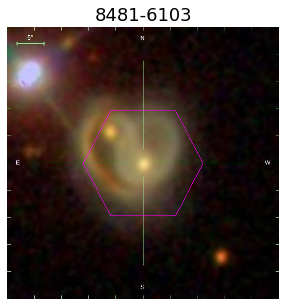

In [310]:
plaifu = '8481-6103'
MaNGA_image(plaifu)

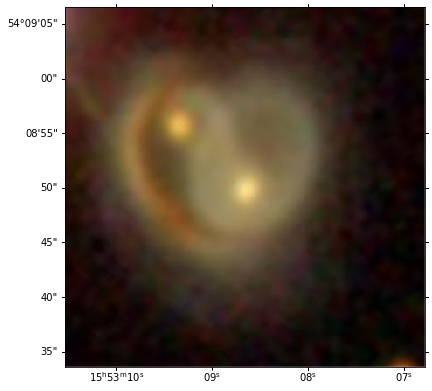

In [331]:
from marvin.tools.image import Image
im = Image('8481-6103')

im.get_new_cutout(33, 33, scale=0.08)
ax = im.plot()

(330, 330, 4)


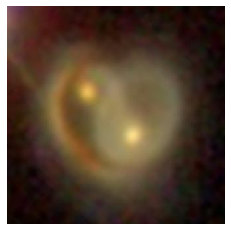

In [410]:
from PIL import Image
I = Image.open('./tmp_storage/裁剪-星系.png')
a = np.array(I)
a = a[:,10:354]
a = a[0:330,0:330]
print(a.shape)

plt.axis('off')
plt.imshow(a)
# plt.savefig("彩图.png")#, pad_inches = 0)#bbox_inches='tight',
plt.imsave('彩图.png',a)
plt.show()

(330, 330, 4)


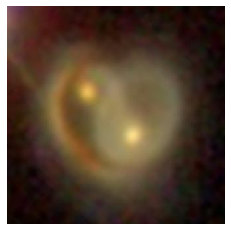

In [404]:
# 转化为 灰度图 并且 导出为 矩阵
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
a = mpimg.imread('./tmp_storage/裁剪-星系.png')
a = a[:,10:354]
a = a[0:330,0:330]
print(a.shape)

plt.axis('off')
plt.imshow(a)
plt.savefig("彩图.png")
plt.show()






大小为： (330, 330)


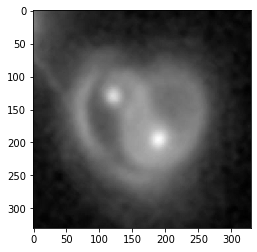

In [381]:
from PIL import Image
I = Image.open('./tmp_storage/裁剪-星系.png').convert('L')
# I.show()
# L = I.convert('L')   #转化为灰度图
# # L = I.convert('1')   #转化为二值化图
# L.show()
# I.save('./tmp_storage/裁剪-星系-灰度图.png')
a = np.array(I)
a = a[:,10:354]
a = a[0:330,0:330]
plt.imshow(a,cmap='gray')
np.savetxt("gray_galaxy.csv",a,delimiter=",",fmt='%d')
print("大小为：",a.shape)

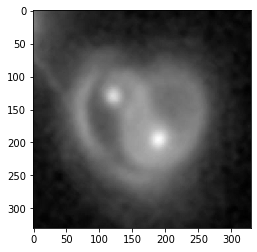

In [398]:
'''read SCV file as numpy array and plot the figure
gray_galaxy.csv: matrix of the galaxy picture.
2D gray image size: [330 x 330]
'''
import numpy as np
import matplotlib.pyplot as plt

# read SCV file
gray_galaxy = np.loadtxt("gray_galaxy.csv",# path of CSV file, such as "/我的电脑/桌面/gray_galaxy.csv"
                         delimiter=",", dtype=np.int)

# plot the figure  
plt.imshow(gray_galaxy,# array you wanna show
           cmap='gray')# control the color
plt.show()

# save the figure
plt.imsave('new_galaxy.png',gray_galaxy, cmap='gray')

In [368]:
print("%.16f"%(0.15800000123))

0.1580000012300000


### flux图函数

In [251]:
from marvin.tools import Maps
from os.path import join
# MaNGA各元素图片【Flux】
def MaNGA_element_image(plateifu, element):
    '''
    plateifu : 字符串格式，例如 '8551-3701'
    element : 字符串格式，例如 'nii_6585' 'ha_6564'
    '''
    path_marvin_maps = '/root/bash_file/manga_maps_data'
    filename = join(path_marvin_maps, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(''.join(plateifu)))
    maps = Maps(filename=filename)
    elt = getattr(maps,'emline_gflux_'+element)    # 拼接变量名称
    fig,ax,__= elt.plot(cmap='jet', log_cb=True, return_cb=True)
    fig.set_size_inches(7, 5)    # 调整大小
    ax.set_title(plateifu+' '+"flux: "+element)
    plt.show()
    return

### star-forming 图

In [12]:
# 锁定每个 spaxel 的 surface mass density 值
# 使用 firefly.fits
# datamodel: https://data.sdss.org/datamodel/files/MANGA_FIREFLY/FIREFLY_VER/manga_firefly.html
# MaNGA_plaifu = '8945-12705'
def mask_density(MaNGA_plaifu):
    firefly_fits = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
    tmp_id = (MaNGA_plaifu==firefly_fits[1].data['PLATEIFU'])
    surf_density = firefly_fits[13].data[tmp_id,:,0][0]# 2800长度
    path_marvin_maps = '/root/bash_file/manga_maps_data'
    # 使用Marvin读取数据
    filename = join(path_marvin_maps, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(MaNGA_plaifu))
    maps = Maps(filename=filename)
    ha = maps.emline_gflux_ha_6564
    image_sz = np.shape(ha)[0]    # 图像边长
    # 2800数组转为二维正方形矩阵，导出 mask
    #read in the vac file
    
    binid = firefly_fits[5].data[tmp_id,:,:][0]
    bin1d = firefly_fits[4].data[tmp_id,:,0][0]    # 获取一维的bin数据
    arr_2800 = surf_density
    # 画图
    image_sz = np.shape(ha)[0]    # 图像边长
    matrix = np.ones((image_sz,image_sz))*np.nan    # 初始化画图数组
    for i in range(image_sz):
        for j in range(image_sz):
            idbin = (bin1d==binid[i,j])    # 搜索二维bin的值在一维bin数组中的 位置
            if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
                matrix[i,j] = arr_2800[idbin]
    
    # surface mass density 筛选
    # mask_density = np.ma.array(matrix,mask=(matrix>7))
    mask_den = (matrix>7)
    return mask_den

In [34]:
import warnings
warnings.filterwarnings('ignore')    # 不显示warning信息
def plt_sf_spaxel(MaNGA_plaifu):
    # 挑选出的 spaxels
    path_marvin_maps = '/root/bash_file/manga_maps_data'
    # 使用Marvin读取数据
    filename = join(path_marvin_maps, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(MaNGA_plaifu))
    maps = Maps(filename=filename)
    ha = maps.emline_gflux_ha_6564
    image_sz = np.shape(ha)[0]    # 图像边长
    sigma_z = -ALM/2
    
    # 星系所在数组位置
    # galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))
    # idarray = np.where(manga_Z['plate-ifu'].values==MaNGA_plaifu)[0]
    mask_den = mask_density(MaNGA_plaifu)
    idarray = (manga_Z['plate-ifu'].values==MaNGA_plaifu)
    # 每个spaxel的星系中的位置以及金属丰度偏差值
    spaxel_x = manga_Z['spaxel_x'].values[idarray]
    spaxel_y = manga_Z['spaxel_y'].values[idarray]
    spaxel_z = (manga_Z['metallicity_pyqz'].values - manga_Z['metallicity_expeted'].values)[idarray]/sigma_z#0.03#sigma_z
    #spaxel_z = manga_Z['metallicity_pyqz'].values
    mtx_plt = np.ones((image_sz,image_sz))*np.nan
    for i in range(spaxel_x.size):
        mtx_plt[int(spaxel_x[i]),int(spaxel_y[i])] = spaxel_z[i]
    ## 使用 surface mass density 的mask 进行筛选
    mtx_plt = np.ma.array(mtx_plt, mask = ~mask_den)
    # 开始画图
    fig, ax = plt.subplots(figsize=(7, 5))
    cm = plt.cm.get_cmap('rainbow')
    sc = plt.imshow(mtx_plt,origin='lower',vmin=-3,vmax=3,cmap=cm)
    #sc = plt.imshow(mtx_plt,origin='lower',cmap=cm)
    fig.set_size_inches(7, 5)    # 调整大小
    plt.xlabel('spaxel',fontsize=16)    # x轴标签
    plt.ylabel('spaxel',fontsize=16)    # y轴标签
    plt.tick_params(which='both',direction='in')
    # colorbar调整
    cbar = plt.colorbar(sc)
    cbar.ax.tick_params(which='both',direction='in')
    cbar.set_label('$\Delta$log(O/H)/$\sigma_Z$',fontsize=16,labelpad=8)
    #cbar.set_label('$Metallicity_{pyqz}$',fontsize=16,labelpad=8)
    plt.title(MaNGA_plaifu,fontsize=16)
    plt.show()
    return



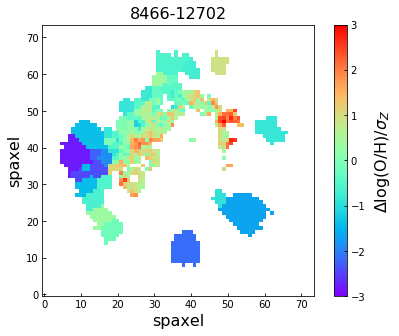

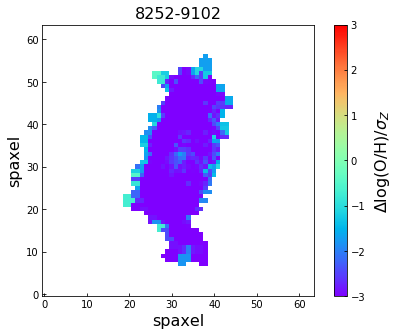

In [36]:
plt_sf_spaxel('8466-12702')
plt_sf_spaxel('8252-9102')
# plt_sf_spaxel('8250-12702')
# mask_density('8551-3701').shape

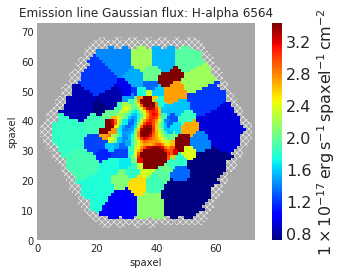

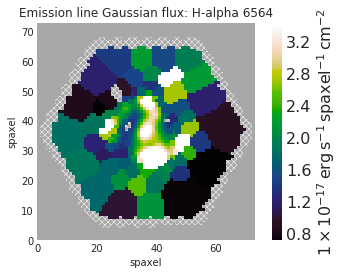

In [139]:
'''使用Marin做出每个星系的star forming区域
检查Marvin的BPT分类是否正确
'''
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot

plateifu ='8945-12705'# '8945-12705'
path_marvin_data = "/root/bash_file/marvin_vor10_fits"

maps = Maps(plateifu)
filename = join(path_marvin_data, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(plateifu))
new_maps = Maps(filename=filename)
ha = new_maps.emline_gflux_ha_6564    # 获取Hα
nii = new_maps.emline_gflux_nii_6585    # 获取Nii
oii7 = new_maps.emline_gflux_oii_3727    # 获取O
oii9 = new_maps.emline_gflux_oii_3729    # 获取O

# 计算金属丰度
RR = (oii7+oii9) / nii;    # Oii/Nii
# 论文中的关系式【LJ Kewley, MA Dopita 2002】【https://arxiv.org/pdf/astro-ph/0206495】
logRR = np.log10(1.26602*RR+0.167977*RR*RR+1.54020)
oh =  logRR + 8.93;

# 利用Marvin计算mask
masks_bpt, __, __ = new_maps.get_bpt(show_plot=False)    # 使用bpt图筛选star-forming区域
mask_non_sf = ~masks_bpt['sf']['nii'] * RR.pixmask.labels_to_value('DONOTUSE')
mask_bad_data = RR.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
min_snr = 10.
mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
mask_oii7_low_snr = (np.abs(ha.value * np.sqrt(oii7.ivar)) < min_snr)
mask_oii9_low_snr = (np.abs(ha.value * np.sqrt(oii9.ivar)) < min_snr)
new_mask = mask_non_sf | mask_bad_data | mask_nii_low_snr | mask_oii7_low_snr | mask_oii9_low_snr


# make a standard 3-plot BPT and retrieve the classifications
# masks, fig, axes = maps.get_bpt()

# save the plot
# fig.savefig('bpt.png')

# # make a BPT classification without OI
# masks, fig, axes = maps.get_bpt(use_oi=False)
ha.plot(cmap='jet')
fig, ax = mapplot.plot(dapmap=ha, value=ha.value, mask=new_mask)
# fig, ax = plt.subplots()
# tmp_ha = ha.value&new_mask
# p = ax.imshow(tmp_ha , cmap='jet',origin='lower',vmin=0.1,vmax=10,norm=mpl.colors.LogNorm())
# fig.colorbar(p)











(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb78c9a8950>)

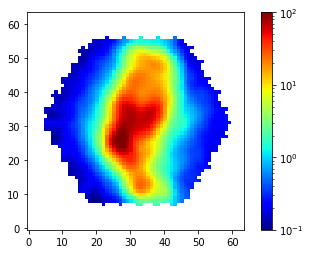

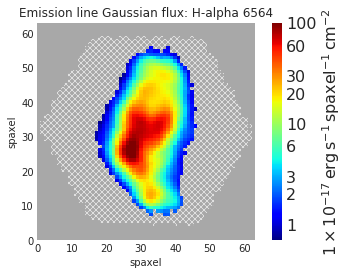

In [201]:
import matplotlib as mpl
from marvin.tools import Maps
plateifu = '8252-9102'
maps = Maps(plateifu)
ha = maps.emline_gflux_ha_6564    # 获取Hα

maps = Maps(plateifu)
new_maps = Maps(plateifu)

ha = new_maps.emline_gflux_ha_6564    # 获取Hα
nii = new_maps.emline_gflux_nii_6585    # 获取Nii
oii7 = new_maps.emline_gflux_oii_3727    # 获取O
oii9 = new_maps.emline_gflux_oii_3729    # 获取O

# 计算金属丰度
RR = (oii7+oii9) / nii;    # Oii/Nii
# 论文中的关系式【LJ Kewley, MA Dopita 2002】【https://arxiv.org/pdf/astro-ph/0206495】
logRR = np.log10(1.26602*RR+0.167977*RR*RR+1.54020)
oh =  logRR + 8.93;

# 利用Marvin计算mask
masks_bpt, __, __ = new_maps.get_bpt(show_plot=False)    # 使用bpt图筛选star-forming区域
mask_non_sf = ~masks_bpt['sf']['nii'] * RR.pixmask.labels_to_value('DONOTUSE')
mask_bad_data = RR.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
min_snr = 10.
mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
mask_oii7_low_snr = (np.abs(ha.value * np.sqrt(oii7.ivar)) < min_snr)
mask_oii9_low_snr = (np.abs(ha.value * np.sqrt(oii9.ivar)) < min_snr)
new_mask = mask_non_sf | mask_bad_data | mask_nii_low_snr | mask_oii7_low_snr | mask_oii9_low_snr

# ha.plot(cmap='jet',norm=mpl.colors.LogNorm())
fig, ax = plt.subplots()
p = ax.imshow(ha.value , cmap='jet',origin='lower',vmin=0.1,vmax=100,norm=mpl.colors.LogNorm())
fig.colorbar(p)
ha.plot(cmap='jet',mask=new_mask,log_cb=True,cbrange=(0.1,100))

In [141]:
ha.plot?

# 

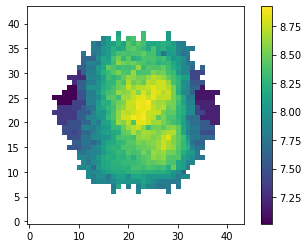

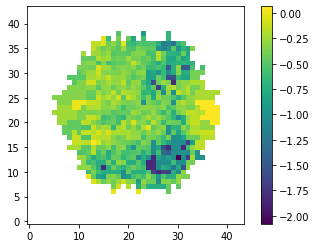

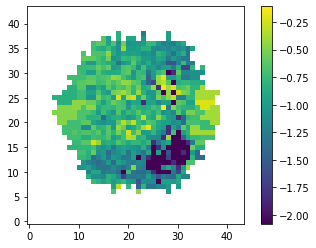

In [39]:
# 检查 bin1d == idbin 一维和二维匹配是否正确
# 锁定每个 spaxel 的 surface mass density 值
# 使用 firefly.fits
# datamodel: https://data.sdss.org/datamodel/files/MANGA_FIREFLY/FIREFLY_VER/manga_firefly.html
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from copy import copy as copy
from os.path import join
import math
import numpy as np
from marvin.tools import Maps


MaNGA_plaifu = '9883-3701'#'8551-3701'
# def tmp_count(MaNGA_plaifu):
# def mask_density(MaNGA_plaifu):
firefly_fits = fits.open('/mnt/ddnfs/data_users/yhwang/bak_la/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
# tmp_id = (MaNGA_plaifu==firefly_fits[1].data['PLATEIFU'])
tmp_id = (firefly_fits[1].data['PLATEIFU']==MaNGA_plaifu)

surf_density = firefly_fits[13].data[tmp_id,:,0][0]# 2800长度
light_metal = firefly_fits[8].data[tmp_id,:,0][0]
mass_metal = firefly_fits[9].data[tmp_id,:,0][0]

# path_marvin_maps = '/root/bash_file/manga_maps_data'
# # 使用Marvin读取数据
# filename = join(path_marvin_maps, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(MaNGA_plaifu))
# maps = Maps(filename=filename)
# ha = maps.emline_gflux_ha_6564
# image_sz = np.shape(ha)[0]    # 图像边长
# # 2800数组转为二维正方形矩阵，导出 mask
# #read in the vac file

# binid = firefly_fits[5].data[tmp_id,:,:][0]
# bin1d = firefly_fits[4].data[tmp_id,:,0][0]    # 获取一维的bin数据
# arr_2800 = surf_density
# # 画图
# image_sz = np.shape(ha)[0]    # 图像边长
# matrix = np.ones((image_sz,image_sz))*np.nan    # 初始化画图数组
# for i in range(image_sz):
#     for j in range(image_sz):
#         idbin = (bin1d==binid[i,j])    # 搜索二维bin的值在一维bin数组中的 位置
#         if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
#             matrix[i,j] = arr_2800[idbin]
#         elif len(bin1d[idbin])>1:
#             print("找到spaxel位置数组值相同！！！\n星系为%s 重复数量为：%d个 坐标为%s" % (len(bin1d[idbin]),[i,j]))
def firefly_2800tomat(plateifu,x2800):
    tmp_id = (firefly_fits[1].data['PLATEIFU']==plateifu)
    binid = firefly_fits[5].data[tmp_id,:,:][0]
    bin1d = firefly_fits[4].data[tmp_id,:,0][0]    # 获取一维的bin数据
    
    path_marvin_maps = '/root/bash_file/manga_maps_data'
    filename = join(path_marvin_maps, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(plateifu))
    maps = Maps(filename=filename)
    ha = maps.emline_gflux_ha_6564
    image_sz = np.shape(ha)[0]    # 图像边长
    matrix = np.ones((image_sz,image_sz))*np.nan    # 初始化画图数组
    for i in range(image_sz):
        for j in range(image_sz):
            idbin = (bin1d==binid[i,j])    # 搜索二维bin的值在一维bin数组中的 位置
            if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
                matrix[i,j] = x2800[idbin]
            elif len(bin1d[idbin])>1:
                raise ValueError("2800 -> matrix 出现重复匹配项。星系为: %s" % plateifu)
    return matrix

#  plt.imshow(matrix,origin='lower')
plt.imshow(firefly_2800tomat(MaNGA_plaifu,x2800=surf_density),origin='lower')

plt.colorbar()
plt.show()
plt.close()
# surface mass density 筛选
# mask_density = np.ma.array(matrix,mask=(matrix>7))
# mask_den = (matrix>7)
#     return mask_den
# tmpplt_sf_spaxel('8982-12703')

plt.imshow(firefly_2800tomat(MaNGA_plaifu,x2800=light_metal),origin='lower')

plt.colorbar()
plt.show()
plt.close()

plt.imshow(firefly_2800tomat(MaNGA_plaifu,x2800=mass_metal),origin='lower')

plt.colorbar()
plt.show()
plt.close()

[ 1.6294719e-01  1.1149149e-01  1.1168364e-01 ... -9.9990000e+03
 -9.9990000e+03 -9.9990000e+03]


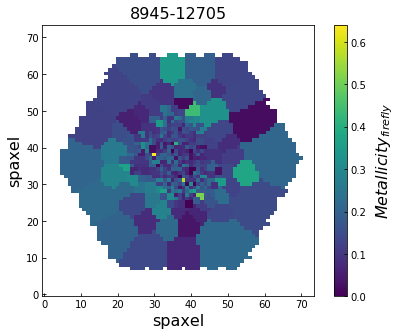

In [62]:
### firefly 得到的星系的金属丰度
# 星系编号
MaNGA_plaifu = '8945-12705'

# 读取数据
tmp_id = (firefly_fits[1].data['PLATEIFU']==MaNGA_plaifu)
light_metal = firefly_fits[8].data[tmp_id,:,0][0]
print(light_metal)
mtx_plt = firefly_2800tomat(MaNGA_plaifu,x2800=light_metal)
# 开始画图
fig, ax = plt.subplots(figsize=(7, 5))
# cm = plt.cm.get_cmap('rainbow')
sc = plt.imshow(mtx_plt,origin='lower')#,vmin=-3,vmax=3,cmap=cm)
#sc = plt.imshow(mtx_plt,origin='lower',cmap=cm)
# fig.set_size_inches(7, 5)    # 调整大小
plt.xlabel('spaxel',fontsize=16)    # x轴标签
plt.ylabel('spaxel',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = plt.colorbar(sc)
cbar.ax.tick_params(which='both',direction='in')
# cbar.set_label('$\Delta$log(O/H)/$\sigma_Z$',fontsize=16,labelpad=8)
cbar.set_label('$Metallicity_{firefly}$',fontsize=16,labelpad=8)
plt.title(MaNGA_plaifu,fontsize=16)
plt.show()
plt.close()

In [71]:

def _firefly_Z(plateifu):
    tmp_id = (plateifu==firefly_fits[1].data['PLATEIFU'])
    Z = firefly_fits[8].data[tmp_id,:,0][0]
    return Z
list(map(_firefly_Z,firefly_fits[1].data['PLATEIFU'][0:3]))

[array([-4.5908549e-01, -2.6203740e-01, -1.2110108e+00, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03], dtype=float32),
 array([ 1.8878073e-01,  1.8878073e-01,  2.1065953e-01, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03], dtype=float32),
 array([ 1.2003836e-01,  9.9861108e-02,  1.2003836e-01, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03], dtype=float32)]

In [85]:
b=a=firefly_fits[8].data[:,:,0]
a=firefly_fits[8].data[:,:,0].flatten(order='C')
a = a[(a!=-9999)&(a!=-99)]
print(a.shape,b.shape)

(1731461,) (4675, 2800)


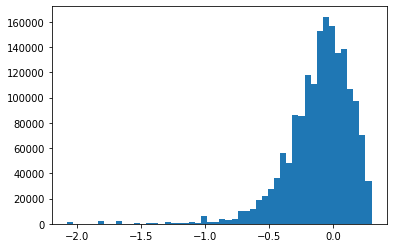

In [97]:
plt.hist(a,bins=50);

In [70]:
firefly_fits[1].data['PLATEIFU'][0:2]

chararray(['8252-12701', '8979-12701'], dtype='<U20')

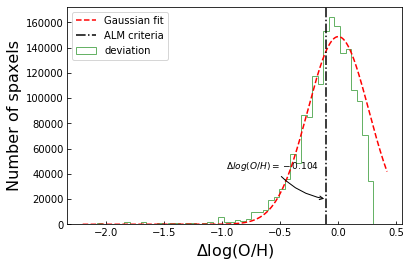

In [79]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

a=firefly_fits[8].data[:,:,0].flatten(order='C')
a = a[(a!=-9999)&(a!=-99)]
sel_Z_dev =a

# surface mass density > 7 筛选
# sel_Z_dev = sel_Z_dev[np.array(manga_den)>7]

# stellar mass > 9 筛选



# 金属丰度偏差 分布图
hist,bins,__ = plt.hist(sel_Z_dev,bins=50, alpha=0.6, color='g',histtype='step',label='deviation');
# plt.xlim([-0.45,0.45])
###################################################################################
# hist,bins = np.histogram(Z_dev,bins=150);
# 高斯拟合
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

xx = (bins[1:]-(bins[1]-bins[0])/2).copy()# 调整bin的个数及大小
yy = hist.copy()# 数量
yy = yy[np.where(xx<-0.1)]#(xx>0.02)]
xx = xx[np.where(xx<-0.1)]#(xx>0.02)]
# print('xx = ',xx,'\nyy = ',yy)
# 只需要 x>0 的部分，按照 x=0 做对称
x = np.ones(xx.size*2)*np.nan
y = np.ones(yy.size*2)*np.nan
x[0:xx.size] = -xx
x[xx.size:] = xx
y[0:yy.size] = yy
y[yy.size:] = yy
x[xx.size] = np.nan
y[yy.size] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

n = len(x)# 数据点总数
mean = sum(x)/n# 平均数
sigma = (sum((x-mean)**2)/n)**0.5# 标准差

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])# 开始拟合
xmin,xmax = plt.xlim()# 坐标轴范围
newx = np.linspace(xmin,xmax,1000)# 新的更密集的点，用来画图，更加光滑
plt.plot(newx,gaus(newx,*popt),'r--',label='Gaussian fit')# 画图
###########################################################################

# # ALM 标准
# y_exp = gaus(x,*popt)
# delta_y = y - y_exp
# delta_y = delta_y[np.where(x<-0.1)]
# x = x[np.where(x<-0.1)]
# ALM = x[np.where(delta_y==delta_y.max())]
# plt.axvline(ALM,color='black',linestyle='-.',label='ALM criteria')

# 高斯分布和实际分布的差
oldx = (bins[1:]-(bins[1]-bins[0])/2).copy()# 调整bin的个数及大小
oldy = hist.copy()# 数量
delta_y = oldy - gaus(oldx,*popt)
tmp_crit = -0.1
delta_y = delta_y[np.where(oldx<tmp_crit)]
oldx = oldx[np.where(oldx<tmp_crit)]
ALM = oldx[np.where(delta_y==delta_y.max())]
plt.axvline(ALM,color='black',linestyle='-.',label='ALM criteria')
# plt.plot(oldx,delta_y,'k--')# 画图

plt.tick_params(which='both',direction='in')
plt.legend(loc='best')
plt.xlabel('$\Delta$log(O/H)',fontsize=16)
plt.ylabel('Number of spaxels',fontsize=16)
plt.annotate(r'$\Delta log(O/H)=%.3f$' % ALM, xy=(ALM, 20000), xycoords='data', xytext=(-100, +30),
             textcoords='offset points', fontsize=9,
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2"))
plt.show()

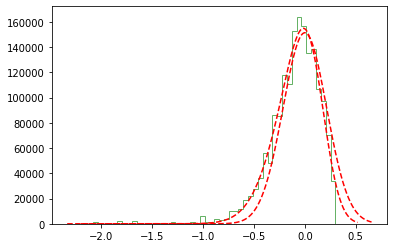

In [80]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy import stats
a=firefly_fits[8].data[:,:,0].flatten(order='C')
a = a[(a!=-9999)&(a!=-99)]
sel_Z_dev =a
# 金属丰度偏差 分布图
hist,bins,__ = plt.hist(sel_Z_dev,bins=50, alpha=0.6, color='g',histtype='step',label='deviation');

# 偏态分布【plus=0就是正态分布】
def gaus_plus(x,a,x0,sigma,plus):
    fit_result = a*stats.skewnorm.pdf((x-x0)/sigma, plus)
    return fit_result

x = (bins[1:]-(bins[1]-bins[0])/2).copy()# 调整bin的个数及大小
y = hist.copy()# 数量

n = len(x)# 数据点总数
mean = sum(x)/n# 平均数
sigma = (sum((x-mean)**2)/n)**0.5# 标准差
a = np.max(y)

popt,pcov = curve_fit(gaus_plus,x,y,p0=[a,mean,sigma,0])
xmin,xmax = plt.xlim()# 坐标轴范围
newx = np.linspace(xmin,xmax+0.1,1000)# 新的更密集的点，用来画图，更加光滑
plt.plot(newx,gaus_plus(newx,*popt),'r--',label='Gaussian fit')# 画图

# 高斯拟合
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

xx = newx
yy = gaus_plus(newx,*popt)
yy = yy[np.where(xx>mean)]#(xx>0.02)]
xx = xx[np.where(xx>mean)]#(xx>0.02)]
# print('xx = ',xx,'\nyy = ',yy)
# 只需要 x>0 的部分，按照 x=0 做对称
x = np.ones(xx.size*2)*np.nan
y = np.ones(yy.size*2)*np.nan
x[0:xx.size] = -xx
x[xx.size:] = xx
y[0:yy.size] = yy
y[yy.size:] = yy
x[xx.size] = np.nan
y[yy.size] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

n = len(x)# 数据点总数
mean = sum(x)/n# 平均数
sigma = (sum((x-mean)**2)/n)**0.5# 标准差

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])# 开始拟合
xmin,xmax = plt.xlim()# 坐标轴范围
newx = np.linspace(xmin,xmax,1000)# 新的更密集的点，用来画图，更加光滑
plt.plot(newx,gaus(newx,*popt),'r--',label='Gaussian fit')# 画图
###########################################################################
plt.show()
plt.close()

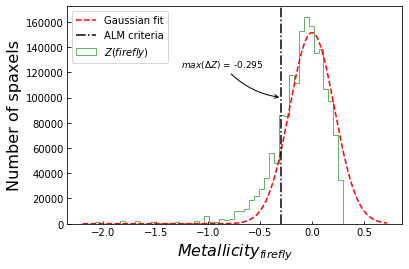

In [105]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy import stats
a=firefly_fits[8].data[:,:,0].flatten(order='C')
a = a[(a!=-9999)&(a!=-99)]
sel_Z_dev =a
# 金属丰度偏差 分布图
hist,bins,__ = plt.hist(sel_Z_dev,bins=50, alpha=0.6, color='g',histtype='step',label='$Z (firefly)$');

# 偏态分布【plus=0就是正态分布】
def gaus_plus(x,a,x0,sigma,plus):
    fit_result = a*stats.skewnorm.pdf((x-x0)/sigma, plus)
    return fit_result

x = (bins[1:]-(bins[1]-bins[0])/2).copy()# 调整bin的个数及大小
y = hist.copy()# 数量

n = len(x)# 数据点总数
mean = sum(x)/n# 平均数
sigma = (sum((x-mean)**2)/n)**0.5# 标准差
a = np.max(y)

popt,pcov = curve_fit(gaus_plus,x,y,p0=[a,mean,sigma,0])
xmin,xmax = plt.xlim()# 坐标轴范围
newx = np.linspace(xmin,xmax+0.1,1000)# 新的更密集的点，用来画图，更加光滑
# plt.plot(newx,gaus_plus(newx,*popt),'r--',label='Gaussian fit')# 画图

# 高斯拟合
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

xx = newx
yy = gaus_plus(newx,*popt)
yy = yy[np.where(xx>mean)]#(xx>0.02)]
xx = xx[np.where(xx>mean)]#(xx>0.02)]
# print('xx = ',xx,'\nyy = ',yy)
# 只需要 x>0 的部分，按照 x=0 做对称
x = np.ones(xx.size*2)*np.nan
y = np.ones(yy.size*2)*np.nan
x[0:xx.size] = -xx
x[xx.size:] = xx
y[0:yy.size] = yy
y[yy.size:] = yy
x[xx.size] = np.nan
y[yy.size] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]

n = len(x)# 数据点总数
mean = sum(x)/n# 平均数
sigma = (sum((x-mean)**2)/n)**0.5# 标准差

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])# 开始拟合
xmin,xmax = plt.xlim()# 坐标轴范围
newx = np.linspace(xmin,xmax+0.3,1000)# 新的更密集的点，用来画图，更加光滑
plt.plot(newx,gaus(newx,*popt),'r--',label='Gaussian fit')# 画图

# 高斯分布和实际分布的差
oldx = (bins[1:]-(bins[1]-bins[0])/2).copy()# 调整bin的个数及大小
oldy = hist.copy()# 数量
delta_y = oldy - gaus(oldx,*popt)
tmp_crit = -0.1
delta_y = delta_y[np.where(oldx<tmp_crit)]
oldx = oldx[np.where(oldx<tmp_crit)]
ALM = oldx[np.where(delta_y==delta_y.max())]
plt.axvline(ALM,color='black',linestyle='-.',label='ALM criteria')
# plt.plot(oldx,delta_y,'k--')# 画图

plt.tick_params(which='both',direction='in')
plt.legend(loc='best')
plt.xlabel('$Metallicity_{firefly}$',fontsize=16)
plt.ylabel('Number of spaxels',fontsize=16)
plt.annotate(r'$max(\Delta Z)$ = %.3f' % ALM, xy=(ALM, 100000), xycoords='data', xytext=(-100, +30),
             textcoords='offset points', fontsize=9,
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2"))
###########################################################################
plt.show()
plt.close()

In [ ]:
# 高斯分布和实际分布的差
oldx = (bins[1:]-(bins[1]-bins[0])/2).copy()# 调整bin的个数及大小
oldy = hist.copy()# 数量
delta_y = oldy - gaus(oldx,*popt)
tmp_crit = -0.2
delta_y = delta_y[np.where(oldx<tmp_crit)]
oldx = oldx[np.where(oldx<tmp_crit)]
ALM = oldx[np.where(delta_y==delta_y.max())]
plt.axvline(ALM,color='black',linestyle='-.',label='ALM criteria')
# plt.plot(oldx,delta_y,'k--')# 画图

plt.tick_params(which='both',direction='in')
plt.legend(loc='best')
plt.xlabel('$\Delta$log(O/H)',fontsize=16)
plt.ylabel('Number of spaxels',fontsize=16)
plt.annotate(r'$\Delta log(O/H)=%.3f$' % ALM, xy=(ALM, 20000), xycoords='data', xytext=(-100, +30),
             textcoords='offset points', fontsize=9,
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2"))
plt.show()

In [ ]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy import stats

# 偏态分布【plus=0就是正态分布】
def gaus_plus(x,a,x0,sigma,plus):
    fit_result = a*stats.skewnorm.pdf((x-x0)/sigma, plus)
    return fit_result

# 分组，寻找 金属丰度预期值
def peak_Z(mass,density):
    if mass>10.25:
        sel_mass = (stellar_mass>=mass-0.25)
    elif mass>0:
        sel_mass = (stellar_mass>=mass-0.25)&(stellar_mass<=mass+0.25)
    else:
        raise ValueError("value of stellar mass wrong")
    sel_density = (mass_density>=density-0.1)&(mass_density<=density+0.1)
    sel_Z = manga_Z['metallicity_pyqz'].values[sel_mass&sel_density]
    
    bins = int((np.max(sel_Z)-np.min(sel_Z))/0.05)+1  # 避免出现最大值和最小值一样的情况
    if bins==1:
        return np.max(sel_Z)
    else:
        # 直方图分布
        hist_y,bins_x = np.histogram(sel_Z,bins=bins)
        #hist,bins,__ = plt.hist(fix_Z,bins=int(((np.max(fix_Z)-np.min(fix_Z))/0.05)+1),alpha=0.7, color='g',label='data');
        
        # 拟合
        x = bins_x[1:]-(bins_x[1]-bins_x[0])/2  # 去掉左端值，并且向右侧平移半格
        y = hist_y
        n = len(x)  # 数据点个数
        mean = sum(x)/n  # 金属丰度平均值
        sigma = (sum((x-mean)**2)/n)**0.5
        a = np.max(y)
        
        # 若拟合失败，则返回平均值
        try:
            popt,pcov = curve_fit(gaus_plus,x,y,p0=[a,mean,sigma,0])
        except:
            return mean
        
        # 找peak
        newx = np.linspace(x.min(),x.max(),3000)
        newy = gaus_plus(newx,*popt)
        expcted_Z = newx[np.where(newy==newy.max())[0]][0]
        return expcted_Z

# new_exp_Z = [peak_Z(mass,density)for mass,density in zip(stellar_mass[0:100], mass_density[0:100])]
# print(new_exp_Z)

In [25]:
# 8481-6103 星系，MAPS-HYB10-GAU-MILESHC 不存在
firefly_fits = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')

def tmp_count(MaNGA_plaifu):
    tmp_id = (firefly_fits[1].data['PLATEIFU']==MaNGA_plaifu)
    surf_density = firefly_fits[8].data[tmp_id,:,0][0]    # 选取的物理量，2800长度
    bin2d = firefly_fits[5].data[tmp_id,:,:][0]    # 二维矩阵数组，定位
    bin1d = firefly_fits[4].data[tmp_id,:,0][0]    # 获取一维2800位置数组

    # 使用Marvin读取数据
    path_marvin_maps = '/root/bash_file/marvin_vor10_fits'
    filename = join(path_marvin_maps, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(MaNGA_plaifu))
    maps = Maps(filename=filename)
    ha = maps.emline_gflux_ha_6564

    image_sz = np.shape(ha)[0]    # 图像边长
    arr_2800 = surf_density    # 赋给循环中的数组
    # 画图
    image_sz = np.shape(ha)[0]    # 图像边长
    matrix = np.ones((image_sz,image_sz))*np.nan    # 初始化画图数组
    for i in range(image_sz):
        for j in range(image_sz):
            idbin = (bin1d==bin2d[i,j])    # 搜索二维bin的值在一维bin数组中的 位置
            if 10>len(bin1d[idbin])>1:
                print("找到spaxel位置数组值相同！！！\n星系为%s 重复数量为：%d个 坐标为%s" % (MaNGA_plaifu,len(bin1d[idbin]),[i,j]))
    return
list(map(tmp_count,firefly_fits[1].data['PLATEIFU'][0:2]))

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.FileIO name='/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits' mode='rb' closefd=True>
  


[None, None]

In [52]:
a = [[1,2],[2,3,4],[6,7,4,6]]
[x for i in a for x in i]

[1, 2, 2, 3, 4, 6, 7, 4, 6]

In [338]:
# 获取星系的 质量，红移参数
firefly_fits = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
plifu = '8481-6103'

red = firefly_fits[1].data['REDSHIFT'][(firefly_fits[1].data['PLATEIFU']==plifu)][0]
mass = firefly_fits[1].data['PHOTOMETRIC_MASS'][(firefly_fits[1].data['PLATEIFU']==plifu)][0]
print("redshift = %f\nmass = %f" % (red,mass))
# firefly_fits[13].data[(firefly_fits[1].data['PLATEIFU']==plifu),x2800,0][0]

redshift = 0.047306
mass = 39694700544.000000


In [344]:
# 读取 星系半径
path_drpall = '/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits'
drpall = fits.open(path_drpall)
drpall[1].data['NSA_ELPETRO_TH50_R'][drpall[1].data['PLATEIFU']==plifu]


array([6.03763])

In [ ]:
# 每个 spaxel 的 surface mass density
# 8481-6103 星系，MAPS-HYB10-GAU-MILESHC 不存在
firefly_fits = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')

def tmp_count(MaNGA_plaifu):
    tmp_id = (firefly_fits[1].data['PLATEIFU']==MaNGA_plaifu)
    surf_density = firefly_fits[8].data[tmp_id,:,0][0]    # 选取的物理量，2800长度
    bin2d = firefly_fits[5].data[tmp_id,:,:][0]    # 二维矩阵数组，定位
    bin1d = firefly_fits[4].data[tmp_id,:,0][0]    # 获取一维2800位置数组

    # 使用Marvin读取数据
    path_marvin_maps = '/root/bash_file/marvin_vor10_fits'
    filename = join(path_marvin_maps, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(MaNGA_plaifu))
    maps = Maps(filename=filename)
    ha = maps.emline_gflux_ha_6564

    image_sz = np.shape(ha)[0]    # 图像边长
    arr_2800 = surf_density    # 赋给循环中的数组
    # 画图
    image_sz = np.shape(ha)[0]    # 图像边长
    matrix = np.ones((image_sz,image_sz))*np.nan    # 初始化画图数组
    for i in range(image_sz):
        for j in range(image_sz):
            idbin = (bin1d==bin2d[i,j])    # 搜索二维bin的值在一维bin数组中的 位置
            if 10>len(bin1d[idbin])>1:
                print("找到spaxel位置数组值相同！！！\n星系为%s 重复数量为：%d个 坐标为%s" % (MaNGA_plaifu,len(bin1d[idbin]),[i,j]))
    return
list(map(tmp_count,firefly_fits[1].data['PLATEIFU']))


In [ ]:
tmp_id = (firefly_fits[1].data['PLATEIFU']==plifu);firefly_fits[13].data[tmp_id,:,0][0]

[mg_den for plifu,x2800 in manga_Z['plate-ifu'][0:3],manga_Z['plate-ifu'][0:3]]

### surface mass denstiy

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from copy import copy as copy
from os.path import join
from marvin.tools import Maps
import warnings
# warnings.filterwarnings('ignore')    # 不显示warning信息

manga_Z = pd.read_pickle("./tmp_storage/MaNGA_Z.pd.pkl")

In [92]:
# plt.hist(manga_Z['bin_id_2800'],bins=20)
# firefly_fits[13].data[(firefly_fits[1].data['PLATEIFU']==plifu),x2800,0][0]
manga_den = [
    firefly_fits[13].data[(firefly_fits[1].data['PLATEIFU']==plifu),x2800,0][0]\
 for plifu,x2800 in zip(manga_Z['plate-ifu'],\
                        manga_Z['bin_id_2800'])
]
# print(manga_den)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
'''【并行版本】每个spaxel的surface mass density
'''
def _manga_den(plateifu,x2800):
    return sur_density

def _mass_density(plateifu,x2800):
    density = firefly_fits[13].data[(firefly_fits[1].data['PLATEIFU']==plateifu),x2800,0][0]
    return density


# 开始并行
pool = Pool()

manga_den = pool.map(_stellar_mass, manga_Z['plate-ifu'])

x = manga_Z['plate-ifu']
y =  manga_Z['bin_id_2800']
zip_args = list(zip(x, y))
mass_density = pool.starmap(_mass_density, zip_args)

pool.close()
pool.join()

(array([1.5000e+02, 8.5800e+02, 3.2220e+03, 3.1370e+03, 6.5730e+03,
        9.8850e+03, 2.1102e+04, 4.7002e+04, 6.5827e+04, 7.8394e+04,
        7.5764e+04, 8.4787e+04, 8.9654e+04, 7.9678e+04, 5.5862e+04,
        2.9252e+04, 1.1216e+04, 3.0760e+03, 5.7500e+02, 8.4000e+01]),
 array([5.473708 , 5.6689615, 5.864215 , 6.0594683, 6.2547216, 6.449975 ,
        6.645229 , 6.840482 , 7.0357356, 7.230989 , 7.4262424, 7.6214957,
        7.816749 , 8.012003 , 8.207256 , 8.40251  , 8.597763 , 8.793016 ,
        8.98827  , 9.183523 , 9.378777 ], dtype=float32),
 <a list of 20 Patch objects>)

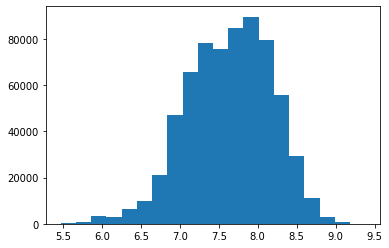

In [96]:
plt.hist(np.array(manga_den),bins=20)

In [62]:
manga_Z

plate-ifu  array_id  bin_id_2800  spaxel_x  spaxel_y  \
0       8252-12701         0           17        27        28   
1       8252-12701         0           17        28        28   
2       8252-12701         0           17        28        29   
3       8252-12701         0           17        28        30   
4       8252-12701         0           17        28        31   
...            ...       ...          ...       ...       ...   
666093  8485-12704      4674           84        53        36   
666094  8485-12704      4674           84        53        37   
666095  8485-12704      4674           84        53        38   
666096  8485-12704      4674           84        53        39   
666097  8485-12704      4674           84        54        37   

        metallicity_pyqz  metallicity_expeted  
0               7.934875             8.423054  
1               7.934875             8.423054  
2               7.934875             8.423054  
3               7.934875             8.423054  
4               7.934875             8.423054  
...                  ...                  ...  
666093          8.369295             8.427856  
666094          8.369295             8.427856  
666095          8.369295             8.427856  
666096          8.369295             8.427856  
666097          8.369295             8.427856  

[666098 rows x 7 columns]

### stellar mass

In [233]:
'''获取 MaNGA_Z spaxel数组所对应的 stellar mass
使用 list comprehension方法'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
# warnings.filterwarnings('ignore')    # 不显示warning信息

# 读取 MaNGA_Z 数组【pandas格式】
manga_Z = pd.read_pickle("./tmp_storage/MaNGA_Z.pd.pkl")

# 使用 CL 方法替代for循环、map迭代
# manga_Z_mass = [
#     firefly_fits[11].data[(firefly_fits[1].data['PLATEIFU']==plifu),x2800,0][0]\
#  for plifu,x2800 in zip(manga_Z['plate-ifu'],\
#                         manga_Z['bin_id_2800'])
# ]
manga_Z_mass = [
    firefly_fits[1].data['PHOTOMETRIC_MASS'][firefly_fits[1].data['PLATEIFU']==plifu][0]\
    for plifu in manga_Z['plate-ifu']
]

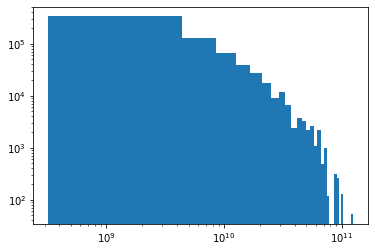

In [235]:
# 检查数组
plt.hist(np.array(manga_Z_mass),bins=30);
plt.xscale('log')
plt.yscale('log')
plt.show()


original =  (4675,)
after selected =  (4673,)


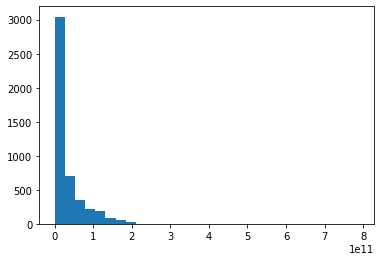

9694710.0


In [175]:
a = firefly_fits[1].data['PHOTOMETRIC_MASS']
print("original = ",np.shape(a))
a = a[a>6]
print("after selected = ",np.shape(a))
plt.hist(a,bins=30)
plt.show()
print(a.min())

In [174]:
np.shape(firefly_fits[1].data['PHOTOMETRIC_MASS'])

(4675,)

In [114]:
# MaNGA和nsa的匹配数组【已经去除重复匹配星系】
manga_match_nsa = np.loadtxt("./tmp_storage/MaNGA_match_nsa.dat")
manga_match_nsa = manga_match_nsa.astype(int)
# 读取MaNGA的fits文件
manga_fits = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic_manga = copy(manga_fits[1].data)
# 读取 NASA-Sloan catalog v1 0 1 fits文件
nsa_fits = fits.open('/root/cosmos/data/nsa_v1_0_1.fits')

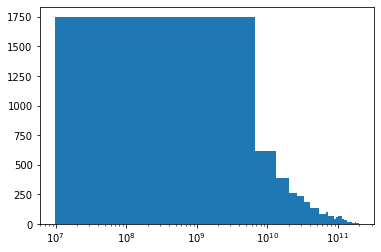

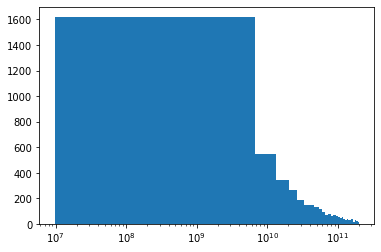

In [140]:
basic_nsa = nsa_fits[1].data
# 星系质量 stellar mass
nsa_mass1 = copy(basic_nsa['ELPETRO_MASS'])
nsa_mass2 = copy(basic_nsa['SERSIC_MASS'])
nsaID = copy(basic_nsa['IAUNAME'])
nsa_mass1 = nsa_mass1[manga_match_nsa[:,1]]
nsa_mass1 = nsa_mass1[(nsa_mass1<2*10**11)&(nsa_mass1>10**1)]
nsa_mass2 = nsa_mass2[manga_match_nsa[:,1]]

bins = plt.hist(nsa_mass1,bins=30)[1]
plt.xscale('log')
plt.show()
plt.hist(nsa_mass2,bins=bins)
plt.xscale('log')
plt.show()

In [143]:
nsaID = copy(basic_nsa['IAUNAME'])
print("original: ",np.shape(nsaID))
print("remove repeated: ",np.shape(np.unique(nsaID)))


original:  (641409,)
remove repeated:  (641409,)


In [150]:
path_drpall = '/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits'
drpall = fits.open(path_drpall)
tbdata = drpall[1].data

# 读取存储数据的信息标签
# # Print column names
# np.shape(tbdata.columns.names)
# drpall[1].header

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.FileIO name='/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits' mode='rb' closefd=True>
  


XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1340 / length of dimension 1                          
NAXIS2  =                11465 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   99 / number of table fields                         
TTYPE1  = 'plate   '                                                            
TFORM1  = 'K       '                                                            
TTYPE2  = 'ifudsgn '                                                            
TFORM2  = '21A     '                                                            
TTYPE3  = 'plateifu'        

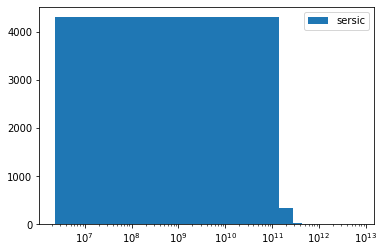

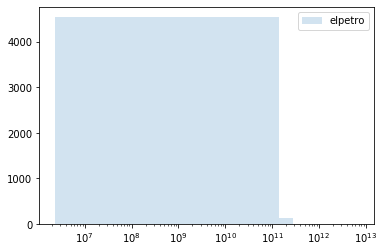

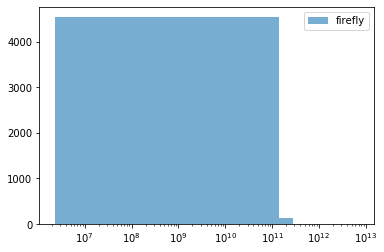

In [182]:
# NSA_SERSIC_MASS
# NSA_ELPETRO_MASS
nsa_smass =  drpall[1].data['NSA_SERSIC_MASS']
nsa_smass =  nsa_smass[nsa_smass>-6]  # remove useless data
nsa_emass =  drpall[1].data['NSA_ELPETRO_MASS']
nsa_emass =  nsa_emass[nsa_emass>-6]  # remove useless data
# print(np.shape(nsa_smass[nsa_smass>-6]))
# np.min(nsa_smass)
bins=plt.hist(nsa_smass,bins=50,label='sersic')[1]
plt.xscale('log')
plt.legend(loc='best')
plt.show()

plt.hist(nsa_emass,bins=bins,alpha=0.2,label='elpetro')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

firefly_mass = firefly_fits[1].data['PHOTOMETRIC_MASS']
plt.hist(firefly_mass,bins=bins,alpha=0.6,label='firefly')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

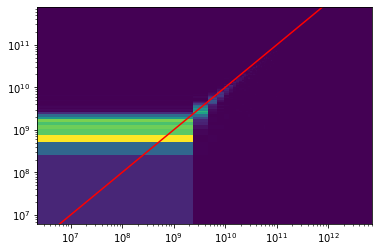

In [191]:
nsa_smass =  drpall[1].data['NSA_SERSIC_MASS']
nsa_emass =  drpall[1].data['NSA_ELPETRO_MASS']
# remove useless data
tmp_valid = 10**5
nsa_smass =  nsa_smass[nsa_emass>tmp_valid]  
nsa_emass =  nsa_emass[nsa_emass>tmp_valid]
nsa_emass =  nsa_emass[nsa_smass>tmp_valid]
nsa_smass =  nsa_smass[nsa_smass>tmp_valid]  


# plt.subplot(132)
#plt.figure(figsize=(7,7))
yy=np.linspace(0,10**12,10**6)
plt.plot(yy,yy,color = 'r')

plt.hist2d(nsa_smass,nsa_emass,bins=(3000,3000));
plt.xscale('log')
plt.yscale('log')

# plt.xlabel("manga_ra",fontsize = 18)
# plt.ylabel("nair_ra",fontsize = 18)
# plt.title("nair_ra vs. manga_ra",fontsize = 18)

In [210]:
# 按照每个 plate-ifu ，找出其 stellar mass
# plt.hist(manga_Z['bin_id_2800'],bins=20)
# firefly_fits[13].data[(firefly_fits[1].data['PLATEIFU']==plifu),x2800,0][0]
drpall[1].data['PLATEIFU']

nsa_smass = [
    drpall[1].data['NSA_SERSIC_MASS'][(drpall[1].data['PLATEIFU']==plifu)][0]\
    for plifu in firefly_fits[1].data['PLATEIFU']
]
nsa_emass = [
    drpall[1].data['NSA_ELPETRO_MASS'][(drpall[1].data['PLATEIFU']==plifu)][0]\
    for plifu in firefly_fits[1].data['PLATEIFU']
]
# print(manga_den)

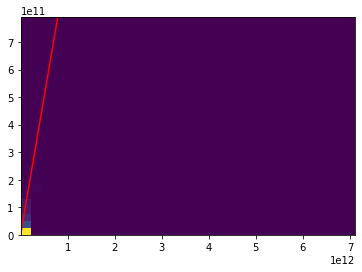

In [231]:
# nsa_emass = np.array(nsa_emass)
# nsa_smass = np.array(nsa_smass)
# # remove useless data
# tmp_valid = 10**1
# nsa_smass =  nsa_smass[nsa_emass>tmp_valid]  
# nsa_emass =  nsa_emass[nsa_emass>tmp_valid]
# nsa_emass =  nsa_emass[nsa_smass>tmp_valid]
# nsa_smass =  nsa_smass[nsa_smass>tmp_valid] 

yy=np.linspace(0,10**12,10**6)
plt.plot(yy,yy,color = 'r')

plt.hist2d(nsa_smass,nsa_emass,bins=(30,30));
# plt.xscale('log')
# plt.yscale('log')
plt.show()

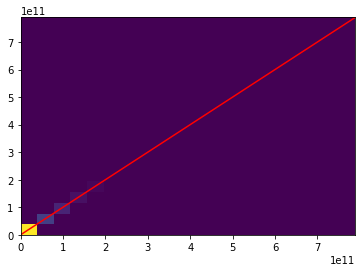

In [230]:
firefly_mass = firefly_fits[1].data['PHOTOMETRIC_MASS']

yy=np.linspace(0,10**12,10**6)
plt.plot(yy,yy,color = 'r')

plt.hist2d(firefly_mass.astype('int'),np.array(nsa_emass).astype('int'),bins=(20,20));
# plt.xscale('log')
# plt.yscale('log')
plt.show()


# np.shape(nsa_emass)

In [232]:
print(firefly_mass[666:675].astype('int'))
print(np.array(nsa_emass[666:675]).astype('int'))
print(nsa_smass[666:675])

[ 35853701120  14577999872   1116989952  82679799808 157977001984
 585945972736   8463329792   4663499776  17764700160]
[ 35853700000  14578000000   1116990000  82679800000 157977000000
 585946000000   8463330000   4663500000  17764700000]
[63397700000.0, 17696200000.0, 1326040000.0, 98811600000.0, 216440000000.0, 915778000000.0, 10999900000.0, 5245460000.0, 18867500000.0]


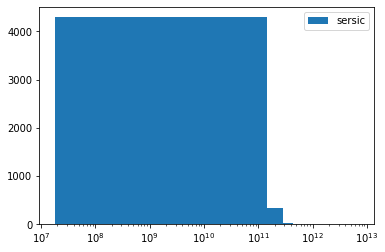

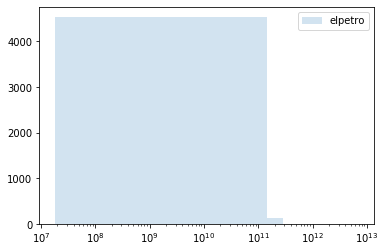

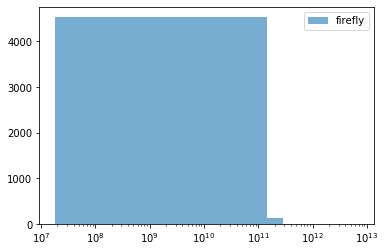

In [215]:
bins=plt.hist(nsa_smass,bins=50,label='sersic')[1]
plt.xscale('log')
plt.legend(loc='best')
plt.show()

plt.hist(nsa_emass,bins=bins,alpha=0.2,label='elpetro')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

firefly_mass = firefly_fits[1].data['PHOTOMETRIC_MASS']
plt.hist(firefly_mass,bins=bins,alpha=0.6,label='firefly')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

### ALM spaxel 图

In [13]:
# 按照 ALM 条件 筛选出的 spaxels

import warnings
# warnings.filterwarnings('ignore')    # 不显示warning信息
def plt_ALM_spaxel(MaNGA_plaifu):
    # 挑选出的 spaxels
    path_marvin_maps = '/root/bash_file/manga_maps_data'
    # 使用Marvin读取数据
    filename = join(path_marvin_maps, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(MaNGA_plaifu))
    maps = Maps(filename=filename)
    ha = maps.emline_gflux_ha_6564
    image_sz = np.shape(ha)[0]    # 图像边长
    sigma_z = -ALM/2
    
    # 星系所在数组位置
    # galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))
    # idarray = np.where(manga_Z['plate-ifu'].values==MaNGA_plaifu)[0]
    mask_den = mask_density(MaNGA_plaifu)
    idarray = (manga_Z['plate-ifu'].values==MaNGA_plaifu)
    # 每个spaxel的星系中的位置以及金属丰度偏差值
    spaxel_x = manga_Z['spaxel_x'].values[idarray]
    spaxel_y = manga_Z['spaxel_y'].values[idarray]
    spaxel_z = (manga_Z['metallicity_pyqz'].values - manga_Z['metallicity_expeted'].values)[idarray]/sigma_z#0.03#sigma_z
    spaxel_z[np.where(spaxel_z>-2)]=np.nan
    mtx_plt = np.ones((image_sz,image_sz))*np.nan
    #for i in range(spaxel_x.size):
    for i in range(image_sz):
        mtx_plt[int(spaxel_x[i]),int(spaxel_y[i])] = spaxel_z[i]
    # 使用 surface mass density 的mask 进行筛选
    mtx_plt = np.ma.array(mtx_plt, mask = ~mask_den)
    # 开始画图
    cm = plt.cm.get_cmap('rainbow')
    sc = plt.imshow(mtx_plt,origin='lower',vmin=-3,vmax=3,cmap=cm)
    plt.xlabel('spaxel',fontsize=16)    # x轴标签
    plt.ylabel('spaxel',fontsize=16)    # y轴标签
    plt.tick_params(which='both',direction='in')
    # colorbar调整
    cbar = plt.colorbar(sc)
    cbar.ax.tick_params(which='both',direction='in')
    cbar.set_label('$\Delta$log(O/H)/$\sigma_Z$',fontsize=16,labelpad=8)
    plt.title(MaNGA_plaifu,fontsize=16)
    plt.show()
    return




/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: ResourceWarning: unclosed file <_io.FileIO name='/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits' mode='rb' closefd=True>


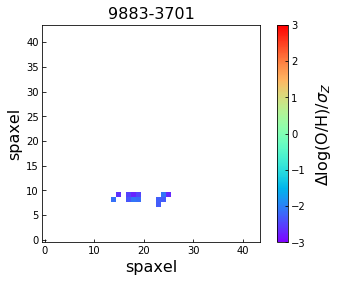

In [16]:
plt_ALM_spaxel('9883-3701')

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: ResourceWarning: unclosed file <_io.FileIO name='/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits' mode='rb' closefd=True>


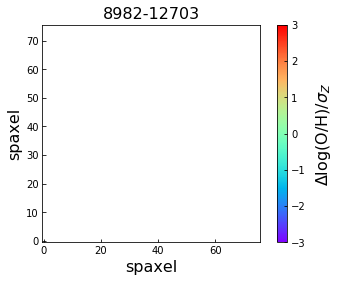

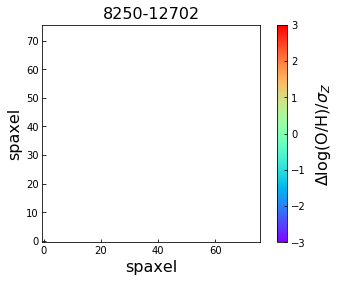

In [14]:
plt_ALM_spaxel('8982-12703')
plt_ALM_spaxel('8250-12702')

#### 星系 '8982-12703' '8250-12702' 出问题
可以统计到 ALM spaexl，但是图却是空的？？？   
> `因为它们的 surface mass density < 7`

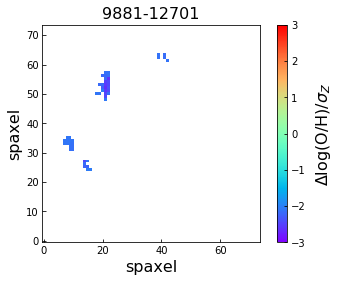

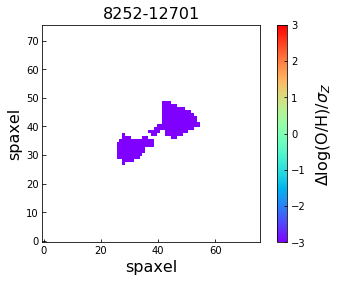

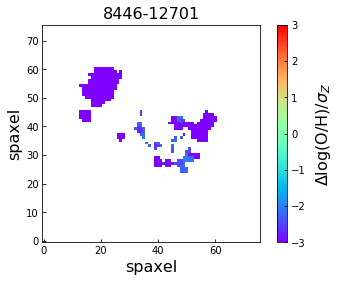

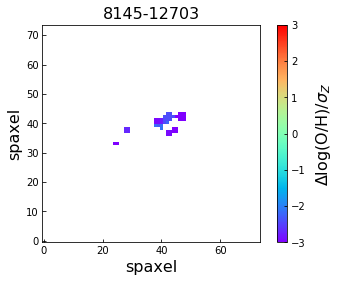

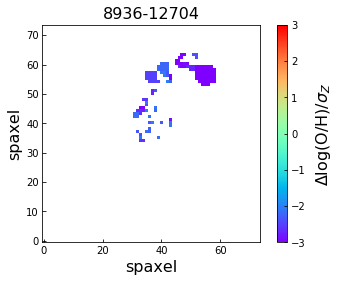

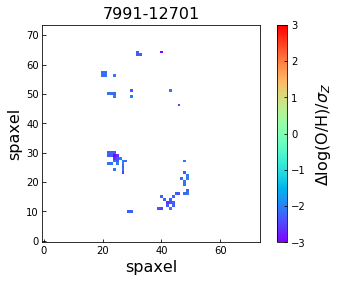

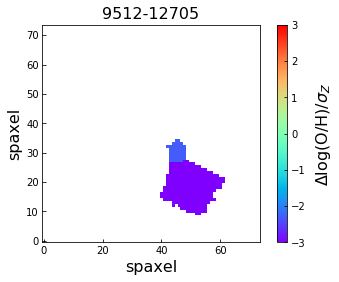

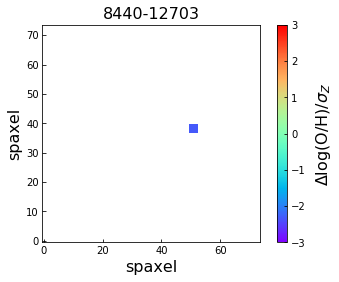

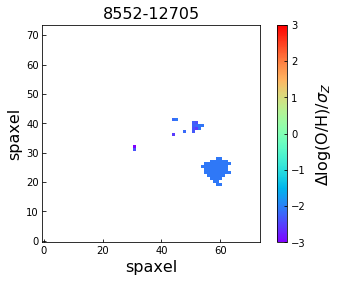

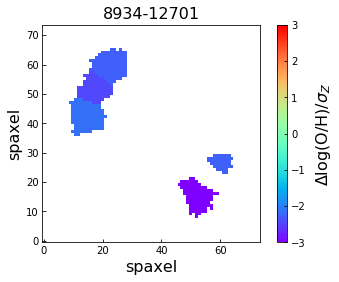

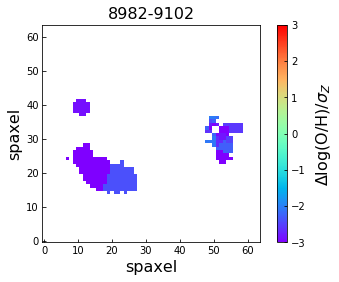

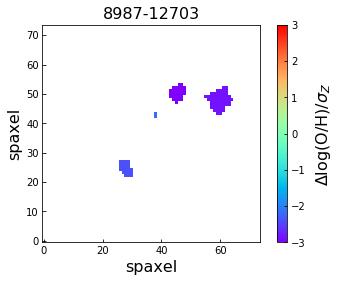

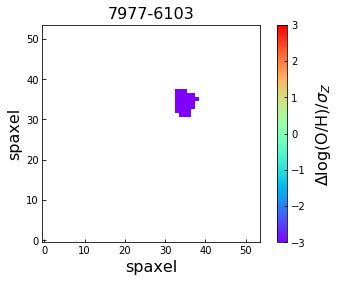

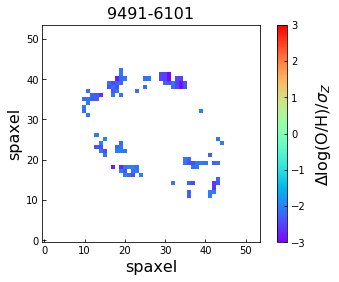

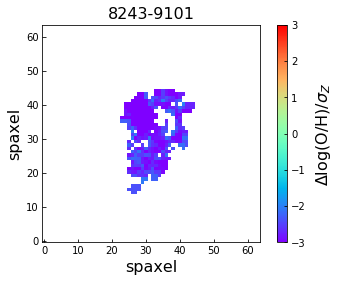

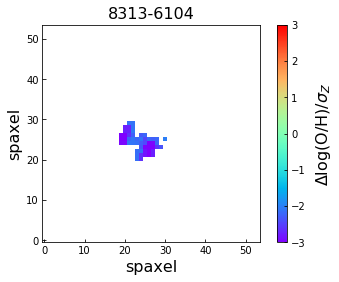

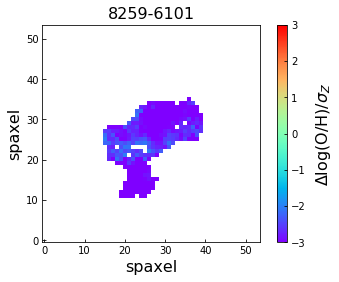

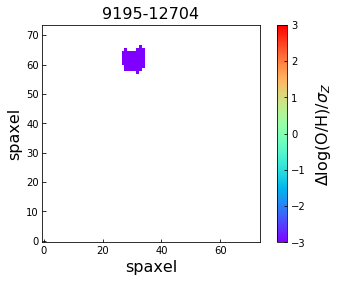

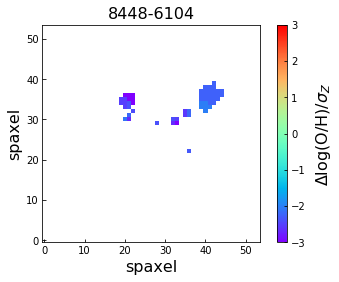

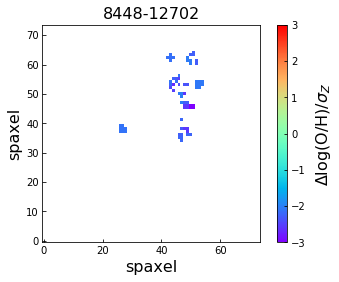

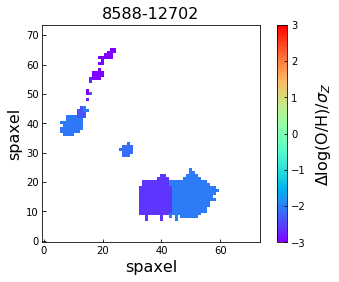

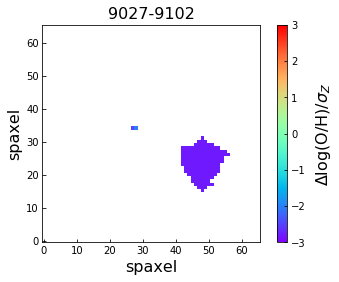

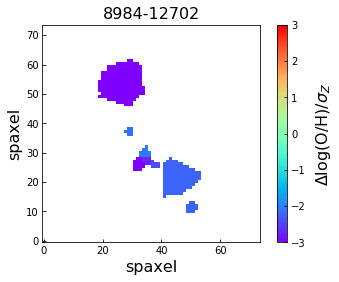

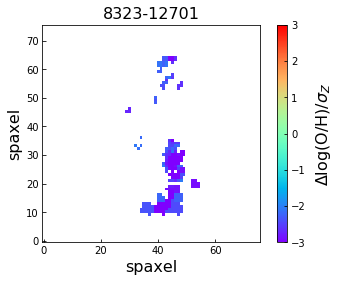

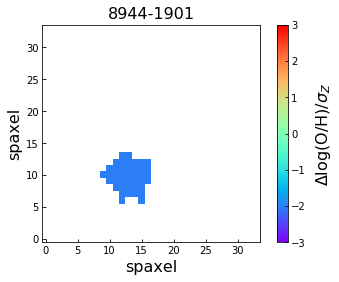

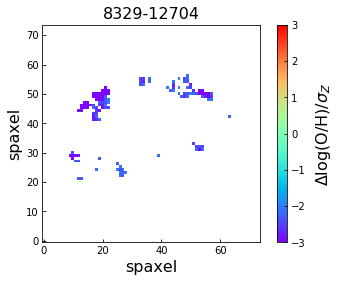

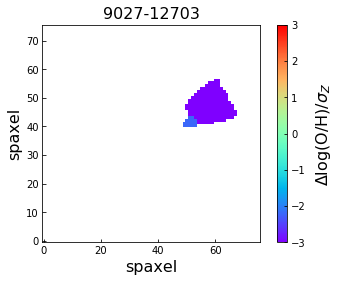

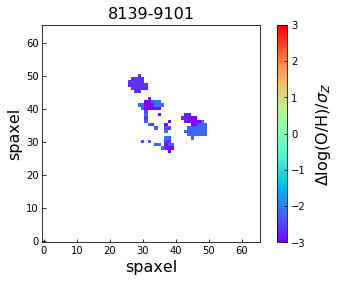

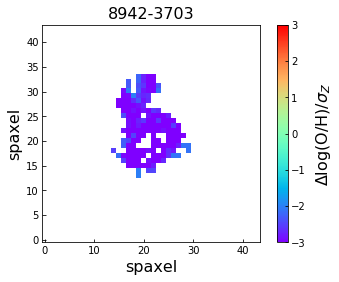

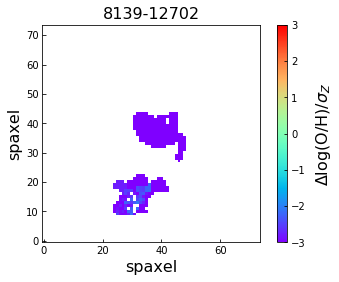

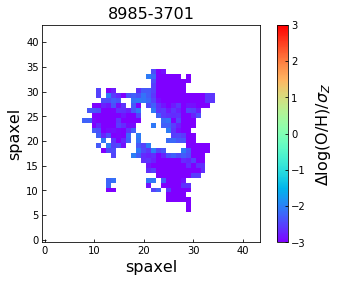

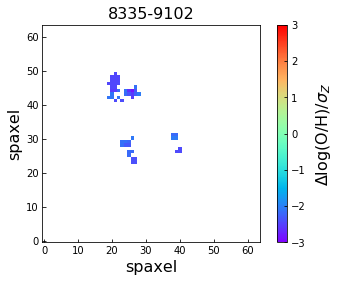

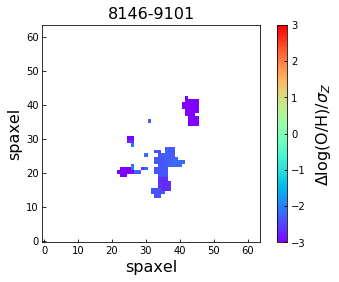

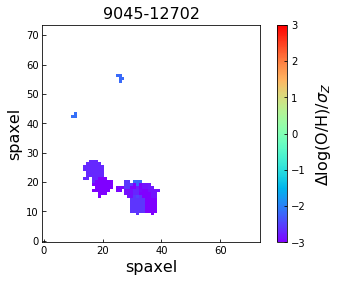

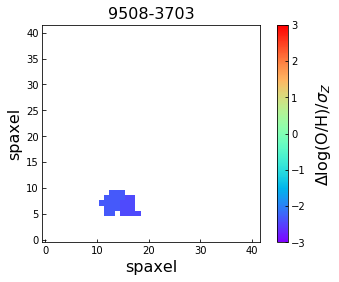

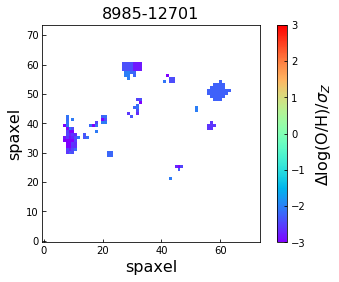

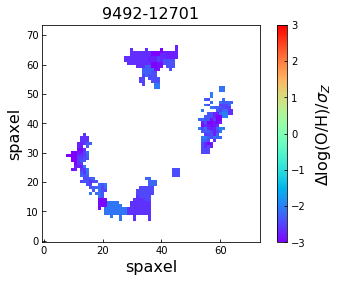

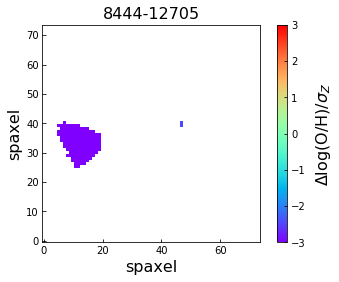

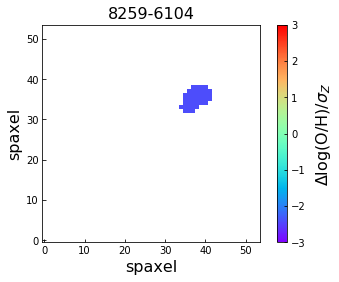

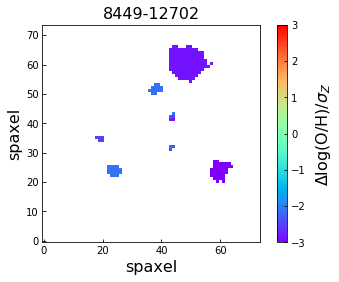

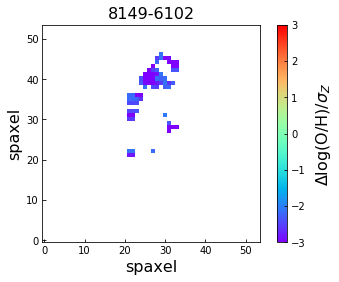

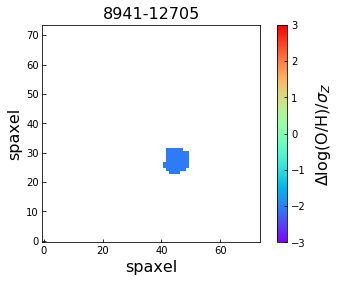

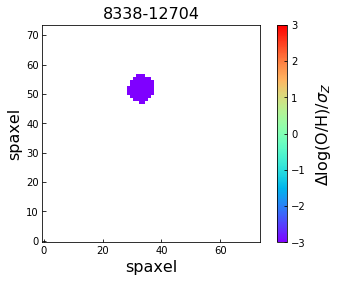

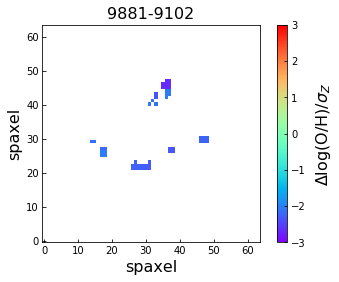

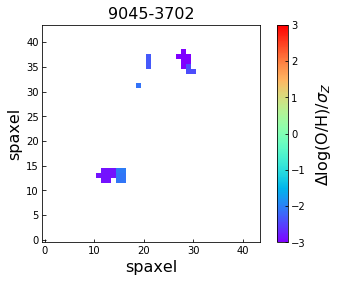

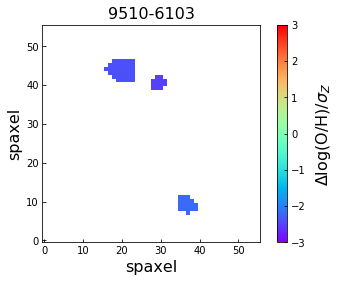

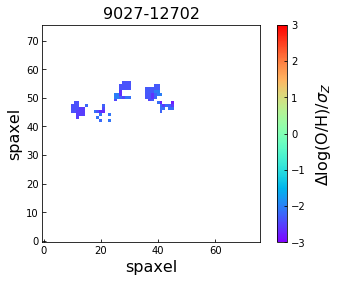

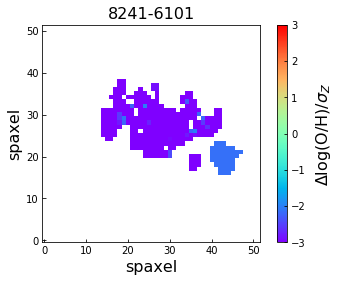

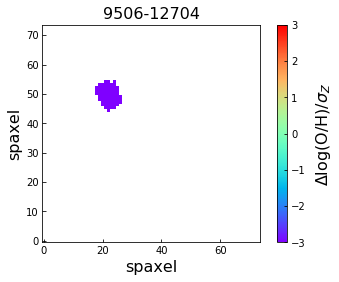

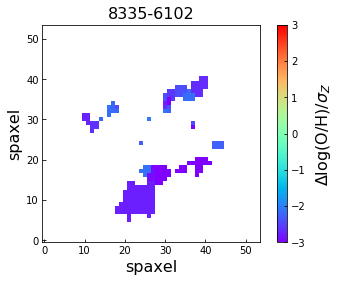

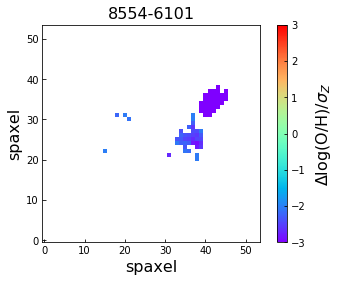

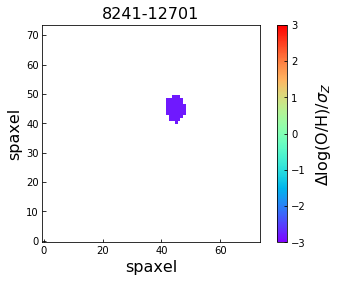

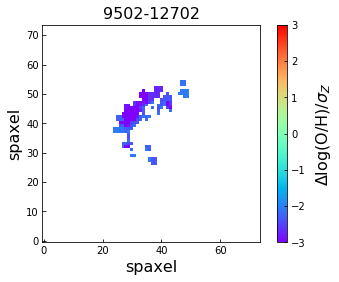

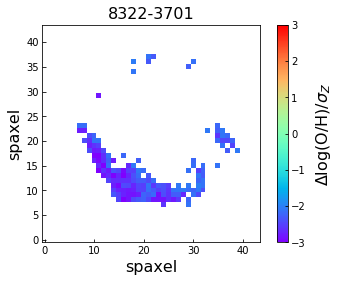

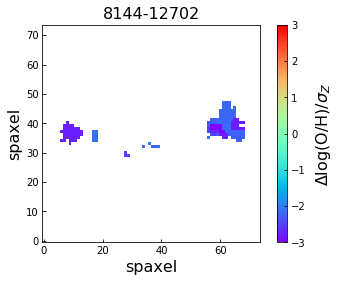

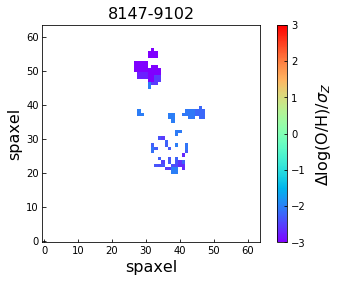

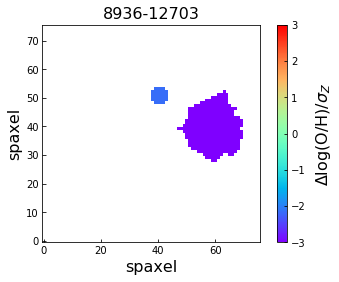

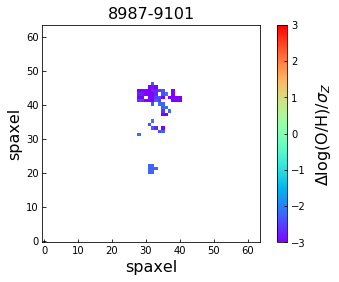

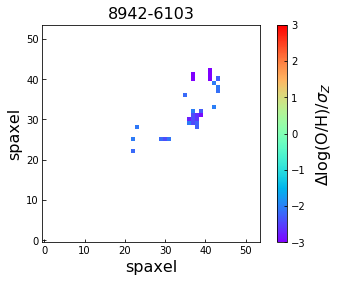

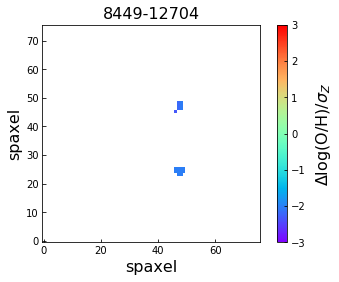

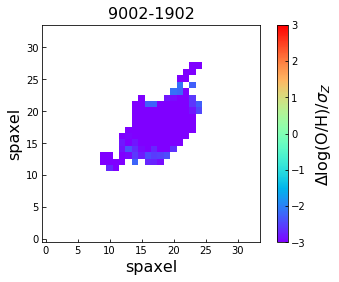

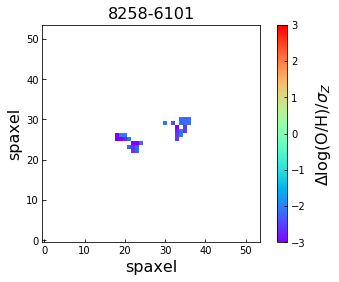

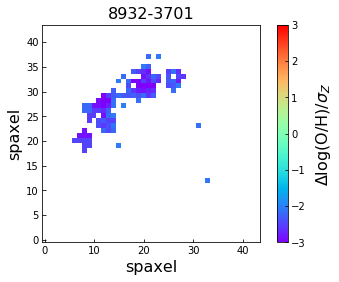

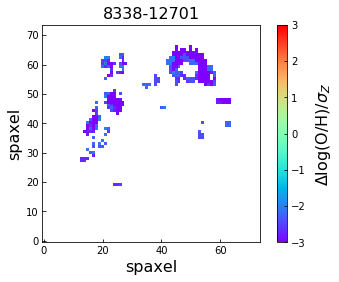

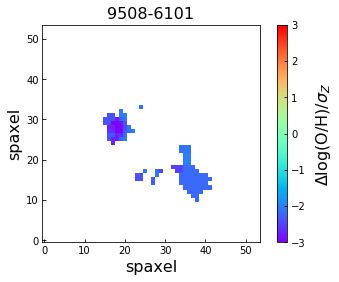

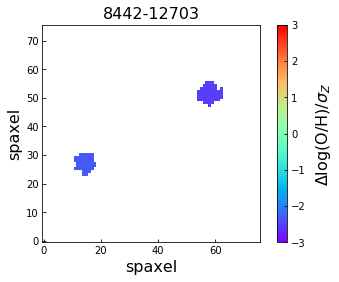

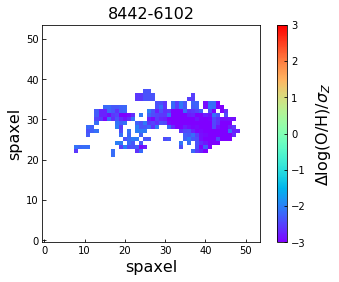

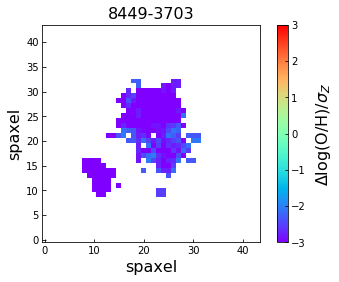

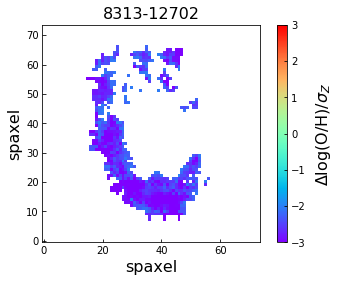

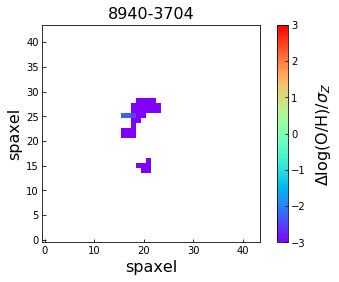

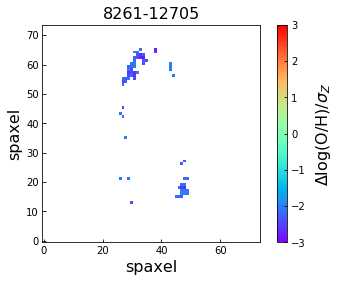

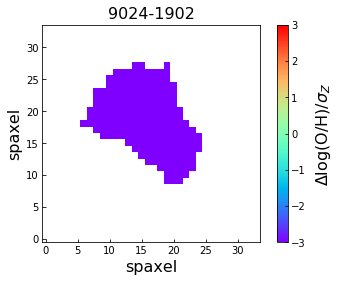

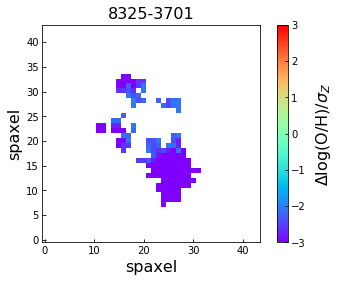

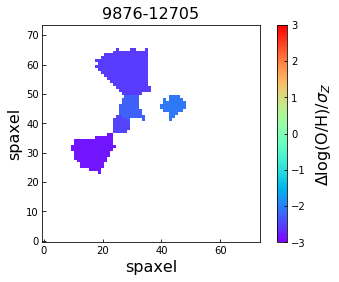

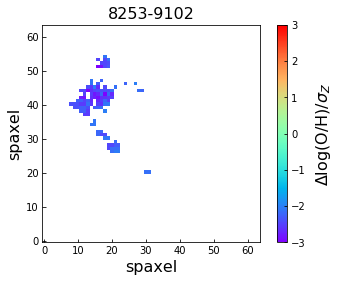

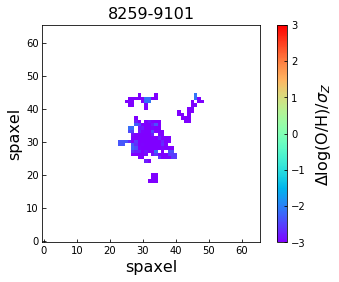

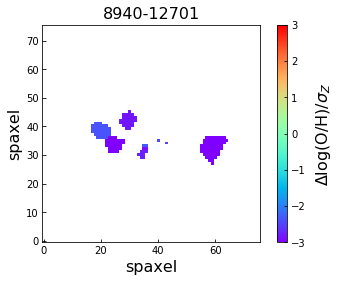

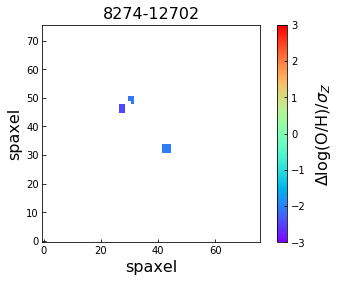

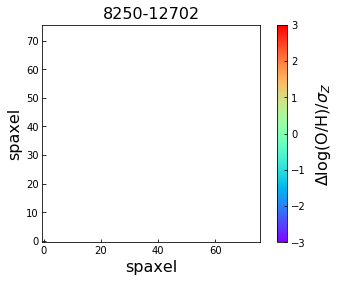

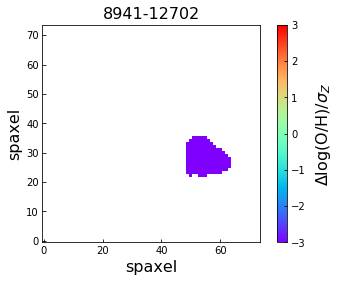

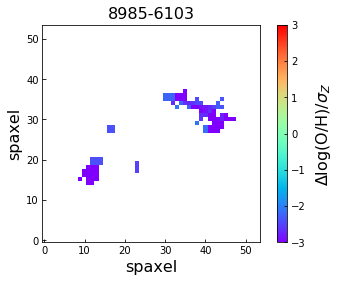

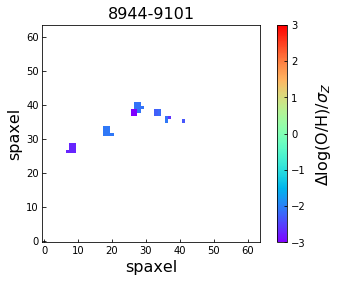

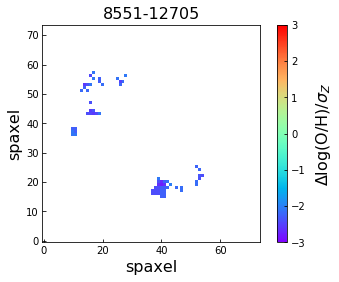

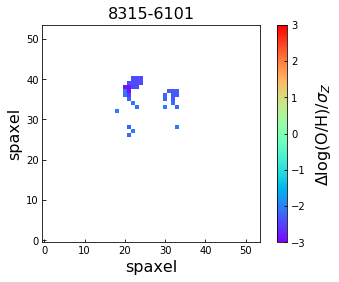

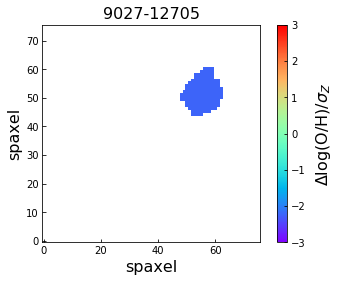

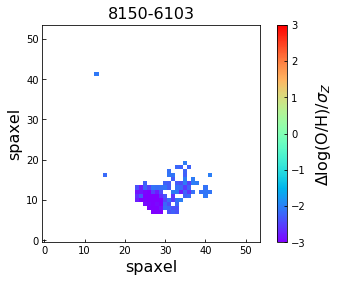

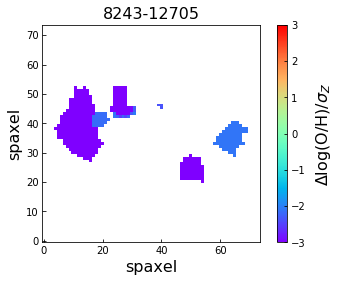

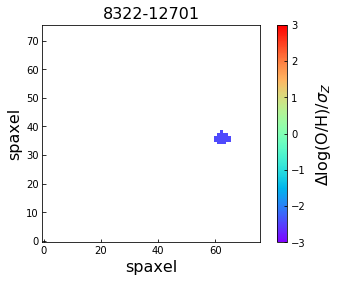

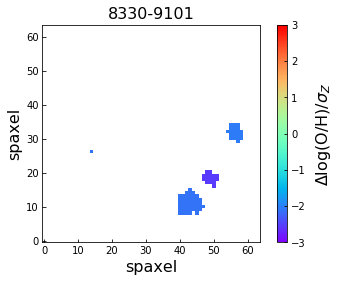

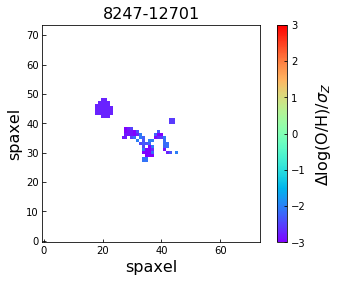

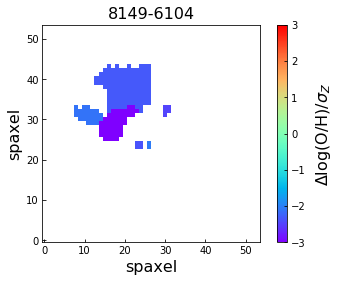

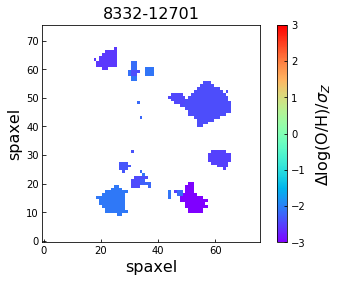

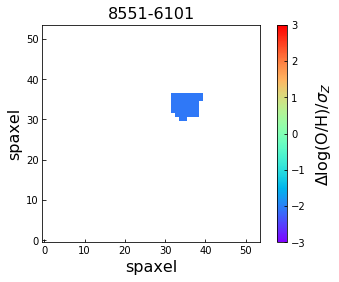

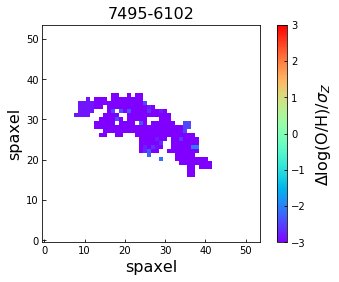

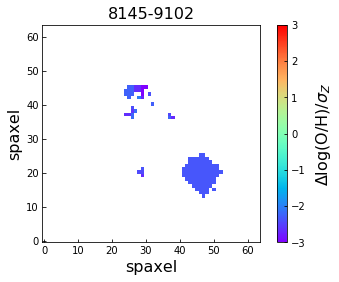

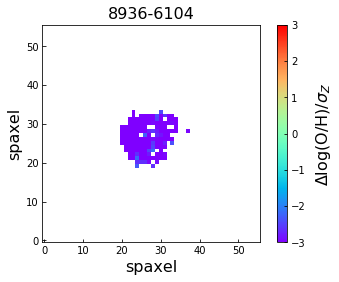

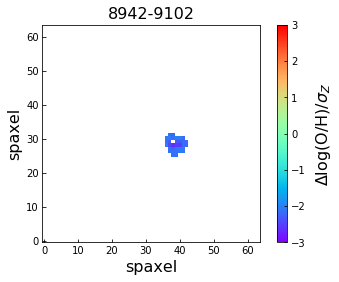

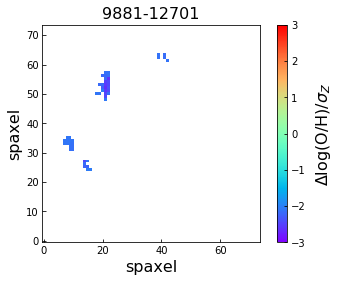

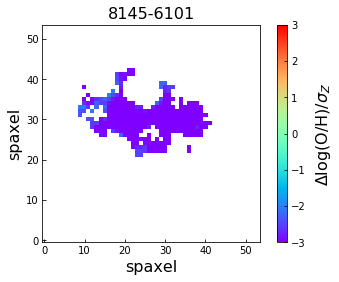

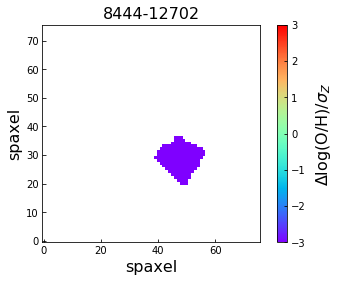

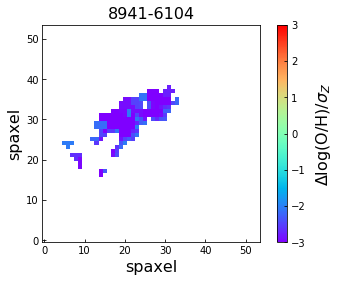

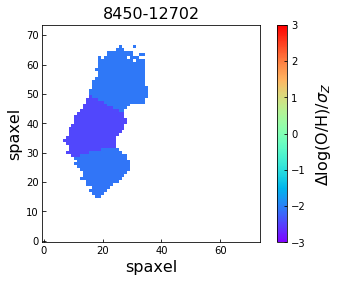

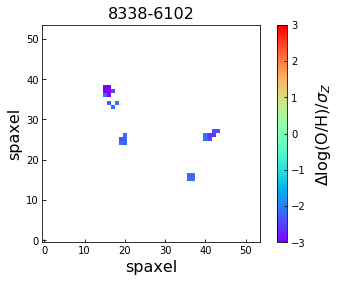

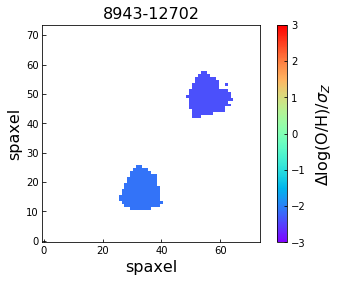

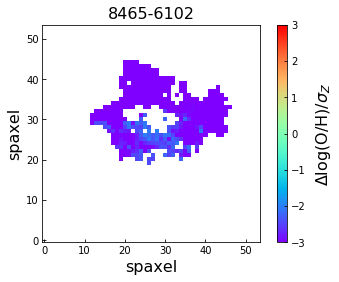

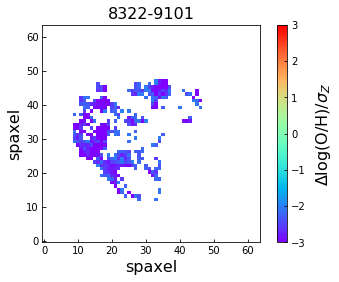

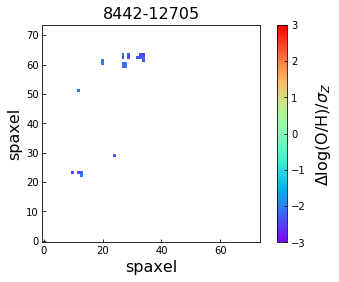

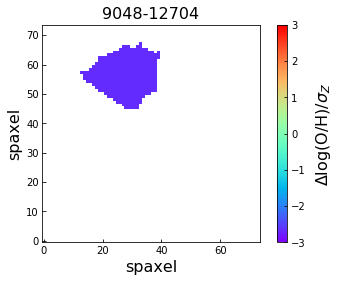

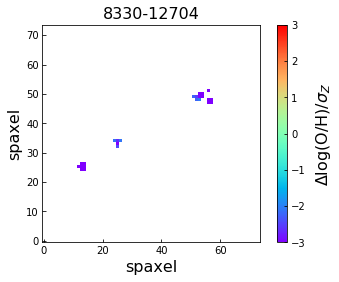

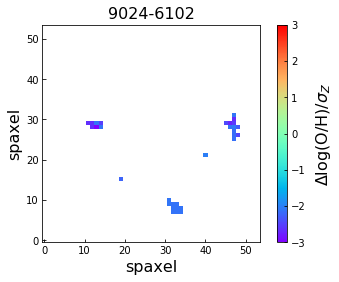

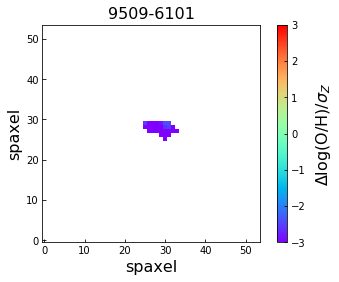

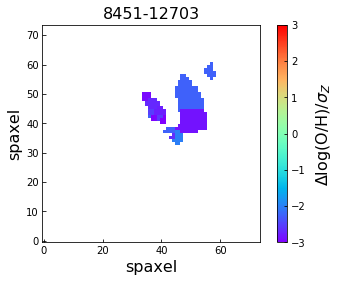

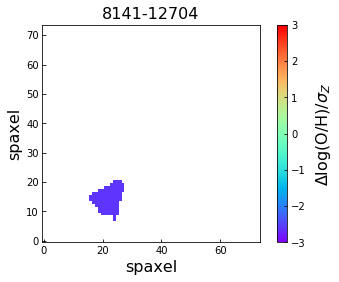

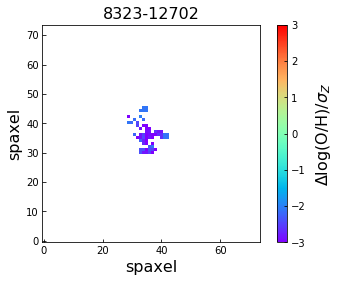

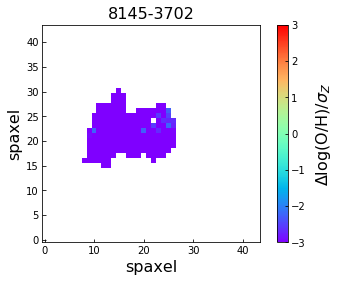

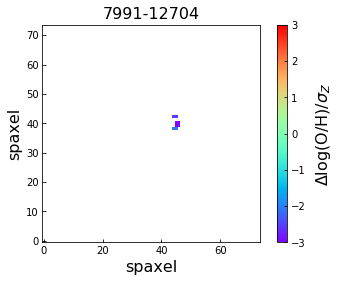

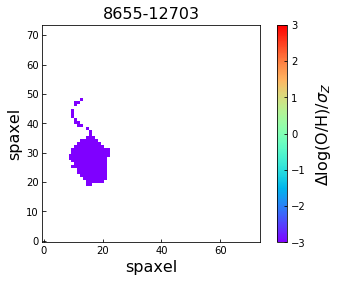

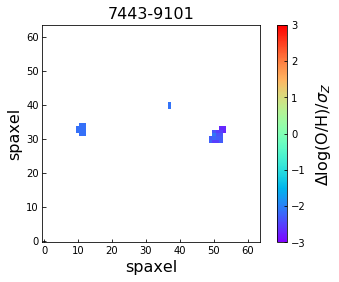

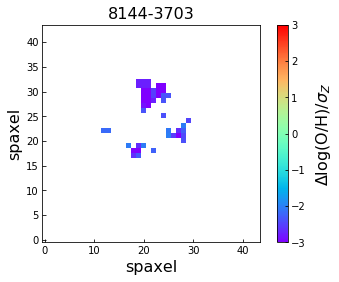

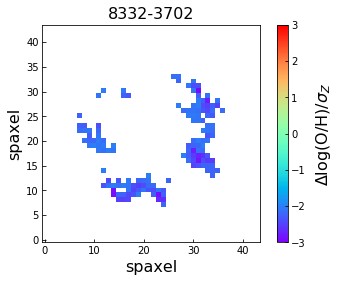

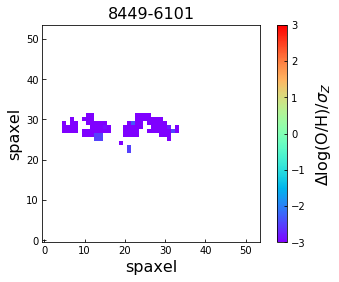

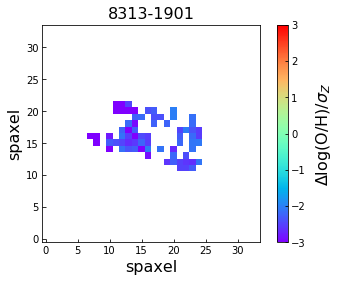

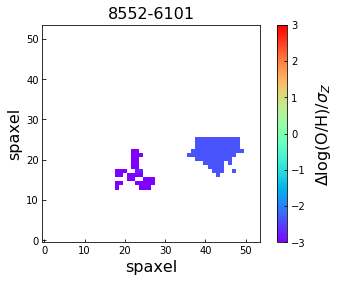

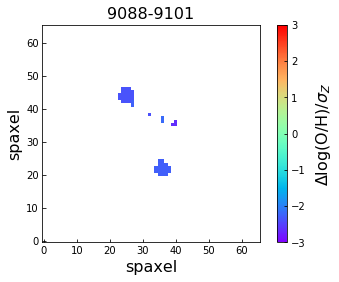

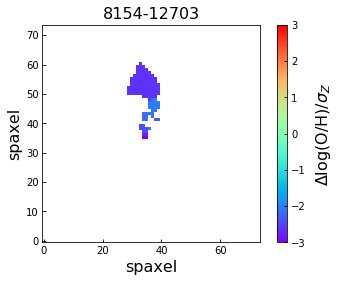

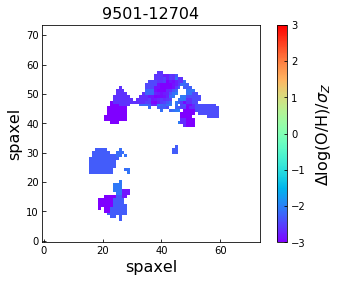

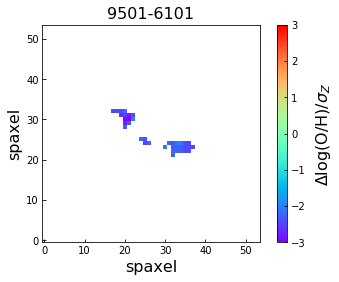

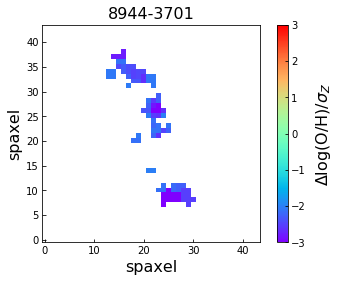

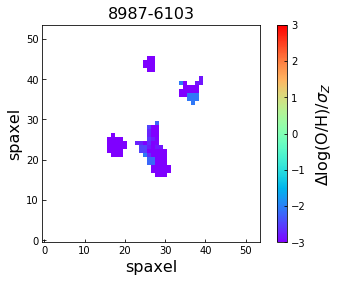

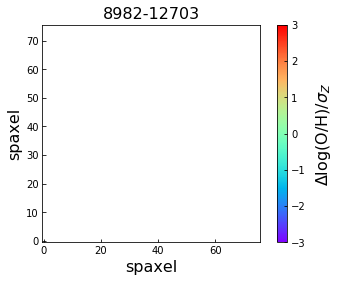

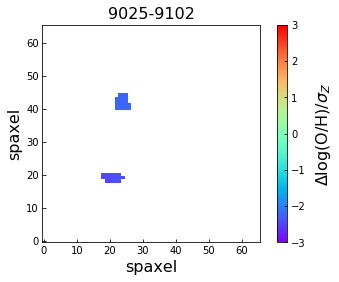

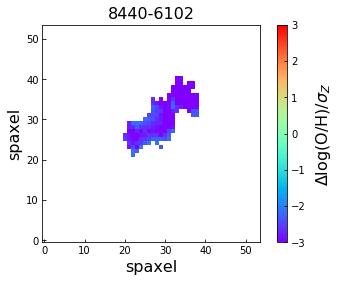

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [216]:
# 肉眼分辨 ALM 星系
# 是否是成块的区域还是完全随机离散的
plt_ALM_spaxel(MaNGA_plaifu)
list(map(plt_ALM_spaxel,plaifu_ALM_HI))


# plaifu_ALM_HI

### HI光谱图

In [196]:
mgHI = fits.open('/root/cosmos/data/mangaHIall.fits') 

HI_plifu = mgHI[1].data['plateifu']
HI_v = mgHI[1].data['vopt']
HI_flux = mgHI[1].data['peak']

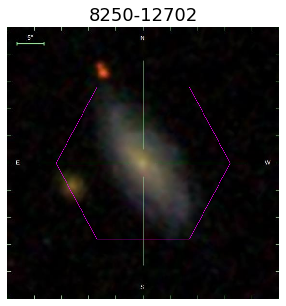

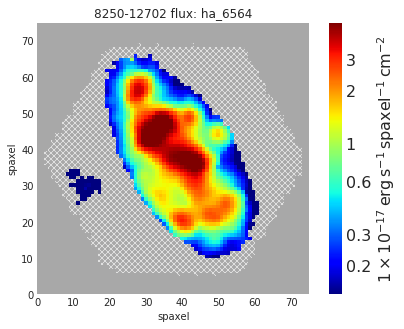

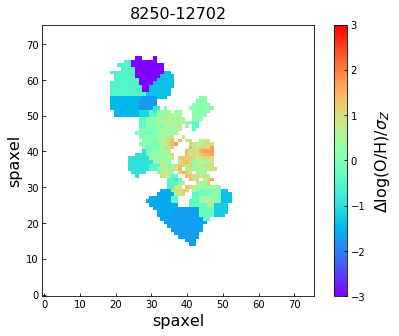

In [270]:
# 总画图
MaNGA_plifu = '8250-12702'
MaNGA_image(MaNGA_plifu)
MaNGA_element_image(MaNGA_plifu,'ha_6564')
plt_sf_spaxel(MaNGA_plifu)
# plt_ALM_spaxel('MaNGA_plifu')

In [116]:
matrix = np.array([[1,1,1],[2,2,2]])
a= np.ma.array(matrix,mask=np.array([[True,True,True],[False,True,False]]),fill_value=-999)
print(a[1,:])


[2 -- 2]


In [54]:
Zm = np.ma.masked_where(Z > 1.2, Z)

(1, 67262)

In [115]:
array_id = 666
plate = basic['plate'][array_id]
ifu = basic['ifudsgn'][array_id]
print("plate = ",plate,"\nifu = ",ifu)

plate =  9039 
ifu =  3704


In [2]:
plate = 8252
ifu = 9102
manga_fits = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic = copy(manga_fits[1].data)
galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))
# galid = (basic['plate']==plate)
# galid = (basic['ifudsgn']==str(ifu))

array_id = np.where(galid==1)[0][0]
plate = basic['plate'][array_id]
ifu = basic['ifudsgn'][array_id]
print("Array_id = ",array_id)
print("plate = ",plate,"\nifu = ",ifu)

NameError: name 'fits' is not defined

In [191]:
from marvin.tools import Maps
# 使用Marvin读取数据
new_maps = Maps(''.join([str(plate),'-',str(ifu)]))    # 通过Marvin导入星系数据
ha = new_maps.emline_gflux_ha_6564    # 获取Hα

In [ ]:
path_marvin = /root/bash_file/manga_maps_data/manga-8077-6104-MAPS-HYB10-GAU-MILESHC.fits.gz

In [4]:
'''数据说明：
sel_spaxel_data 包含了每个spaxel所在的星系的数组位置以及在星系中的具体位置xy
Z_exp spaxel的金属丰度预期值
Z_dev 挑选出的spxel的金属丰度偏差
'''
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from marvin.tools import Maps
from os.path import join
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
from copy import copy as copy
from os.path import join
import math
import numpy as np
from matplotlib.colors import ListedColormap
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot
import warnings
warnings.filterwarnings('ignore')    # 不显示warning信息

manga_fits = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic = copy(manga_fits[1].data)
# array_id = 666
# plate-ifu, eg. 8252-9102
plate = 8252
ifu = 9102

galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))
array_id = np.where(galid==True)[0][0]

path_image_data = '/root/cosmos/data/images'
path_marvin_maps = '/root/bash_file/manga_maps_data'
firefly_fits = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic = copy(firefly_fits[1].data)
binid = copy(firefly_fits[5].data)
bin1d = copy(firefly_fits[4].data[galid,:,0][0])    # 获取一维的bin数据
# 使用Marvin读取数据
filename = join(path_marvin_maps, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
maps = Maps(filename=filename)
ha = maps.emline_gflux_ha_6564
image_sz = np.shape(ha)[0]    # 图像边长
new_maps = Maps(''.join([str(plate),'-',str(ifu)]))    # 通过Marvin导入星系数据
ha = new_maps.emline_gflux_ha_6564    # 获取Hα
# 获取星系的编号：plate ifu
plate = basic['plate'][array_id]
ifu = basic['ifudsgn'][array_id]
# 星系所在数组位置
galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))
idarray = np.where(sel_spaxel_data[:,0]==array_id)[0]
# 每个spaxel的星系中的位置以及金属丰度偏差值
spaxel_x = sel_spaxel_data[idarray,2]
spaxel_y = sel_spaxel_data[idarray,3]
spaxel_z = Z_dev[idarray]/0.07

# 画出金属丰度偏差分布图
# plt.figure(figsize=(6,5))
# # 设置colorbar颜色样式，可以在下面网站查询：
# # https://matplotlib.org/tutorials/colors/colormaps.html
# cm = plt.cm.get_cmap('rainbow')
# x = spaxel_x
# y = spaxel_y
# z = spaxel_z
# # 开始画散点图
# sc = plt.scatter(y, x,c=z[:,0],vmin=-3,vmax=3, s=1, cmap=cm)
# # plt.plot(y, x, c=z[:,0],marker='o', markersize=100, fillstyle='bottom')
# plt.xlim(0,image_sz)
# plt.ylim(0,image_sz)
# # 坐标轴标题设置
# plt.xlabel('spaxel',fontsize=16)    # x轴标签
# plt.ylabel('spaxel',fontsize=16)    # y轴标签
# plt.tick_params(which='both',direction='in')
# # colorbar调整
# cbar = plt.colorbar(sc)
# cbar.ax.tick_params(which='both',direction='in')
# cbar.set_label('$\Delta$log(O/H)',fontsize=16,labelpad=8)
# # plt.title('Metallicity',fontsize=16)
# plt.show()
mtx_plt = np.ones((image_sz,image_sz))*np.nan
for i in range(spaxel_x.size):
    mtx_plt[int(spaxel_x[i]),int(spaxel_y[i])] = spaxel_z[i]

# 开始画图
cm = plt.cm.get_cmap('rainbow')
sc = plt.imshow(mtx_plt,origin='lower',vmin=-3,vmax=3,cmap=cm)
plt.xlabel('spaxel',fontsize=16)    # x轴标签
plt.ylabel('spaxel',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = plt.colorbar(sc)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label('$\Delta$log(O/H)/$\sigma_Z$',fontsize=16,labelpad=8)
# plt.title('Metallicity',fontsize=16)
plt.show()

# Hα flux图
fig, ax, cb=ha.plot(cmap='jet',log_cb=True,cbrange=(0.001,50),return_cb=True)
cb.set_ticks([0.1, 1, 10])
cb.set_ticklabels(['$10^{-1}$', '$10^{0}$', '$10^{1}$'])
cb.ax.tick_params(labelsize=10) 
cb.set_label('Flux( $10^{-17}$ erg s$^{-1}$) spaxel$^{-1}$ cm$^{-2}$',fontsize=13,labelpad=8)

# 做出星系光学观测图
image_path = join(path_image_data, '{}.png'.format(''.join([str(plate),'-',str(ifu)])))
name_pla_ifu = ''.join([str(plate),'-',str(ifu)])

temp_image = mpimg.imread(image_path)


fig, ax = plt.subplots(figsize=(5, 5))
plt.title(name_pla_ifu,fontsize=18)
plt.imshow(temp_image) # 显示图片
plt.axis('on') # 不显示坐标轴
plt.show()



'''匹配1d和2d数组-画图

'''
mass = firefly_fits['SURFACE_MASS_DENSITY_VORONOI'].data[idarray,:,0]
maps = np.ones((image_sz,image_sz))*np.nan    # 初始化画图数组
for i in range(image_sz):
    for j in range(image_sz):
        idbin = (bin1d==binid[galid,i,j])    # 搜索二维bin的值在一维bin数组中的 位置
        if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
            maps[i,j] = mass[idbin]

# 加mask
masked_array = np.ma.array(maps,mask=None)

fig, ax = plt.subplots()
p = ax.imshow(masked_array , origin='lower')#,vmin=5.5,vmax=8.5)
plt.xlim(0,image_sz)
plt.ylim(0,image_sz)
ax.set_xlabel('spaxel',fontsize=16)
ax.set_ylabel('spaxel',fontsize=16)
cb = fig.colorbar(p)
cb.set_label(prop[0:len(prop)-8],fontsize=18,labelpad=10)
#plt.xlim((0,53))    # x轴坐标范围
#plt.ylim((0,53))    # y轴坐标范围

firefly_fits.close()

NameError: name 'sel_spaxel_data' is not defined

In [211]:
firefly_fits = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
firefly_fits['SURFACE_MASS_DENSITY_VORONOI'].data[4526,:,0].shape

(2800,)

In [195]:
new_maps = Maps(''.join([str(plate),'-',str(ifu)]))    # 通过Marvin导入星系数据
ha = new_maps.stellar_vel

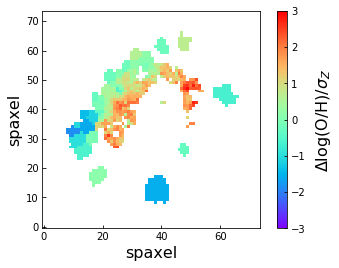

In [224]:
# 金属丰度偏差分布图
spaxel_x = sel_spaxel_data[idarray,2]
spaxel_y = sel_spaxel_data[idarray,3]
spaxel_z = Z_dev[idarray]/0.07
mtx_plt = np.ones((image_sz,image_sz))*np.nan
for i in range(spaxel_x.size):
    mtx_plt[int(spaxel_x[i]),int(spaxel_y[i])] = spaxel_z[i]

# 开始画图
cm = plt.cm.get_cmap('rainbow')
sc = plt.imshow(mtx_plt,origin='lower',vmin=-3,vmax=3,cmap=cm)
plt.xlabel('spaxel',fontsize=16)    # x轴标签
plt.ylabel('spaxel',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = plt.colorbar(sc)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label('$\Delta$log(O/H)/$\sigma_Z$',fontsize=16,labelpad=8)
# plt.title('Metallicity',fontsize=16)
plt.show()

In [252]:
ha.plot?

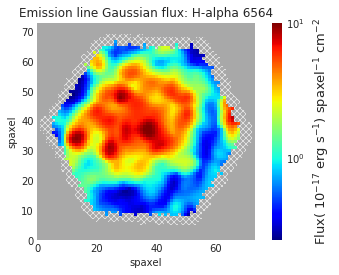

In [259]:
fig,ax,cbar = ha.plot(cmap='jet',log_cb=True,cbrange=(0.001,10.0),return_cb=True)
# cbar = plt.colorbar(ax)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label('$\Delta$log(O/H)/$\sigma_Z$',fontsize=16,labelpad=8)
cbar.set_ticks([0.001, 1, 10])
cbar.set_ticklabels(['$10^{-1}$', '$10^{0}$', '$10^{1}$'])
cbar.set_label('Flux( $10^{-17}$ erg s$^{-1}$) spaxel$^{-1}$ cm$^{-2}$',fontsize=13,labelpad=8)
cbar.ax.tick_params(labelsize=10) 

In [263]:
cbar.get_ticks()

array([1.e-03, 1.e+00, 1.e+01])

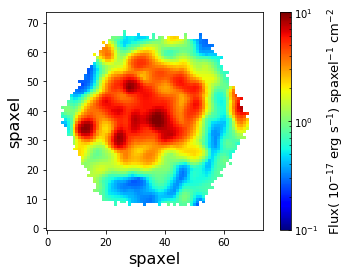

In [241]:

fig, ax = plt.subplots()
p = ax.imshow(ha.value, origin='lower',norm= mpl.colors.LogNorm(),vmin=0.1,vmax=10,cmap='jet')
ax.set_xlabel('spaxel',fontsize=16)
ax.set_ylabel('spaxel',fontsize=16)
cbar = plt.colorbar(p)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label('$\Delta$log(O/H)/$\sigma_Z$',fontsize=16,labelpad=8)
cbar.set_ticks([0.1, 1, 10])
cbar.set_ticklabels(['$10^{-1}$', '$10^{0}$', '$10^{1}$'])
cbar.set_label('Flux( $10^{-17}$ erg s$^{-1}$) spaxel$^{-1}$ cm$^{-2}$',fontsize=13,labelpad=8)
# cb.ax.tick_params(labelsize=10)
# cb = fig.colorbar(p)
# cb.set_label(prop[0:len(prop)-8],fontsize=18,labelpad=10)

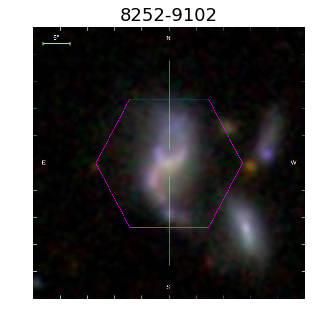

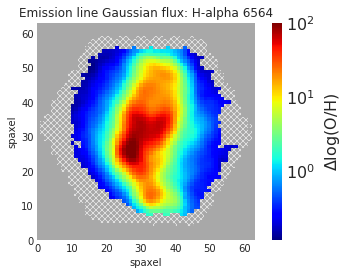

In [171]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot
from os.path import join

# Marvin's fits.gz file Path and images path
path_marvin_maps = '/root/bash_file/manga_maps_data'
path_image_data = '/root/cosmos/data/images'

# Galaxy ID plate-ifu
plate = 8252
ifu = 9102

#maps = Maps('8252-9102')
#filename = '/root/cosmos/galaxies-mzr/data/manga-8077-6104-MAPS-HYB10-GAU-MILESHC.fits.gz'
#maps = Maps(filename=filename)
filename = join(path_marvin_maps, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
maps = Maps(filename=filename)

nii = maps.emline_gflux_nii_6585
ha = maps.emline_gflux_ha_6564

# show the image
image_path = join(path_image_data, '{}.png'.format(''.join([str(plate),'-',str(ifu)])))
name_pla_ifu = ''.join([str(plate),'-',str(ifu)])
temp_image = mpimg.imread(image_path)
fig, ax = plt.subplots(figsize=(5, 5))
plt.title(name_pla_ifu,fontsize=18)
plt.imshow(temp_image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()


fig, ax, cb=ha.plot(cmap='jet',cblabel='Flux( $10^{-17}$ erg s$^{-1}$) spaxel$^{-1}$ cm$^{-2}$',log_cb=True,cbrange=(0.0001,100),return_cb=True)
cb.set_ticks([0.1, 1, 10, 100])
cb.set_ticklabels(['$10^{-1}$', '$10^{0}$', '$10^{1}$', '$10^{2}$'])
cb.set_label('$\Delta$log(O/H)',fontsize=16,labelpad=8)
#cb.cb_kws={'axloc': [0.8, 0.1, 0.03, 5 / 6.]}



### 匹配1d和2d数组-画图

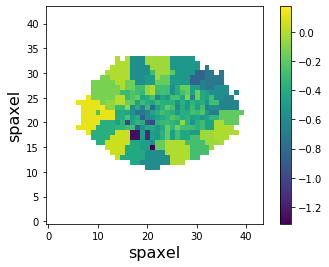

In [300]:
'''匹配1d和2d数组-画图
'''
MaNGA_plifu = '8551-3701'


#read in the vac file
firefly_fits = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits')
galid = (firefly_fits[1].data['PLATEIFU']==MaNGA_plifu)
# tmp_id = (MaNGA_plaifu==firefly_fits[1].data['PLATEIFU'])
binid = copy(firefly_fits[5].data)
bin1d = copy(firefly_fits[4].data[galid,:,0][0])    # 获取一维的bin数据
surf_density = firefly_fits[8].data[galid,:,0][0]# 2800长度
# 画图
image_sz = np.shape(ha)[0]    # 图像边长
mapss = np.ones((image_sz,image_sz))*np.nan    # 初始化画图数组
for i in range(image_sz):
    for j in range(image_sz):
        idbin = (bin1d==binid[galid,i,j])    # 搜索二维bin的值在一维bin数组中的 位置
        if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
            mapss[i,j] = surf_density[idbin]

# 加mask
# masked_array = np.ma.array(mapss,mask=None)
masked_array = mapss
fig, ax = plt.subplots()
p = ax.imshow(masked_array , origin='lower')#,vmin=5.5,vmax=8.5)
# plt.xlim(0,70)
# plt.ylim(0,70)
ax.set_xlabel('spaxel',fontsize=16)
ax.set_ylabel('spaxel',fontsize=16)
cb = fig.colorbar(p)
# cb.set_label(prop[0:len(prop)-8],fontsize=18,labelpad=10)
#plt.xlim((0,53))    # x轴坐标范围
#plt.ylim((0,53))    # y轴坐标范围
plt.show()
manga_fits.close()

In [178]:
image_sz

64

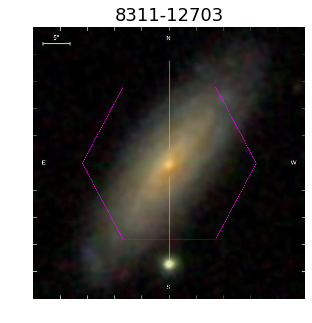

In [68]:


array_id = 65

path_image_data = '/root/cosmos/data/images'
manga_fits = fits.open('/root/cosmos/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic = copy(manga_fits[1].data)
plate = basic['plate'][array_id]
ifu = basic['ifudsgn'][array_id]
galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))    # 星系编号 galaxy ID

image_path = join(path_image_data, '{}.png'.format(''.join([str(plate),'-',str(ifu)])))
name_pla_ifu = ''.join([str(plate),'-',str(ifu)])

temp_image = mpimg.imread(image_path)


fig, ax = plt.subplots(figsize=(5, 5))
plt.title(name_pla_ifu,fontsize=18)
plt.imshow(temp_image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

manga_fits.close()

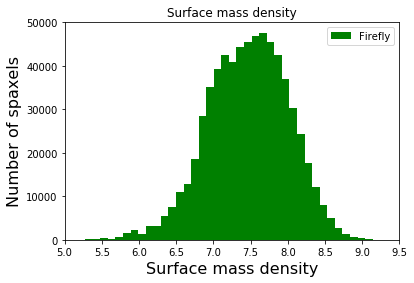

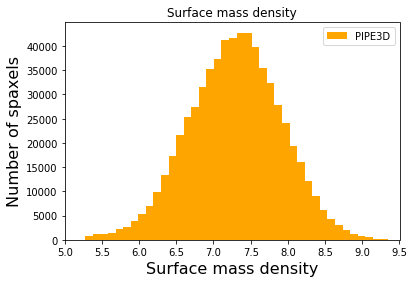

In [42]:
firefly = firefly_spaxel_density.copy()
pipe3d = spaxel_density.copy()
__,bins,__ = plt.hist(firefly,bins=40,color='g',label='Firefly')
plt.legend(loc='best')
plt.title("Surface mass density")
plt.xlabel('Surface mass density',fontsize=16)
plt.ylabel('Number of spaxels',fontsize=16)
plt.xlim([5,9.5])
plt.show()

plt.hist(pipe3d,bins=bins,color='orange',label='PIPE3D')
plt.legend(loc='best')
plt.title("Surface mass density")
plt.xlabel('Surface mass density',fontsize=16)
plt.ylabel('Number of spaxels',fontsize=16)
plt.xlim([5,9.5])
plt.show()

In [153]:
hist

array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00,
       9.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00,
       2.0000e+00, 0.0000e+00, 2.0000e+00, 5.0000e+00, 0.0000e+00,
       3.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
       1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       2.0000e+00, 7.0000e+00, 1.0000e+00, 2.0000e+00, 3.8000e+01,
       3.3000e+01, 1.8000e+01, 2.0000e+01, 2.7000e+01, 3.0000e+01,
       2.7000e+01, 3.4000e+01, 4.4000e+01, 5.7000e+01, 1.6500e+02,
       3.7000e+01, 6.3000e+01, 6.1000e+01, 1.4200e+02, 1.2500e+02,
       1.0500e+02, 2.0900e+02, 1.3100e+02, 1.9100e+02, 2.3400e

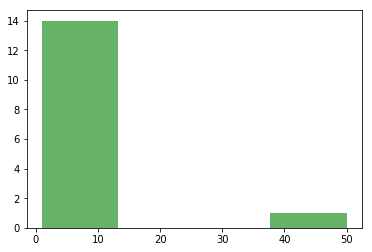

matplotlib.hist:  
个数  [14.  0.  0.  1.] 
位置  [ 1.   13.25 25.5  37.75 50.  ] 
x轴范围： (-1.4500000000000002, 52.45) 
y轴范围： (0.0, 14.7)
numpy.histogram:  
个数  [14  0  0  1] 
位置  [ 1.   13.25 25.5  37.75 50.  ] 
x轴范围： 50.0 1.0


In [142]:
# np.histogram和plt.hist区别  测试！！！

a = np.array([1,1,2,3,4,5,6,6,6,6,6,6,6,6,50])
pltcount,pltbin,__ = plt.hist(a,bins=4,alpha=0.6, color='g');
xlim = plt.xlim()
ylim = plt.ylim()
plt.show()

npcount, npbin = np.histogram(a,bins=4)
# plt.plot(npbin,npcount,'ro')
# plt.show()


print('matplotlib.hist: ','\n个数 ',pltcount,'\n位置 ',pltbin,'\nx轴范围：',xlim,'\ny轴范围：',ylim)
print('numpy.histogram: ','\n个数 ',npcount,'\n位置 ',npbin,'\nx轴范围：',npbin.max(),npbin.min())

In [145]:
a[3:]

array([ 3,  4,  5,  6,  6,  6,  6,  6,  6,  6,  6, 50])

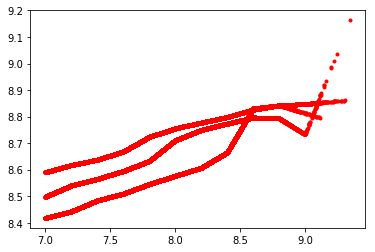

In [553]:
# 检查挑选出来的spaxels的金属丰度预期值的分布
yy = Z_exp
xx = sel_density

plt.plot(xx,yy,'r.')# 画图
plt.show()

In [533]:
# 检查金属丰度预期值的分布













(666098,)

In [222]:
expeted_data[::-1]

array([[       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [8.8       , 8.72388556],
       [8.6       , 8.61910779],
       [8.4       , 8.631877  ],
       [8.2       , 8.55933623],
       [8.        , 8.5531723 ],
       [7.8       , 8.56938311],
       [7.6       , 8.56288548],
       [7.4       , 8.53718328],
       [7.2       , 8.56469414],
       [7.        , 8.66921533],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [8.

In [216]:
a = np.array([['orange','blue','green','red'],['8.5-9.0','9.0-9.5','9.5-10','10-12']],dtype=str)
b = a.transpose()[::-1]
print(a.transpose())
print(b)

[['orange' '8.5-9.0']
 ['blue' '9.0-9.5']
 ['green' '9.5-10']
 ['red' '10-12']]
[['red' '10-12']
 ['green' '9.5-10']
 ['blue' '9.0-9.5']
 ['orange' '8.5-9.0']]


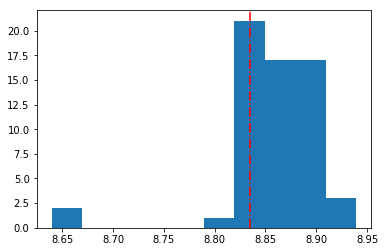

mode is  21.0
expected Z =  8.83437987797904


In [102]:
hist,bins,cax = plt.hist(fix_Z,bins=int((np.max(fix_Z)-np.min(fix_Z))/0.03+1))
expcted_Z = (bins[np.where(hist==np.max(hist))]+(bins[1]-bins[0])/2)[0]
plt.axvline(expcted_Z,color='r',linestyle='-.');
plt.show()
print('mode is ',np.max(hist))
print('expected Z = ',expcted_Z)

In [92]:
bins

array([8.639623  , 8.6695856 , 8.6995482 , 8.72951079, 8.75947339,
       8.78943598, 8.81939858, 8.84936118, 8.87932377, 8.90928637,
       8.93924896])

In [86]:
np.min(fix_Z)

8.863179695239317

In [78]:
tmp_density[iddensity]

array([7.55556083, 7.57347417, 7.53462672, ..., 7.5013783 , 7.5013783 ,
       7.5013783 ])

In [37]:
density_no_nan = firefly_spaxel_density[~np.isnan(firefly_spaxel_density)]
np.max(density_no_nan)
Z_no_nan = Znew[~np.isnan(firefly_spaxel_density)]
np.max(Z_no_nan)


nan

In [67]:
np.arange(7.5,np.max(firefly_spaxel_density),0.2)

array([ 7.5,  7.7,  7.9,  8.1,  8.3,  8.5,  8.7,  8.9,  9.1,  9.3,  9.5,
        9.7,  9.9, 10.1, 10.3])

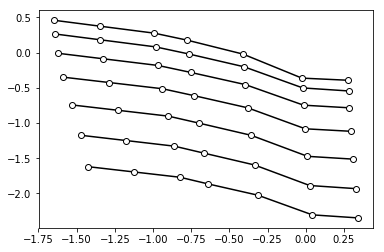

In [17]:
# 开始画grid格子
for i in range(7):
    xx=locals()['line'+str(i+1)+'x']
    yy=locals()['line'+str(i+1)+'y']
    plt.plot(xx,yy,'o-',color='black',markerfacecolor='white')

In [16]:
'''
继续筛选spexles，筛选条件如下：
surface mass density > 10^7 Msun
'''
b = spaxel_density.copy()
# 筛选 density 条件
b -= ba_add_orig[:,1]    # spaxles^2 ---> kpc^2单位转换
b += np.log10(ba_add_orig[:,0])    # obs_density*b/a = inc_density 考虑椭圆率进行逆映射
b[np.isinf(b)] = np.nan
# id_sel_density = np.where(b>7)
id_sel_density = np.where(b>0)
##########################################################
# 最终的筛选结果数组
spaxel_density = b[id_sel_density[0]]
spaxel_data = spaxel_data[id_sel_density[0]]
##########################################################

ValueError: operands could not be broadcast together with shapes (651416,) (666109,) (651416,) 

In [18]:
# 检查金属丰度matallicity和density数组大小是否一致
print('Z = ',Z.shape,
     '\ndensity = ',spaxel_density.shape)

Z =  (45,) 
density =  (666109,)


In [11]:
# 修正前 PIPE3D 中的 surface mass density 的分布
# a = spaxel_density.copy()
a = spaxel_data[:,4].copy()
a[np.isinf(a)] = np.nan
a += np.log10(ba_add_orig[:,0])
# 修正后 PIPE3D 中的 surface mass density 的分布
#################################################
# b = spaxel_density - ba_add_orig[:,1]    # spaxles^2 ---> kpc^2单位转换
# b += np.log10(ba_add_orig[:,0])    # obs_density*b/a = inc_density 考虑椭圆率进行逆映射
#################################################
b[np.isinf(b)] = np.nan
# 修正前后 PIPE3D
_,bins_fire,_ = plt.hist(a,bins=50,color='#7c6aed',label='Firefly')
plt.hist(b,bins=bins_fire,color='orange',label='PIPE3D',alpha=0.8)
plt.title('Firefly&&PIPE3D \nintrinsic surface mass density ditribution',fontsize=16)
plt.xlabel('log($M_\odot/kpc^2$)',fontsize=16)
plt.ylabel('Number of galaxies',fontsize=16)
plt.legend(loc='best')
plt.show()

ValueError: operands could not be broadcast together with shapes (651416,) (666109,) (651416,) 

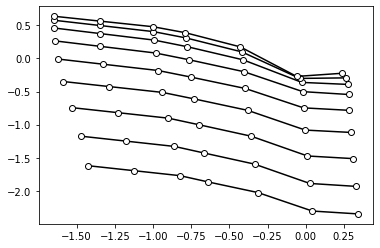

In [81]:
'''
进行外插：extrapolate
1.读取pyqz网格数据
2.使用1D外插反复操作2次进行2D外插
3.得到完整的金属丰度分布图

'''
'''
将grid进行外插
使用1D外插，分别进行多次，得到左右扩展0.3dex的grid
'''
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

# 读取pq_data的数据
qZ_xy = np.loadtxt("./tmp_storage/pyqz_grid.dat")
logq = qZ_xy[:,0]# value of ionization parameter Log(q)
Z = qZ_xy[:,1]# value of gas matellicity
x_no = qZ_xy[:,2]# value of [NII]/[OII]
y_oo = qZ_xy[:,3]# value of [OIII]/[OII]

# 取出待插值的原数据，9条横线
for i in range(9):
    # 分别给x轴和y轴赋值
    for xy in ['x','y','Z']:
        locals()['line'+str(i+1)+xy]=np.zeros(7)# 初始化数组
        # 竖线赋值
        for j in range(5):
            if xy=='x':
                locals()['line'+str(i+1)+xy][j+1] = x_no[i*5+j]
            elif xy=='y':
                locals()['line'+str(i+1)+xy][j+1] = y_oo[i*5+j]
            elif xy=='Z':
                locals()['line'+str(i+1)+xy][j+1] = Z[i*5+j]
    
    ########################################
    ############# interpolate ##############
    ########################################
    # 外插[Oiii]/[Oii]-[Nii]/[Oii]格点
    # 待插值的样本点
    x=locals()['line'+str(i+1)+'x']
    y=locals()['line'+str(i+1)+'y']
    # 用来插值的点，扩展0.3dex
    xnew = np.array([x[1]-0.3,x[5]+0.3])
    #pl.plot(x,y,"ro",label='sample')# 样本点画图
    kind ='linear'# 'cubic'# interpolation method 
    f=interpolate.interp1d(x[1:5],y[1:5],fill_value="extrapolate",kind=kind)# 使用插值函数
    ynew=f(xnew)# 得到插值结果
    # 将结果赋值给原数组
    x[0]=xnew[0]
    x[6]=xnew[1]
    y[0]=ynew[0]
    y[6]=ynew[1]
    
    # 外插金属丰度，沿着x方向 [Nii]/[Oii]
    z = locals()['line'+str(i+1)+'Z']
    # 用来插值的点，扩展0.3dex
    xnew = np.array([x[1]-0.3,x[5]+0.3])
    #pl.plot(x,y,"ro",label='sample')# 样本点画图
    kind ='linear'# 'cubic'# interpolation method 
    f=interpolate.interp1d(x[1:5],z[1:5],kind=kind,fill_value="extrapolate")# 使用插值函数
    znew=f(xnew)# 得到插值结果
    # 将结果赋值给原数组
    z[0]=znew[0]
    z[6]=znew[1]

# plot grid
for i in range(9):
    xx=locals()['line'+str(i+1)+'x']
    yy=locals()['line'+str(i+1)+'y']
    plt.plot(xx,yy,'o-',color='black',markerfacecolor='white')
plt.show()



In [82]:
'''
使用girddata函数进行内插，在Mappings网格外的点进行插值
Mappings网格内部的点继续使用pyqz的插值结果
'''
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
# 初始化待插值数据点
xy_point = np.ones([7*9,2])*np.nan
z_value = np.ones(7*9)*np.nan
# 提取坐标和金属丰度
for i in range(9):
    xy_point[7*i:7*i+7,0] = locals()['line'+str(i+1)+'x']
    xy_point[7*i:7*i+7,1] = locals()['line'+str(i+1)+'y']
    z_value[7*i:7*i+7] = locals()['line'+str(i+1)+'Z']
# 读取数据
new_xy = np.loadtxt("./tmp_storage/spaxels_1_niioii_2_oiiioii.dat")

# 插值
points = xy_point
values = z_value
method = 'linear'
Znew = griddata(points=points, values=values,xi=new_xy, method=method, fill_value=np.nan, rescale=False)

# 将grid分组 ---> 7组
# # 读取pq_data的数据
# qZ_xy = np.loadtxt("./tmp_storage/pyqz_grid.dat")
# 取值
x_no = qZ_xy[:,2]
y_oo = qZ_xy[:,3]
# 竖线，5条
for i in range(5):
    # 分别给x轴和y轴赋值
    for xy in ['x','y']:
        locals()['line'+str(i+1)+xy]=np.zeros(9)
        # 竖线赋值
        for j in range(9):
            if xy=='x':
                locals()['line'+str(i+1)+xy][j] = x_no[i+5*j]
            elif xy=='y':
                locals()['line'+str(i+1)+xy][j] = y_oo[i+5*j]                
# 横线，2条
line6x = x_no[0:5]
line6y = y_oo[0:5]
line7x = x_no[40:45]
line7y = y_oo[40:45]

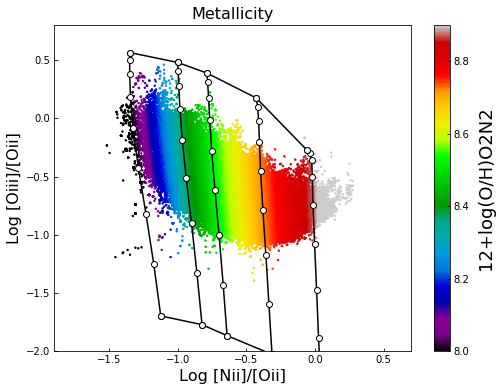

In [83]:
# 画分布图
plt.figure(figsize=(8,6))
# 设置colorbar颜色样式，可以在下面网站查询：
# https://matplotlib.org/tutorials/colors/colormaps.html
cm = plt.cm.get_cmap('nipy_spectral')
# 开始画散点图
sc = plt.scatter(new_xy[:,0], new_xy[:,1],c=Znew, vmin=8, vmax=8.9, s=2, cmap=cm)
# 开始画grid格子
for i in range(7):
    xx=locals()['line'+str(i+1)+'x']
    yy=locals()['line'+str(i+1)+'y']
    plt.plot(xx,yy,'o-',color='black',markerfacecolor='white')
# 坐标轴范围调整
plt.xlim(-1.9, 0.7)
plt.ylim(-2.0, 0.8)
# 坐标轴标题设置
plt.xlabel('Log [Nii]/[Oii]',fontsize=16)    # x轴标签
plt.ylabel('Log [Oiii]/[Oii]',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = plt.colorbar(sc)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("12+log(O/H)O2N2",fontsize=18,labelpad=8)
plt.title('Metallicity',fontsize=16)
plt.show()

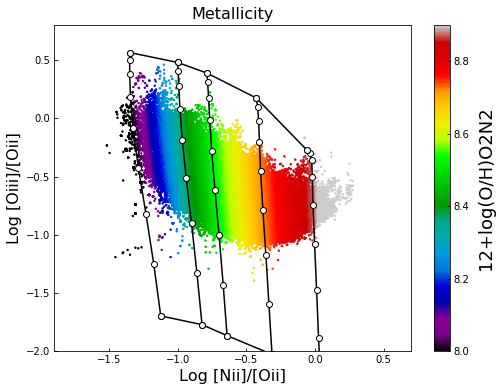

In [84]:
# 画分布图
plt.figure(figsize=(8,6))
# 设置colorbar颜色样式，可以在下面网站查询：
# https://matplotlib.org/tutorials/colors/colormaps.html
cm = plt.cm.get_cmap('nipy_spectral')
# 开始画散点图
sc = plt.scatter(new_xy[:,0], new_xy[:,1],c=Znew, vmin=8, vmax=8.9, s=2, cmap=cm)
# 开始画grid格子
for i in range(7):
    xx=locals()['line'+str(i+1)+'x']
    yy=locals()['line'+str(i+1)+'y']
    plt.plot(xx,yy,'o-',color='black',markerfacecolor='white')
# 坐标轴范围调整
plt.xlim(-1.9, 0.7)
plt.ylim(-2.0, 0.8)
# 坐标轴标题设置
plt.xlabel('Log [Nii]/[Oii]',fontsize=16)    # x轴标签
plt.ylabel('Log [Oiii]/[Oii]',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = plt.colorbar(sc)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("12+log(O/H)O2N2",fontsize=18,labelpad=8)
plt.title('Metallicity',fontsize=16)
plt.show()